# Evaluación de PC-SMOTE con Grid Search en el dataset Shuttle (Generación de caso base y datasets aumentados)


In [1]:
# lo que hace es modificar la lista de rutas de búsqueda de módulos de Python (sys.path) para incluir las carpetas ../scripts y ../datasets como ubicaciones adicionales donde Python puede buscar módulos o paquetes cuando hacés un import.
import sys
sys.path.append("../scripts")
sys.path.append("../datasets")

## Importación de módulos y librerías necesarias


In [2]:
# --- Módulos propios del proyecto ---
from cargar_dataset import cargar_dataset                      # Función para cargar datasets según configuración
from config_datasets import config_datasets                    # Diccionario de configuración de datasets
from evaluacion import evaluar_sampler_holdout                 # Evaluación de sobremuestreo con partición hold-out
from custom_samplers import PCSMOTEWrapper                     # Wrapper personalizado para la técnica PCSMOTE
from pc_smote import PCSMOTE                                   # Implementación principal de PCSMOTE
from graficador2d import Graficador2D                       # Clase para graficar resultados en 2D

# --- Librerías estándar de Python ---
from datetime import datetime, timedelta                       # Manejo de fechas y tiempos
from itertools import product                                  # Generación de combinaciones de parámetros
import os                                                      # Operaciones con el sistema de archivos
import traceback

# --- Librerías científicas ---
import numpy as np                                              # Operaciones numéricas y algebra lineal
import pandas as pd                                             # Manipulación y análisis de datos tabulares
from scipy.stats import uniform                                 # Distribuciones para búsqueda de hiperparámetros

# --- Scikit-learn: preprocesamiento ---
from sklearn.preprocessing import LabelEncoder, StandardScaler # Codificación de etiquetas y escalado de datos
from sklearn.pipeline import make_pipeline, Pipeline            # Creación de pipelines de procesamiento y modelado

# --- Scikit-learn: división y validación ---
from sklearn.model_selection import (
    train_test_split,                                           # División de datos en train/test
    StratifiedKFold,                                            # Validación cruzada estratificada
    RandomizedSearchCV                                          # Búsqueda aleatoria de hiperparámetros
)

# --- Scikit-learn: reducción de dimensionalidad ---
from sklearn.decomposition import PCA                           # Análisis de Componentes Principales

# --- Scikit-learn: métricas ---
from sklearn.metrics import (
    f1_score,                                                    # Métrica F1-Score
    balanced_accuracy_score,                                     # Precisión balanceada
    matthews_corrcoef,                                           # Coeficiente MCC
    cohen_kappa_score,                                           # Kappa de Cohen
    make_scorer                                            
)

# --- Scikit-learn: clasificadores ---
from sklearn.ensemble import RandomForestClassifier             # Clasificador Random Forest
from sklearn.linear_model import LogisticRegression             # Regresión logística
from sklearn.svm import SVC                                      # Máquinas de Vectores de Soporte (SVM)

from sklearn.exceptions import ConvergenceWarning
import warnings


c:\Users\FamiliaNatelloMedina\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Generación del caso base

Este código realiza dos tareas principales para cada dataset configurado en `config_datasets`:

1. **Generar el caso base** (subcarpeta `datasets_aumentados/base/`):
   - Se crea un directorio específico para almacenar la versión original del dataset sin ningún tipo de sobremuestreo.
   - El dataset se carga utilizando la misma función `cargar_dataset` empleada en el pipeline principal.
   - Si las etiquetas (`y`) están en formato de texto u objeto, se convierten a valores numéricos con `LabelEncoder`.
   - Se realiza una división estratificada en conjuntos de entrenamiento y prueba (`train/test`) utilizando `train_test_split` con una proporción 70/30 y una semilla fija para asegurar reproducibilidad.
   - Se guardan dos archivos CSV: `<nombre_dataset>_train.csv` y `<nombre_dataset>_test.csv`.

In [3]:
# --- función: generar caso base (train/test sin sobremuestreo) ---

def generar_caso_base(
    nombre_dataset: str,
    config: dict,
    ruta_base: str = "../datasets/datasets_aumentados/base/",
    test_size: float = 0.30,
    random_state: int = 42,
    overwrite: bool = False
):
    """
    Genera el caso base (sin PCSMOTE) para un dataset: guarda train y test en ruta_base.
    Usa la misma lógica de carga que el resto del pipeline (cargar_dataset + LabelEncoder opcional).

    Retorna:
        (path_train, path_test)
    """
    os.makedirs(ruta_base, exist_ok=True)

    path_train = os.path.join(ruta_base, f"{nombre_dataset}_train.csv")
    path_test  = os.path.join(ruta_base, f"{nombre_dataset}_test.csv")

    if not overwrite and os.path.exists(path_train) and os.path.exists(path_test):
        return path_train, path_test  # ya generado

    # 1) Cargar dataset base con tu helper habitual
    X, y, _ = cargar_dataset(
        path=config["path"],
        clase_minoria=config.get("clase_minoria"),
        col_features=config.get("col_features"),
        col_target=config.get("col_target"),
        sep=config.get("sep", ","),
        header=config.get("header", None),
        binarizar=False,
        tipo=config.get("tipo", "tabular")
    )

    # 2) Asegurar etiquetas numéricas si vienen como strings/objects
    if getattr(y, "dtype", None) == object or (len(y) > 0 and isinstance(y[0], str)):
        y = LabelEncoder().fit_transform(y)

    # 3) Split estratificado (mismo seed para reproducibilidad)
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, stratify=y, random_state=random_state
    )

    # 4) Guardar CSVs
    pd.concat([pd.DataFrame(X_train), pd.Series(y_train, name=config.get("col_target", "target"))], axis=1)\
      .to_csv(path_train, index=False)
    pd.concat([pd.DataFrame(X_test), pd.Series(y_test, name=config.get("col_target", "target"))], axis=1)\
      .to_csv(path_test, index=False)

    return path_train, path_test


In [4]:
def aumentar_dataset_pcsmote_y_guardar(nombre_dataset, config, percentil_densidad, percentil_riesgo, criterio_pureza, test_size=0.2):
    print(f"📂 Cargando dataset: {nombre_dataset}")

    try:
        # 1) Cargar dataset original
        X, y, clases = cargar_dataset(
            path=config["path"],
            clase_minoria=config.get("clase_minoria"),
            col_features=config.get("col_features"),
            col_target=config.get("col_target"),
            sep=config.get("sep", ","),
            header=config.get("header", None),
            binarizar=False,
            tipo=config.get("tipo", "tabular"),
            impute='median',              # o 'drop' 
            na_values=('?', 'NA', 'None') # clave para 'ca' y 'thal'            
        )

        # 2) Codificar etiquetas si son strings
        if y.dtype == object or isinstance(y[0], str):
            y = LabelEncoder().fit_transform(y)

        # 3) Si es un dataset de imágenes, convertir a vector plano
        if config.get("tipo") == "imagen":
            X = X.reshape((X.shape[0], -1)).astype(np.float32)

        # 4) Escalar TODO el dataset antes de dividir
        scaler = StandardScaler()
        X = scaler.fit_transform(X)  

        # 5) Dividir en train/test (después del escalado)
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=test_size, random_state=42, stratify=y
        )
        
        # 6) Aplicar PCSMOTE sobre el set de entrenamiento escalado
        print(f"🧬 Aplicando PCSMOTE | Densidad: {percentil_densidad} | Riesgo: {percentil_riesgo} | Pureza: {criterio_pureza}")
        sampler = PCSMOTE(
            random_state=42,
            percentil_densidad=percentil_densidad,
            percentil_dist=percentil_riesgo,  # <- usar el parámetro de la función
            percentil_entropia=75 if criterio_pureza == 'entropia' else None,
            criterio_pureza=criterio_pureza,
            modo_espacial='2d',  # usa '3d' solo si tus 3 primeras cols son coordenadas
            factor_equilibrio=0.8            
        )
        sampler.nombre_dataset = nombre_dataset

        if hasattr(sampler, "fit_resample_multiclass"):
            X_train_res, y_train_res = sampler.fit_resample_multiclass(X_train, y_train)
        else:
            X_train_res, y_train_res = sampler.fit_resample(X_train, y_train)


        grafo = Graficador2D(
            reductor="pca",
            escalar=True,
            semilla=42,
            percentil_densidad=percentil_densidad,
            percentil_riesgo=percentil_riesgo,
            criterio_pureza=criterio_pureza,
            nombre_dataset=nombre_dataset,
        )

        grafo.trazar_original_vs_aumentado(
            X, y, X_train_res, y_train_res,
            titulo="Original vs. Aumentado",
            nombres_clase=clases
        )

        # 7) Guardar datasets: train aumentado y test escalado
        print(f"💾 Guardando datasets aumentados...")

        ruta_salida = f"../datasets/datasets_aumentados/"
        os.makedirs(ruta_salida, exist_ok=True)

        nombre_base = f"pcsmote_{nombre_dataset}_D{percentil_densidad}_R{percentil_riesgo}_P{criterio_pureza}"
        path_train = os.path.join(ruta_salida, f"{nombre_base}_train.csv")
        path_test = os.path.join(ruta_salida, f"{nombre_base}_test.csv")

        # Guardar train aumentado
        df_train = pd.DataFrame(X_train_res)
        df_train["target"] = y_train_res
        df_train.to_csv(path_train, index=False)

        # Guardar test escalado (sin sobremuestrear)
        df_test = pd.DataFrame(X_test)
        df_test["target"] = y_test
        df_test.to_csv(path_test, index=False)

        print(f"✅ Datasets guardados:\n- Train aumentado: {path_train}\n- Test escalado: {path_test}")
        return path_train, path_test, sampler

    except Exception as e:
        traceback.print_exc()    # <<< esto te dice archivo y línea exacta
        print(f"❌ Error al aumentar dataset {nombre_dataset}: {e}")
        return None, None, None


### 🧬 Aumento de Datasets mediante Técnicas de Sobremuestreo

En esta etapa se genera una versión balanceada de cada dataset original mediante la aplicación de técnicas de sobremuestreo, con el objetivo de mitigar el desbalance de clases antes del entrenamiento de los modelos.

Actualmente, se emplea la técnica:

- `PCSMOTE` (Percentile-Controlled SMOTE), que permite controlar la generación de muestras sintéticas en función de percentiles de densidad, riesgo y pureza.

Para cada dataset, se exploran combinaciones específicas de parámetros según la técnica utilizada. Los datasets resultantes se almacenan en el directorio `datasets/datasets_aumentados/`, utilizando nombres de archivo que reflejan la configuración empleada (por ejemplo: `pcsmote_nombre_D25_R50_Pentropia_train.csv`).

> ⚠️ Esta fase no incluye entrenamiento ni validación de modelos. Su único propósito es generar conjuntos de datos aumentados a partir del conjunto de entrenamiento. La partición `train/test` se realiza previamente, y **solo la parte de entrenamiento es sometida a sobremuestreo**. El conjunto de prueba permanece sin modificar para garantizar una evaluación imparcial posterior.



📁 Dataset: shuttle
#01 ➕ Aumentando con D=25 | R=25 | P=entropia
📂 Cargando dataset: shuttle
🧬 Aplicando PCSMOTE | Densidad: 25 | Riesgo: 25 | Pureza: entropia


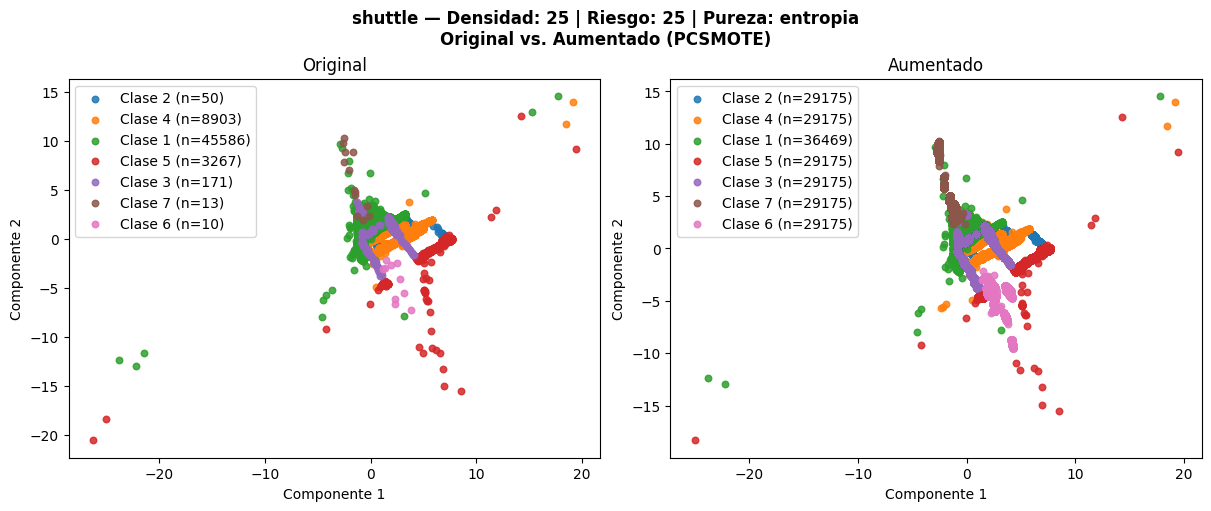

💾 Guardando datasets aumentados...
✅ Datasets guardados:
- Train aumentado: ../datasets/datasets_aumentados/pcsmote_shuttle_D25_R25_Pentropia_train.csv
- Test escalado: ../datasets/datasets_aumentados/pcsmote_shuttle_D25_R25_Pentropia_test.csv
✅ Guardado exitoso:
 - Train: ../datasets/datasets_aumentados/pcsmote_shuttle_D25_R25_Pentropia_train.csv
 - Test: ../datasets/datasets_aumentados/pcsmote_shuttle_D25_R25_Pentropia_test.csv
📁 Log por clase guardado en: ../datasets/datasets_aumentados/logs/pcsmote/por_clase/log_pcsmote_shuttle_D25_R25_Pentropia.csv
📘 Log por muestra guardado en: ../datasets/datasets_aumentados/logs/pcsmote/por_muestras/log_pcsmote_x_muestra_shuttle_D25_R25_Pentropia.xlsx
📄 Log exportado: ../datasets/datasets_aumentados/logs/pcsmote/por_clase/log_pcsmote_shuttle_D25_R25_Pentropia.csv
📄 Log exportado: ../datasets/datasets_aumentados/logs/pcsmote/por_muestras/log_pcsmote_x_muestra_shuttle_D25_R25_Pentropia.xlsx
#02 ➕ Aumentando con D=25 | R=25 | P=proporcion
📂 Cargan

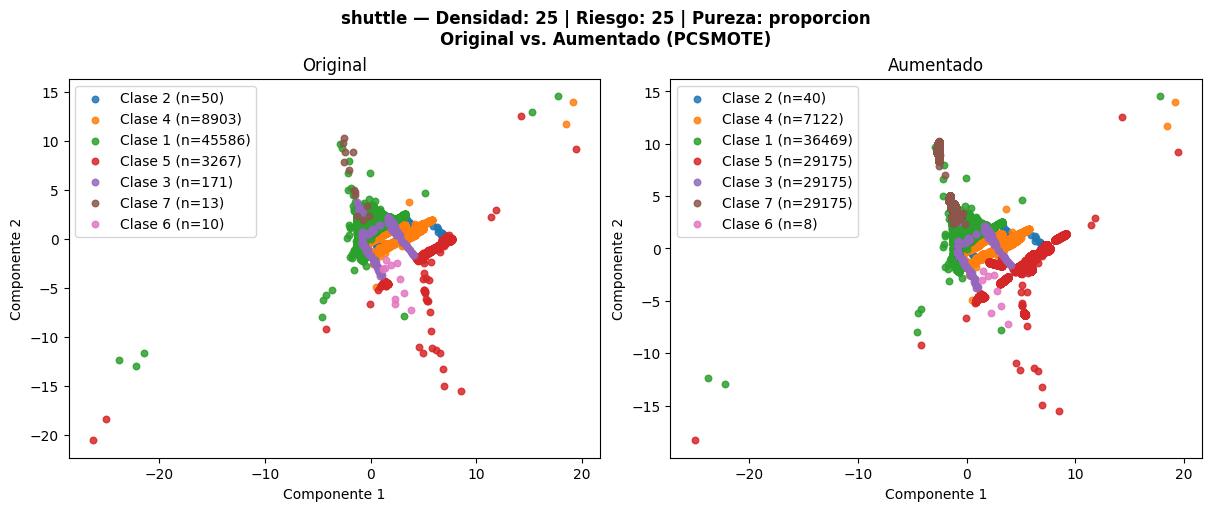

💾 Guardando datasets aumentados...
✅ Datasets guardados:
- Train aumentado: ../datasets/datasets_aumentados/pcsmote_shuttle_D25_R25_Pproporcion_train.csv
- Test escalado: ../datasets/datasets_aumentados/pcsmote_shuttle_D25_R25_Pproporcion_test.csv
✅ Guardado exitoso:
 - Train: ../datasets/datasets_aumentados/pcsmote_shuttle_D25_R25_Pproporcion_train.csv
 - Test: ../datasets/datasets_aumentados/pcsmote_shuttle_D25_R25_Pproporcion_test.csv
📁 Log por clase guardado en: ../datasets/datasets_aumentados/logs/pcsmote/por_clase/log_pcsmote_shuttle_D25_R25_Pproporcion.csv
📘 Log por muestra guardado en: ../datasets/datasets_aumentados/logs/pcsmote/por_muestras/log_pcsmote_x_muestra_shuttle_D25_R25_Pproporcion.xlsx
📄 Log exportado: ../datasets/datasets_aumentados/logs/pcsmote/por_clase/log_pcsmote_shuttle_D25_R25_Pproporcion.csv
📄 Log exportado: ../datasets/datasets_aumentados/logs/pcsmote/por_muestras/log_pcsmote_x_muestra_shuttle_D25_R25_Pproporcion.xlsx
#03 ➕ Aumentando con D=25 | R=50 | P=ent

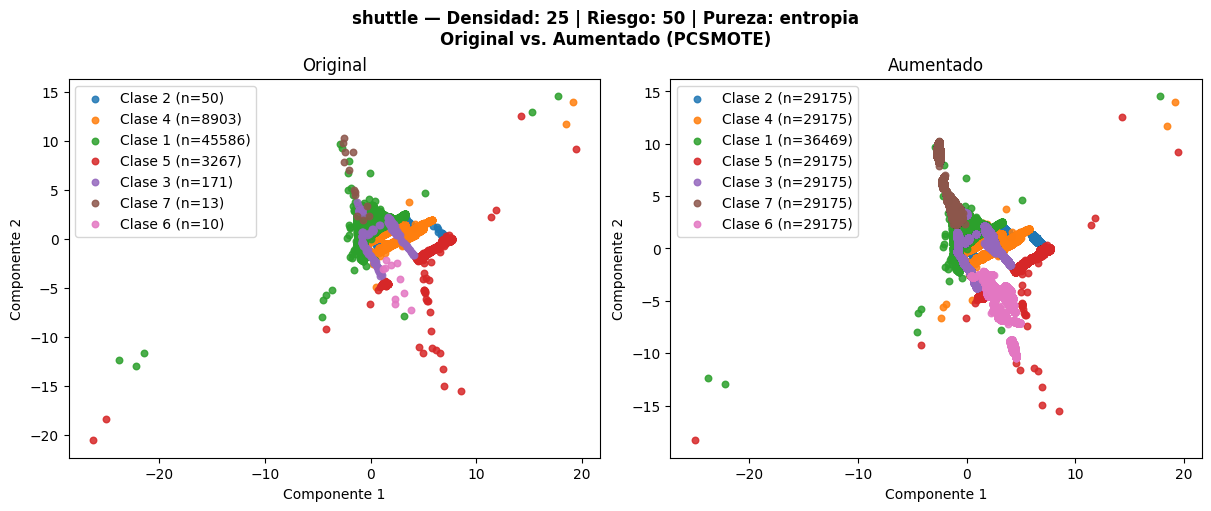

💾 Guardando datasets aumentados...
✅ Datasets guardados:
- Train aumentado: ../datasets/datasets_aumentados/pcsmote_shuttle_D25_R50_Pentropia_train.csv
- Test escalado: ../datasets/datasets_aumentados/pcsmote_shuttle_D25_R50_Pentropia_test.csv
✅ Guardado exitoso:
 - Train: ../datasets/datasets_aumentados/pcsmote_shuttle_D25_R50_Pentropia_train.csv
 - Test: ../datasets/datasets_aumentados/pcsmote_shuttle_D25_R50_Pentropia_test.csv
📁 Log por clase guardado en: ../datasets/datasets_aumentados/logs/pcsmote/por_clase/log_pcsmote_shuttle_D25_R50_Pentropia.csv
📘 Log por muestra guardado en: ../datasets/datasets_aumentados/logs/pcsmote/por_muestras/log_pcsmote_x_muestra_shuttle_D25_R50_Pentropia.xlsx
📄 Log exportado: ../datasets/datasets_aumentados/logs/pcsmote/por_clase/log_pcsmote_shuttle_D25_R50_Pentropia.csv
📄 Log exportado: ../datasets/datasets_aumentados/logs/pcsmote/por_muestras/log_pcsmote_x_muestra_shuttle_D25_R50_Pentropia.xlsx
#04 ➕ Aumentando con D=25 | R=50 | P=proporcion
📂 Cargan

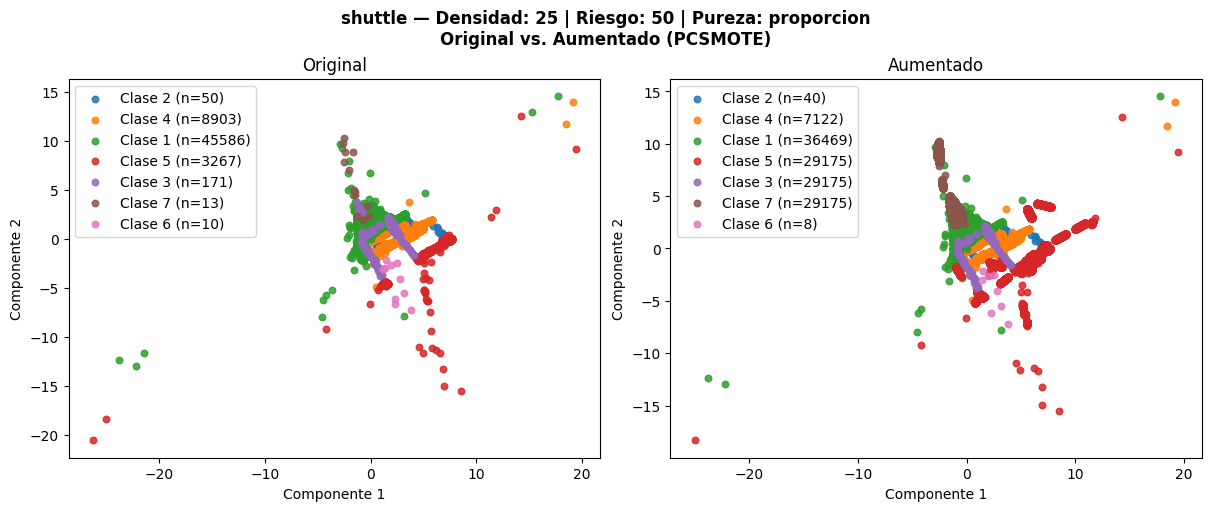

💾 Guardando datasets aumentados...
✅ Datasets guardados:
- Train aumentado: ../datasets/datasets_aumentados/pcsmote_shuttle_D25_R50_Pproporcion_train.csv
- Test escalado: ../datasets/datasets_aumentados/pcsmote_shuttle_D25_R50_Pproporcion_test.csv
✅ Guardado exitoso:
 - Train: ../datasets/datasets_aumentados/pcsmote_shuttle_D25_R50_Pproporcion_train.csv
 - Test: ../datasets/datasets_aumentados/pcsmote_shuttle_D25_R50_Pproporcion_test.csv
📁 Log por clase guardado en: ../datasets/datasets_aumentados/logs/pcsmote/por_clase/log_pcsmote_shuttle_D25_R50_Pproporcion.csv
📘 Log por muestra guardado en: ../datasets/datasets_aumentados/logs/pcsmote/por_muestras/log_pcsmote_x_muestra_shuttle_D25_R50_Pproporcion.xlsx
📄 Log exportado: ../datasets/datasets_aumentados/logs/pcsmote/por_clase/log_pcsmote_shuttle_D25_R50_Pproporcion.csv
📄 Log exportado: ../datasets/datasets_aumentados/logs/pcsmote/por_muestras/log_pcsmote_x_muestra_shuttle_D25_R50_Pproporcion.xlsx
#05 ➕ Aumentando con D=25 | R=75 | P=ent

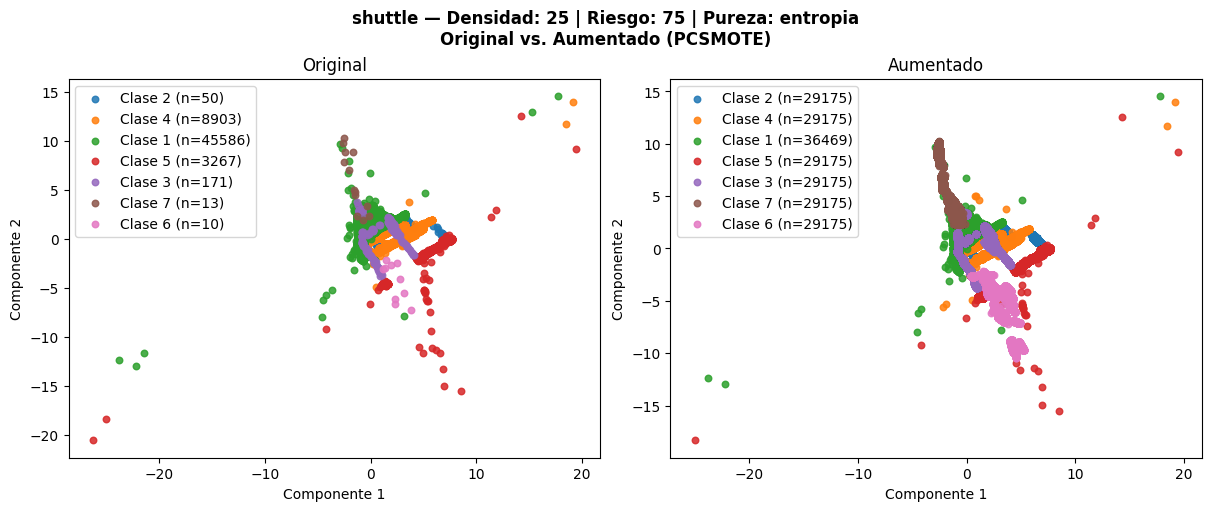

💾 Guardando datasets aumentados...
✅ Datasets guardados:
- Train aumentado: ../datasets/datasets_aumentados/pcsmote_shuttle_D25_R75_Pentropia_train.csv
- Test escalado: ../datasets/datasets_aumentados/pcsmote_shuttle_D25_R75_Pentropia_test.csv
✅ Guardado exitoso:
 - Train: ../datasets/datasets_aumentados/pcsmote_shuttle_D25_R75_Pentropia_train.csv
 - Test: ../datasets/datasets_aumentados/pcsmote_shuttle_D25_R75_Pentropia_test.csv
📁 Log por clase guardado en: ../datasets/datasets_aumentados/logs/pcsmote/por_clase/log_pcsmote_shuttle_D25_R75_Pentropia.csv
📘 Log por muestra guardado en: ../datasets/datasets_aumentados/logs/pcsmote/por_muestras/log_pcsmote_x_muestra_shuttle_D25_R75_Pentropia.xlsx
📄 Log exportado: ../datasets/datasets_aumentados/logs/pcsmote/por_clase/log_pcsmote_shuttle_D25_R75_Pentropia.csv
📄 Log exportado: ../datasets/datasets_aumentados/logs/pcsmote/por_muestras/log_pcsmote_x_muestra_shuttle_D25_R75_Pentropia.xlsx
#06 ➕ Aumentando con D=25 | R=75 | P=proporcion
📂 Cargan

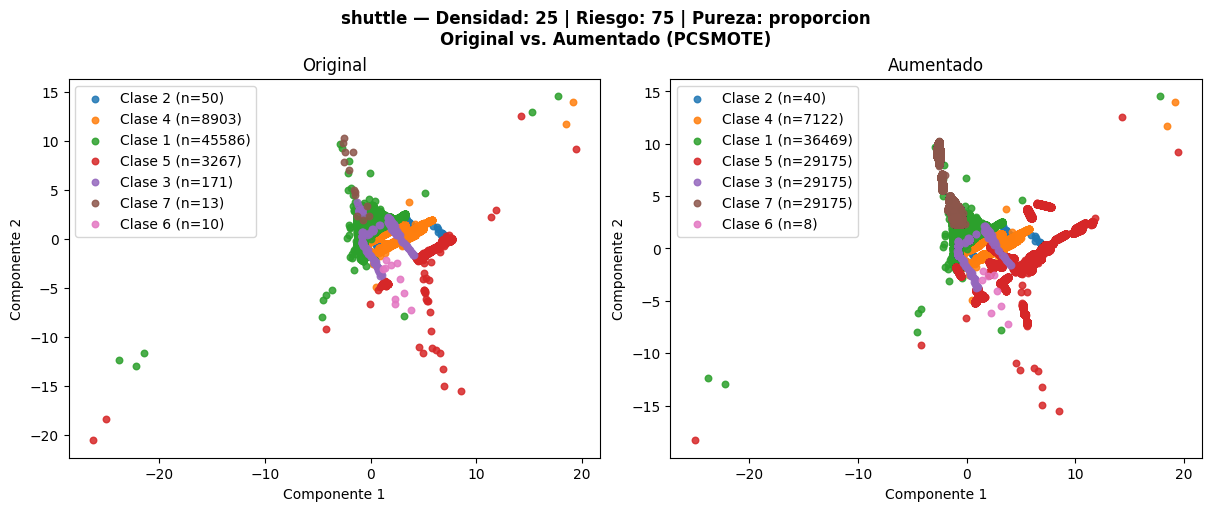

💾 Guardando datasets aumentados...
✅ Datasets guardados:
- Train aumentado: ../datasets/datasets_aumentados/pcsmote_shuttle_D25_R75_Pproporcion_train.csv
- Test escalado: ../datasets/datasets_aumentados/pcsmote_shuttle_D25_R75_Pproporcion_test.csv
✅ Guardado exitoso:
 - Train: ../datasets/datasets_aumentados/pcsmote_shuttle_D25_R75_Pproporcion_train.csv
 - Test: ../datasets/datasets_aumentados/pcsmote_shuttle_D25_R75_Pproporcion_test.csv
📁 Log por clase guardado en: ../datasets/datasets_aumentados/logs/pcsmote/por_clase/log_pcsmote_shuttle_D25_R75_Pproporcion.csv
📘 Log por muestra guardado en: ../datasets/datasets_aumentados/logs/pcsmote/por_muestras/log_pcsmote_x_muestra_shuttle_D25_R75_Pproporcion.xlsx
📄 Log exportado: ../datasets/datasets_aumentados/logs/pcsmote/por_clase/log_pcsmote_shuttle_D25_R75_Pproporcion.csv
📄 Log exportado: ../datasets/datasets_aumentados/logs/pcsmote/por_muestras/log_pcsmote_x_muestra_shuttle_D25_R75_Pproporcion.xlsx
#07 ➕ Aumentando con D=50 | R=25 | P=ent

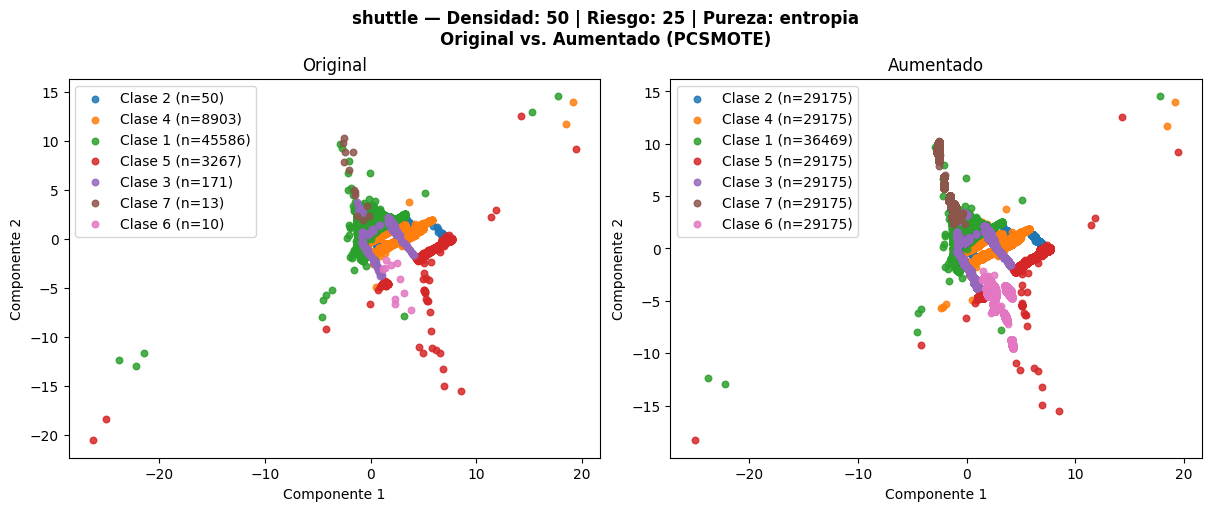

💾 Guardando datasets aumentados...
✅ Datasets guardados:
- Train aumentado: ../datasets/datasets_aumentados/pcsmote_shuttle_D50_R25_Pentropia_train.csv
- Test escalado: ../datasets/datasets_aumentados/pcsmote_shuttle_D50_R25_Pentropia_test.csv
✅ Guardado exitoso:
 - Train: ../datasets/datasets_aumentados/pcsmote_shuttle_D50_R25_Pentropia_train.csv
 - Test: ../datasets/datasets_aumentados/pcsmote_shuttle_D50_R25_Pentropia_test.csv
📁 Log por clase guardado en: ../datasets/datasets_aumentados/logs/pcsmote/por_clase/log_pcsmote_shuttle_D50_R25_Pentropia.csv
📘 Log por muestra guardado en: ../datasets/datasets_aumentados/logs/pcsmote/por_muestras/log_pcsmote_x_muestra_shuttle_D50_R25_Pentropia.xlsx
📄 Log exportado: ../datasets/datasets_aumentados/logs/pcsmote/por_clase/log_pcsmote_shuttle_D50_R25_Pentropia.csv
📄 Log exportado: ../datasets/datasets_aumentados/logs/pcsmote/por_muestras/log_pcsmote_x_muestra_shuttle_D50_R25_Pentropia.xlsx
#08 ➕ Aumentando con D=50 | R=25 | P=proporcion
📂 Cargan

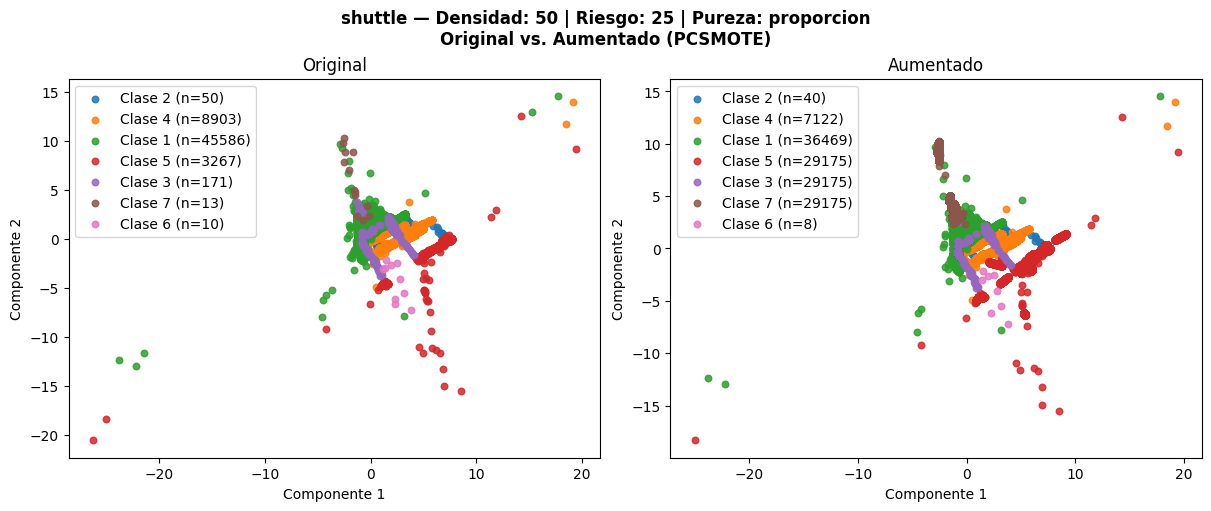

💾 Guardando datasets aumentados...
✅ Datasets guardados:
- Train aumentado: ../datasets/datasets_aumentados/pcsmote_shuttle_D50_R25_Pproporcion_train.csv
- Test escalado: ../datasets/datasets_aumentados/pcsmote_shuttle_D50_R25_Pproporcion_test.csv
✅ Guardado exitoso:
 - Train: ../datasets/datasets_aumentados/pcsmote_shuttle_D50_R25_Pproporcion_train.csv
 - Test: ../datasets/datasets_aumentados/pcsmote_shuttle_D50_R25_Pproporcion_test.csv
📁 Log por clase guardado en: ../datasets/datasets_aumentados/logs/pcsmote/por_clase/log_pcsmote_shuttle_D50_R25_Pproporcion.csv
📘 Log por muestra guardado en: ../datasets/datasets_aumentados/logs/pcsmote/por_muestras/log_pcsmote_x_muestra_shuttle_D50_R25_Pproporcion.xlsx
📄 Log exportado: ../datasets/datasets_aumentados/logs/pcsmote/por_clase/log_pcsmote_shuttle_D50_R25_Pproporcion.csv
📄 Log exportado: ../datasets/datasets_aumentados/logs/pcsmote/por_muestras/log_pcsmote_x_muestra_shuttle_D50_R25_Pproporcion.xlsx
#09 ➕ Aumentando con D=50 | R=50 | P=ent

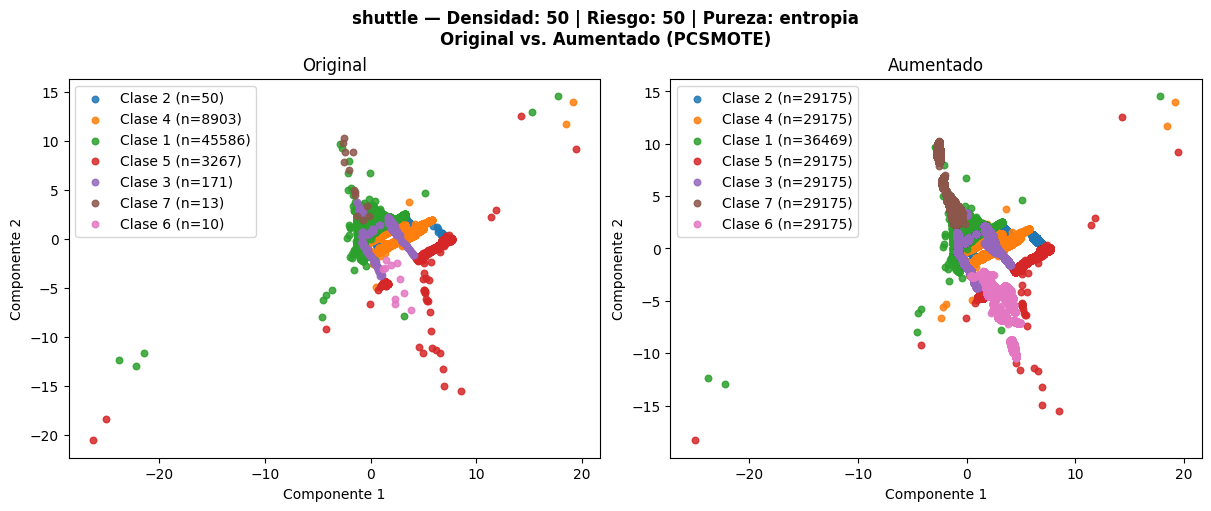

💾 Guardando datasets aumentados...
✅ Datasets guardados:
- Train aumentado: ../datasets/datasets_aumentados/pcsmote_shuttle_D50_R50_Pentropia_train.csv
- Test escalado: ../datasets/datasets_aumentados/pcsmote_shuttle_D50_R50_Pentropia_test.csv
✅ Guardado exitoso:
 - Train: ../datasets/datasets_aumentados/pcsmote_shuttle_D50_R50_Pentropia_train.csv
 - Test: ../datasets/datasets_aumentados/pcsmote_shuttle_D50_R50_Pentropia_test.csv
📁 Log por clase guardado en: ../datasets/datasets_aumentados/logs/pcsmote/por_clase/log_pcsmote_shuttle_D50_R50_Pentropia.csv
📘 Log por muestra guardado en: ../datasets/datasets_aumentados/logs/pcsmote/por_muestras/log_pcsmote_x_muestra_shuttle_D50_R50_Pentropia.xlsx
📄 Log exportado: ../datasets/datasets_aumentados/logs/pcsmote/por_clase/log_pcsmote_shuttle_D50_R50_Pentropia.csv
📄 Log exportado: ../datasets/datasets_aumentados/logs/pcsmote/por_muestras/log_pcsmote_x_muestra_shuttle_D50_R50_Pentropia.xlsx
#10 ➕ Aumentando con D=50 | R=50 | P=proporcion
📂 Cargan

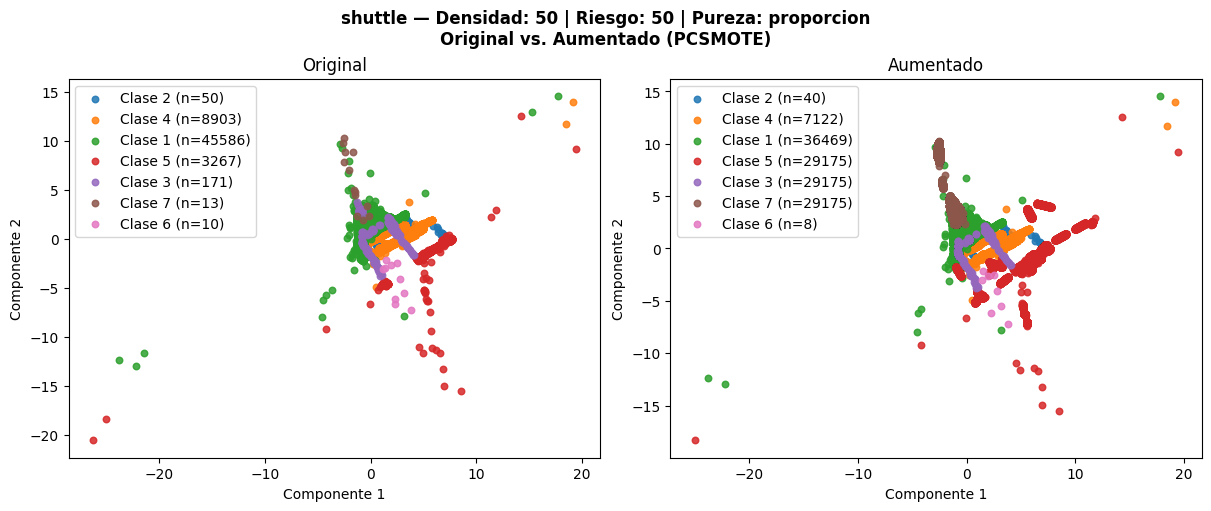

💾 Guardando datasets aumentados...
✅ Datasets guardados:
- Train aumentado: ../datasets/datasets_aumentados/pcsmote_shuttle_D50_R50_Pproporcion_train.csv
- Test escalado: ../datasets/datasets_aumentados/pcsmote_shuttle_D50_R50_Pproporcion_test.csv
✅ Guardado exitoso:
 - Train: ../datasets/datasets_aumentados/pcsmote_shuttle_D50_R50_Pproporcion_train.csv
 - Test: ../datasets/datasets_aumentados/pcsmote_shuttle_D50_R50_Pproporcion_test.csv
📁 Log por clase guardado en: ../datasets/datasets_aumentados/logs/pcsmote/por_clase/log_pcsmote_shuttle_D50_R50_Pproporcion.csv
📘 Log por muestra guardado en: ../datasets/datasets_aumentados/logs/pcsmote/por_muestras/log_pcsmote_x_muestra_shuttle_D50_R50_Pproporcion.xlsx
📄 Log exportado: ../datasets/datasets_aumentados/logs/pcsmote/por_clase/log_pcsmote_shuttle_D50_R50_Pproporcion.csv
📄 Log exportado: ../datasets/datasets_aumentados/logs/pcsmote/por_muestras/log_pcsmote_x_muestra_shuttle_D50_R50_Pproporcion.xlsx
#11 ➕ Aumentando con D=50 | R=75 | P=ent

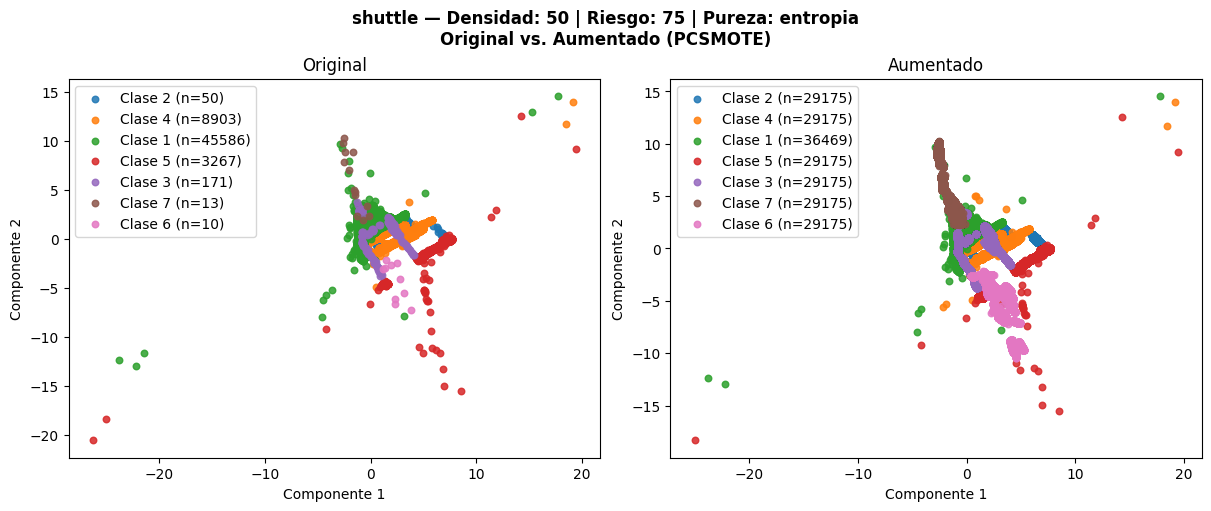

💾 Guardando datasets aumentados...
✅ Datasets guardados:
- Train aumentado: ../datasets/datasets_aumentados/pcsmote_shuttle_D50_R75_Pentropia_train.csv
- Test escalado: ../datasets/datasets_aumentados/pcsmote_shuttle_D50_R75_Pentropia_test.csv
✅ Guardado exitoso:
 - Train: ../datasets/datasets_aumentados/pcsmote_shuttle_D50_R75_Pentropia_train.csv
 - Test: ../datasets/datasets_aumentados/pcsmote_shuttle_D50_R75_Pentropia_test.csv
📁 Log por clase guardado en: ../datasets/datasets_aumentados/logs/pcsmote/por_clase/log_pcsmote_shuttle_D50_R75_Pentropia.csv
📘 Log por muestra guardado en: ../datasets/datasets_aumentados/logs/pcsmote/por_muestras/log_pcsmote_x_muestra_shuttle_D50_R75_Pentropia.xlsx
📄 Log exportado: ../datasets/datasets_aumentados/logs/pcsmote/por_clase/log_pcsmote_shuttle_D50_R75_Pentropia.csv
📄 Log exportado: ../datasets/datasets_aumentados/logs/pcsmote/por_muestras/log_pcsmote_x_muestra_shuttle_D50_R75_Pentropia.xlsx
#12 ➕ Aumentando con D=50 | R=75 | P=proporcion
📂 Cargan

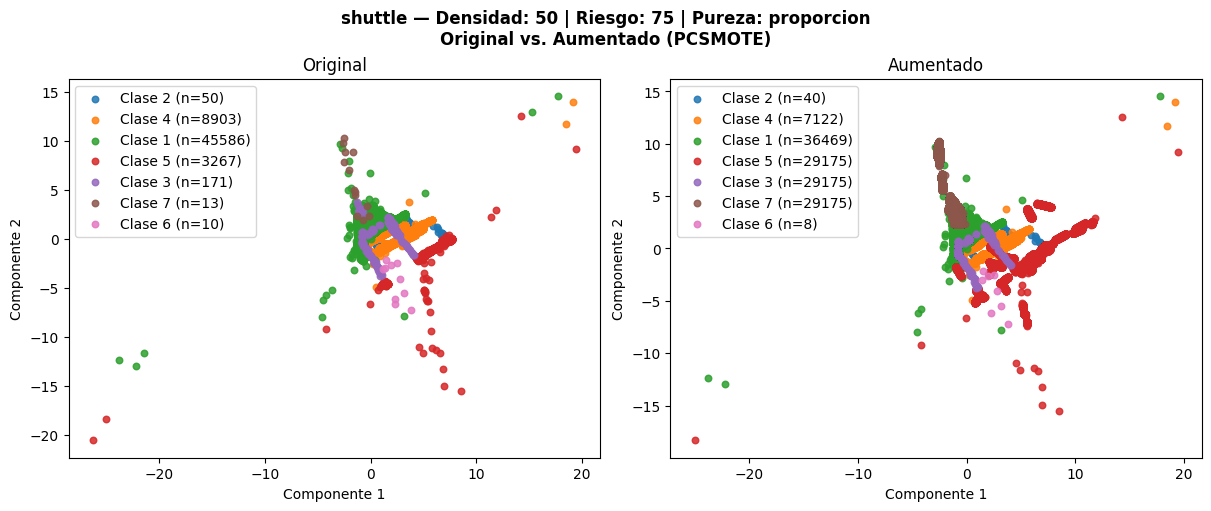

💾 Guardando datasets aumentados...
✅ Datasets guardados:
- Train aumentado: ../datasets/datasets_aumentados/pcsmote_shuttle_D50_R75_Pproporcion_train.csv
- Test escalado: ../datasets/datasets_aumentados/pcsmote_shuttle_D50_R75_Pproporcion_test.csv
✅ Guardado exitoso:
 - Train: ../datasets/datasets_aumentados/pcsmote_shuttle_D50_R75_Pproporcion_train.csv
 - Test: ../datasets/datasets_aumentados/pcsmote_shuttle_D50_R75_Pproporcion_test.csv
📁 Log por clase guardado en: ../datasets/datasets_aumentados/logs/pcsmote/por_clase/log_pcsmote_shuttle_D50_R75_Pproporcion.csv
📘 Log por muestra guardado en: ../datasets/datasets_aumentados/logs/pcsmote/por_muestras/log_pcsmote_x_muestra_shuttle_D50_R75_Pproporcion.xlsx
📄 Log exportado: ../datasets/datasets_aumentados/logs/pcsmote/por_clase/log_pcsmote_shuttle_D50_R75_Pproporcion.csv
📄 Log exportado: ../datasets/datasets_aumentados/logs/pcsmote/por_muestras/log_pcsmote_x_muestra_shuttle_D50_R75_Pproporcion.xlsx
#13 ➕ Aumentando con D=75 | R=25 | P=ent

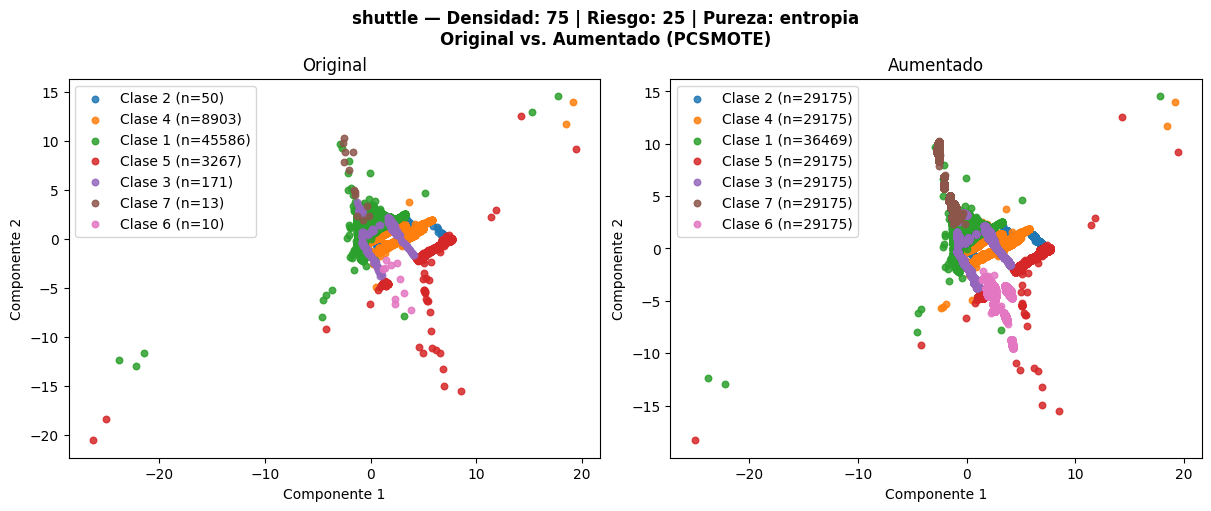

💾 Guardando datasets aumentados...
✅ Datasets guardados:
- Train aumentado: ../datasets/datasets_aumentados/pcsmote_shuttle_D75_R25_Pentropia_train.csv
- Test escalado: ../datasets/datasets_aumentados/pcsmote_shuttle_D75_R25_Pentropia_test.csv
✅ Guardado exitoso:
 - Train: ../datasets/datasets_aumentados/pcsmote_shuttle_D75_R25_Pentropia_train.csv
 - Test: ../datasets/datasets_aumentados/pcsmote_shuttle_D75_R25_Pentropia_test.csv
📁 Log por clase guardado en: ../datasets/datasets_aumentados/logs/pcsmote/por_clase/log_pcsmote_shuttle_D75_R25_Pentropia.csv
📘 Log por muestra guardado en: ../datasets/datasets_aumentados/logs/pcsmote/por_muestras/log_pcsmote_x_muestra_shuttle_D75_R25_Pentropia.xlsx
📄 Log exportado: ../datasets/datasets_aumentados/logs/pcsmote/por_clase/log_pcsmote_shuttle_D75_R25_Pentropia.csv
📄 Log exportado: ../datasets/datasets_aumentados/logs/pcsmote/por_muestras/log_pcsmote_x_muestra_shuttle_D75_R25_Pentropia.xlsx
#14 ➕ Aumentando con D=75 | R=25 | P=proporcion
📂 Cargan

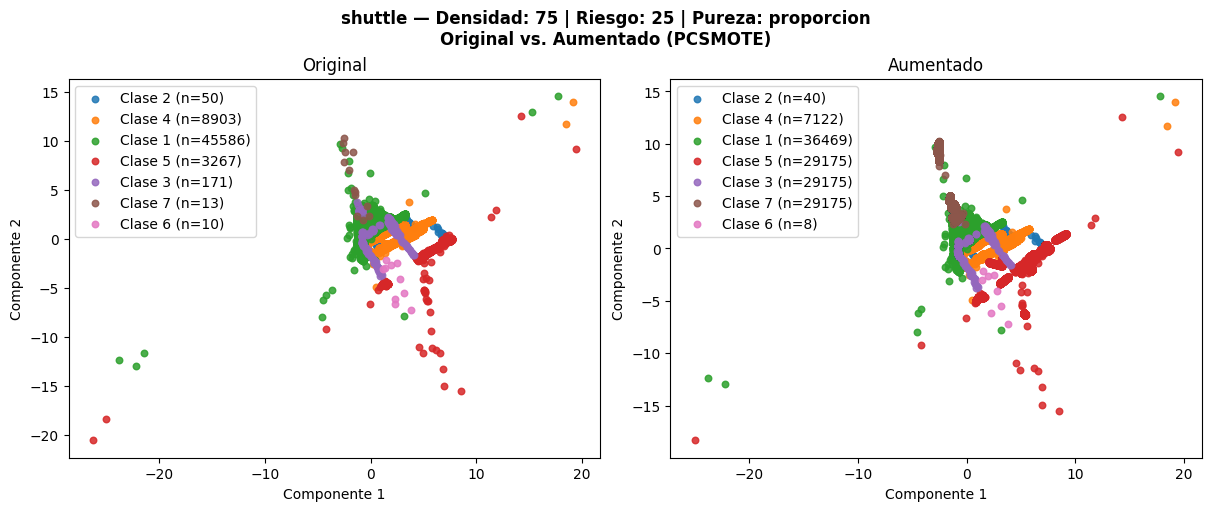

💾 Guardando datasets aumentados...
✅ Datasets guardados:
- Train aumentado: ../datasets/datasets_aumentados/pcsmote_shuttle_D75_R25_Pproporcion_train.csv
- Test escalado: ../datasets/datasets_aumentados/pcsmote_shuttle_D75_R25_Pproporcion_test.csv
✅ Guardado exitoso:
 - Train: ../datasets/datasets_aumentados/pcsmote_shuttle_D75_R25_Pproporcion_train.csv
 - Test: ../datasets/datasets_aumentados/pcsmote_shuttle_D75_R25_Pproporcion_test.csv
📁 Log por clase guardado en: ../datasets/datasets_aumentados/logs/pcsmote/por_clase/log_pcsmote_shuttle_D75_R25_Pproporcion.csv
📘 Log por muestra guardado en: ../datasets/datasets_aumentados/logs/pcsmote/por_muestras/log_pcsmote_x_muestra_shuttle_D75_R25_Pproporcion.xlsx
📄 Log exportado: ../datasets/datasets_aumentados/logs/pcsmote/por_clase/log_pcsmote_shuttle_D75_R25_Pproporcion.csv
📄 Log exportado: ../datasets/datasets_aumentados/logs/pcsmote/por_muestras/log_pcsmote_x_muestra_shuttle_D75_R25_Pproporcion.xlsx
#15 ➕ Aumentando con D=75 | R=50 | P=ent

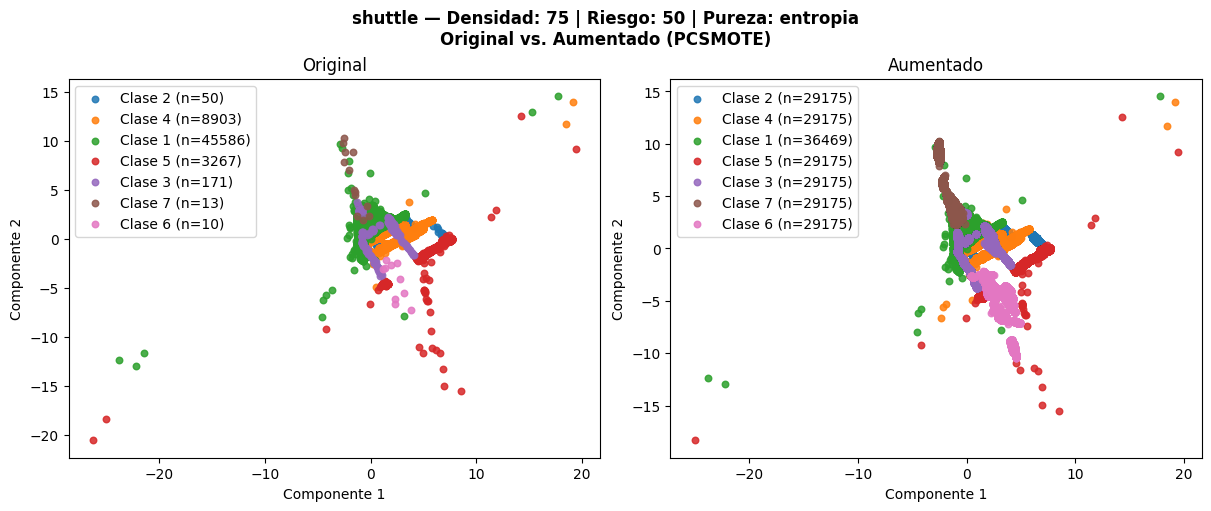

💾 Guardando datasets aumentados...
✅ Datasets guardados:
- Train aumentado: ../datasets/datasets_aumentados/pcsmote_shuttle_D75_R50_Pentropia_train.csv
- Test escalado: ../datasets/datasets_aumentados/pcsmote_shuttle_D75_R50_Pentropia_test.csv
✅ Guardado exitoso:
 - Train: ../datasets/datasets_aumentados/pcsmote_shuttle_D75_R50_Pentropia_train.csv
 - Test: ../datasets/datasets_aumentados/pcsmote_shuttle_D75_R50_Pentropia_test.csv
📁 Log por clase guardado en: ../datasets/datasets_aumentados/logs/pcsmote/por_clase/log_pcsmote_shuttle_D75_R50_Pentropia.csv
📘 Log por muestra guardado en: ../datasets/datasets_aumentados/logs/pcsmote/por_muestras/log_pcsmote_x_muestra_shuttle_D75_R50_Pentropia.xlsx
📄 Log exportado: ../datasets/datasets_aumentados/logs/pcsmote/por_clase/log_pcsmote_shuttle_D75_R50_Pentropia.csv
📄 Log exportado: ../datasets/datasets_aumentados/logs/pcsmote/por_muestras/log_pcsmote_x_muestra_shuttle_D75_R50_Pentropia.xlsx
#16 ➕ Aumentando con D=75 | R=50 | P=proporcion
📂 Cargan

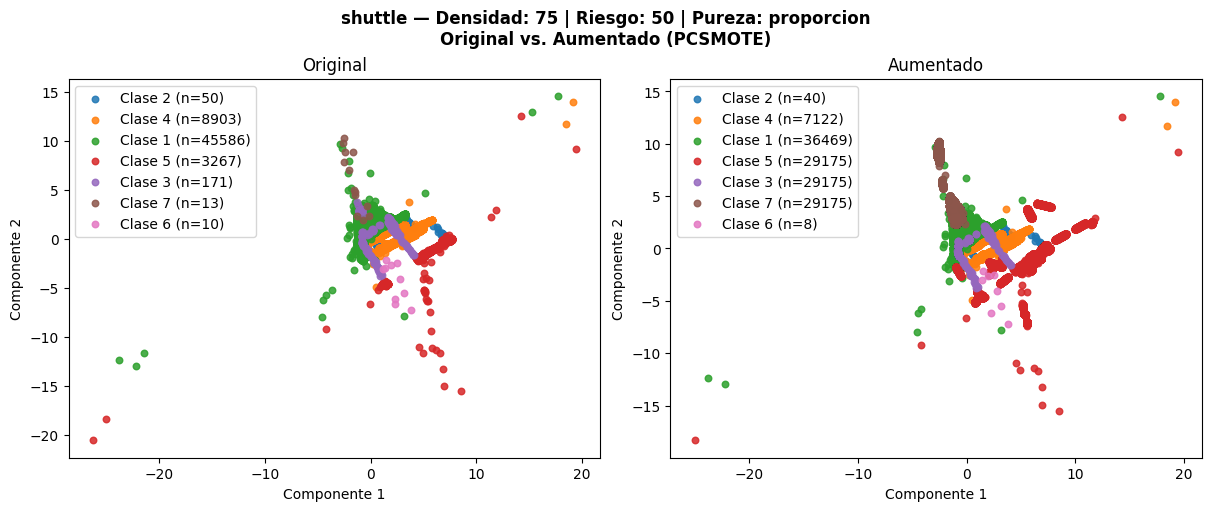

💾 Guardando datasets aumentados...
✅ Datasets guardados:
- Train aumentado: ../datasets/datasets_aumentados/pcsmote_shuttle_D75_R50_Pproporcion_train.csv
- Test escalado: ../datasets/datasets_aumentados/pcsmote_shuttle_D75_R50_Pproporcion_test.csv
✅ Guardado exitoso:
 - Train: ../datasets/datasets_aumentados/pcsmote_shuttle_D75_R50_Pproporcion_train.csv
 - Test: ../datasets/datasets_aumentados/pcsmote_shuttle_D75_R50_Pproporcion_test.csv
📁 Log por clase guardado en: ../datasets/datasets_aumentados/logs/pcsmote/por_clase/log_pcsmote_shuttle_D75_R50_Pproporcion.csv
📘 Log por muestra guardado en: ../datasets/datasets_aumentados/logs/pcsmote/por_muestras/log_pcsmote_x_muestra_shuttle_D75_R50_Pproporcion.xlsx
📄 Log exportado: ../datasets/datasets_aumentados/logs/pcsmote/por_clase/log_pcsmote_shuttle_D75_R50_Pproporcion.csv
📄 Log exportado: ../datasets/datasets_aumentados/logs/pcsmote/por_muestras/log_pcsmote_x_muestra_shuttle_D75_R50_Pproporcion.xlsx
#17 ➕ Aumentando con D=75 | R=75 | P=ent

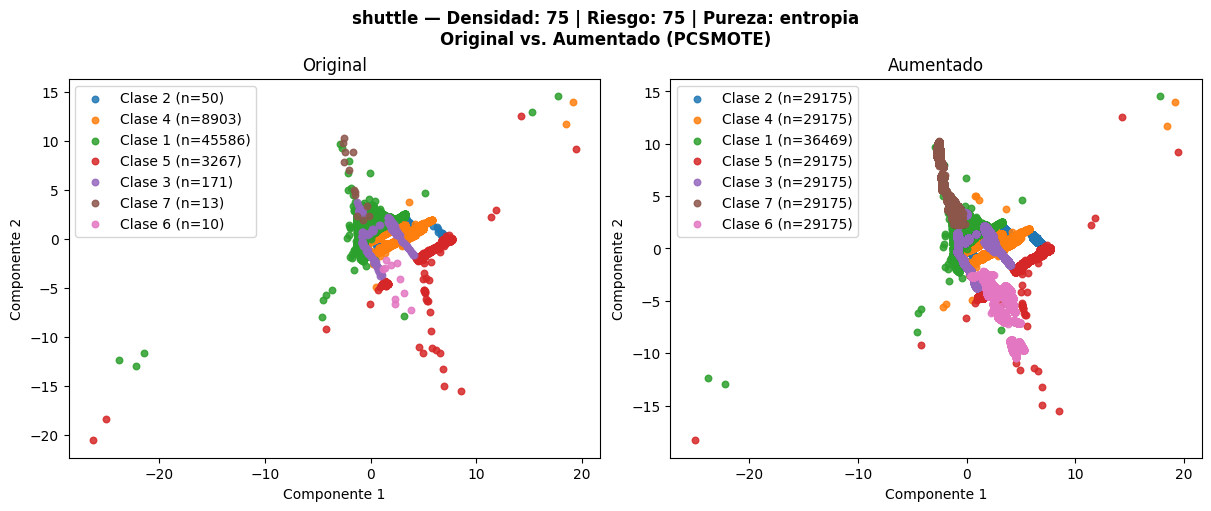

💾 Guardando datasets aumentados...
✅ Datasets guardados:
- Train aumentado: ../datasets/datasets_aumentados/pcsmote_shuttle_D75_R75_Pentropia_train.csv
- Test escalado: ../datasets/datasets_aumentados/pcsmote_shuttle_D75_R75_Pentropia_test.csv
✅ Guardado exitoso:
 - Train: ../datasets/datasets_aumentados/pcsmote_shuttle_D75_R75_Pentropia_train.csv
 - Test: ../datasets/datasets_aumentados/pcsmote_shuttle_D75_R75_Pentropia_test.csv
📁 Log por clase guardado en: ../datasets/datasets_aumentados/logs/pcsmote/por_clase/log_pcsmote_shuttle_D75_R75_Pentropia.csv
📘 Log por muestra guardado en: ../datasets/datasets_aumentados/logs/pcsmote/por_muestras/log_pcsmote_x_muestra_shuttle_D75_R75_Pentropia.xlsx
📄 Log exportado: ../datasets/datasets_aumentados/logs/pcsmote/por_clase/log_pcsmote_shuttle_D75_R75_Pentropia.csv
📄 Log exportado: ../datasets/datasets_aumentados/logs/pcsmote/por_muestras/log_pcsmote_x_muestra_shuttle_D75_R75_Pentropia.xlsx
#18 ➕ Aumentando con D=75 | R=75 | P=proporcion
📂 Cargan

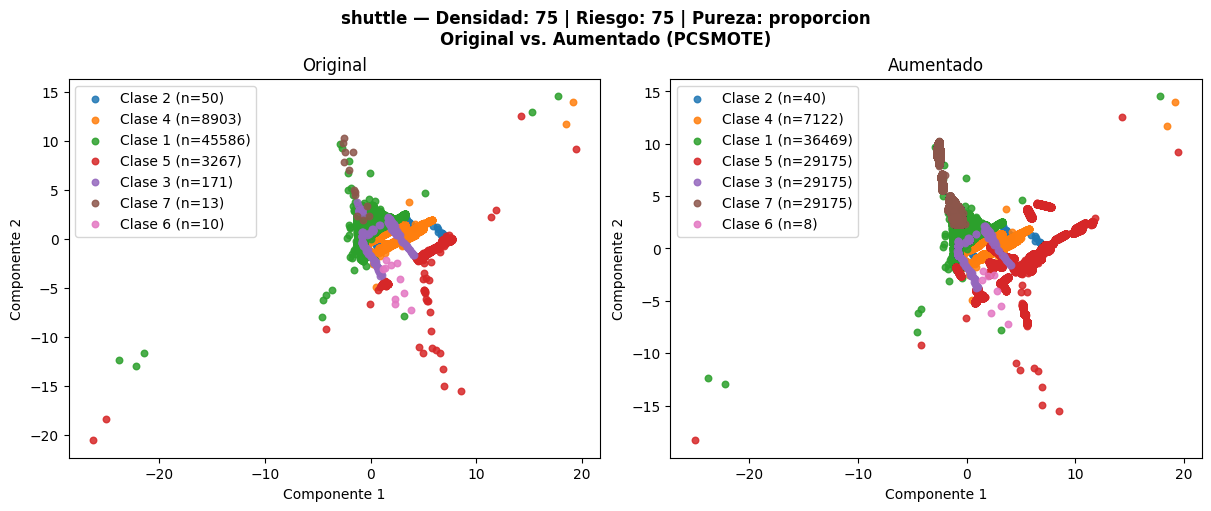

💾 Guardando datasets aumentados...
✅ Datasets guardados:
- Train aumentado: ../datasets/datasets_aumentados/pcsmote_shuttle_D75_R75_Pproporcion_train.csv
- Test escalado: ../datasets/datasets_aumentados/pcsmote_shuttle_D75_R75_Pproporcion_test.csv
✅ Guardado exitoso:
 - Train: ../datasets/datasets_aumentados/pcsmote_shuttle_D75_R75_Pproporcion_train.csv
 - Test: ../datasets/datasets_aumentados/pcsmote_shuttle_D75_R75_Pproporcion_test.csv
📁 Log por clase guardado en: ../datasets/datasets_aumentados/logs/pcsmote/por_clase/log_pcsmote_shuttle_D75_R75_Pproporcion.csv
📘 Log por muestra guardado en: ../datasets/datasets_aumentados/logs/pcsmote/por_muestras/log_pcsmote_x_muestra_shuttle_D75_R75_Pproporcion.xlsx
📄 Log exportado: ../datasets/datasets_aumentados/logs/pcsmote/por_clase/log_pcsmote_shuttle_D75_R75_Pproporcion.csv
📄 Log exportado: ../datasets/datasets_aumentados/logs/pcsmote/por_muestras/log_pcsmote_x_muestra_shuttle_D75_R75_Pproporcion.xlsx

📁 Dataset: wdbc
#01 ➕ Aumentando con D=

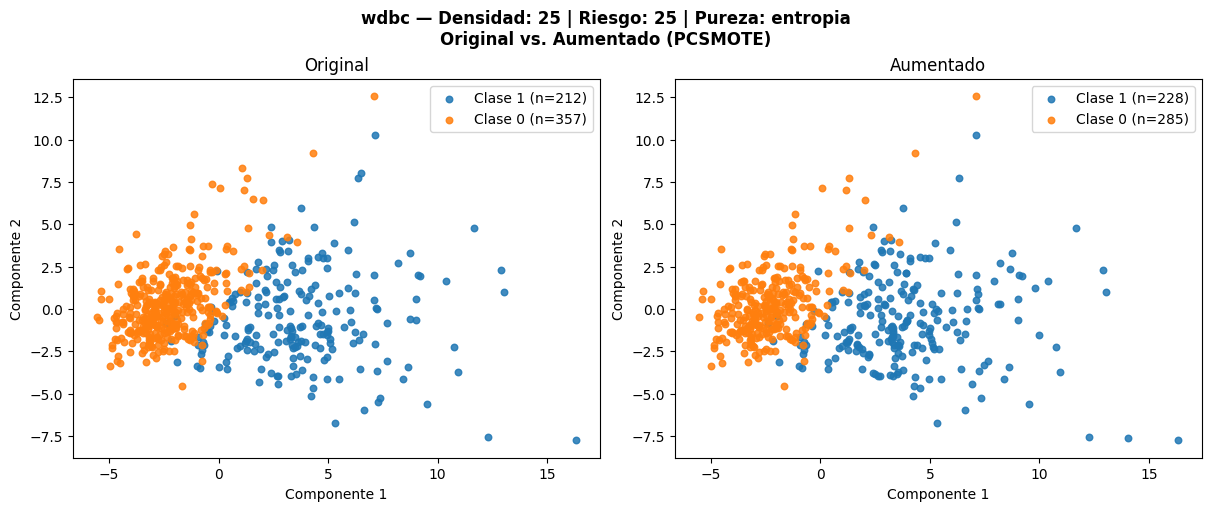

💾 Guardando datasets aumentados...
✅ Datasets guardados:
- Train aumentado: ../datasets/datasets_aumentados/pcsmote_wdbc_D25_R25_Pentropia_train.csv
- Test escalado: ../datasets/datasets_aumentados/pcsmote_wdbc_D25_R25_Pentropia_test.csv
✅ Guardado exitoso:
 - Train: ../datasets/datasets_aumentados/pcsmote_wdbc_D25_R25_Pentropia_train.csv
 - Test: ../datasets/datasets_aumentados/pcsmote_wdbc_D25_R25_Pentropia_test.csv
📁 Log por clase guardado en: ../datasets/datasets_aumentados/logs/pcsmote/por_clase/log_pcsmote_wdbc_D25_R25_Pentropia.csv
📘 Log por muestra guardado en: ../datasets/datasets_aumentados/logs/pcsmote/por_muestras/log_pcsmote_x_muestra_wdbc_D25_R25_Pentropia.xlsx
📄 Log exportado: ../datasets/datasets_aumentados/logs/pcsmote/por_clase/log_pcsmote_wdbc_D25_R25_Pentropia.csv
📄 Log exportado: ../datasets/datasets_aumentados/logs/pcsmote/por_muestras/log_pcsmote_x_muestra_wdbc_D25_R25_Pentropia.xlsx
#02 ➕ Aumentando con D=25 | R=25 | P=proporcion
📂 Cargando dataset: wdbc
🧬 Aplic

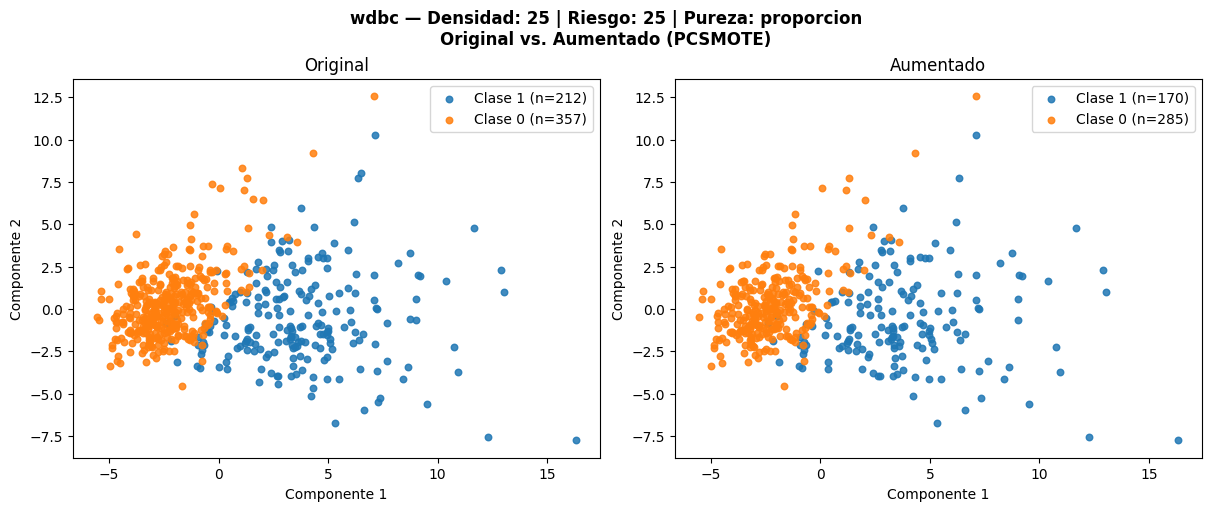

💾 Guardando datasets aumentados...
✅ Datasets guardados:
- Train aumentado: ../datasets/datasets_aumentados/pcsmote_wdbc_D25_R25_Pproporcion_train.csv
- Test escalado: ../datasets/datasets_aumentados/pcsmote_wdbc_D25_R25_Pproporcion_test.csv
✅ Guardado exitoso:
 - Train: ../datasets/datasets_aumentados/pcsmote_wdbc_D25_R25_Pproporcion_train.csv
 - Test: ../datasets/datasets_aumentados/pcsmote_wdbc_D25_R25_Pproporcion_test.csv
📁 Log por clase guardado en: ../datasets/datasets_aumentados/logs/pcsmote/por_clase/log_pcsmote_wdbc_D25_R25_Pproporcion.csv
📘 Log por muestra guardado en: ../datasets/datasets_aumentados/logs/pcsmote/por_muestras/log_pcsmote_x_muestra_wdbc_D25_R25_Pproporcion.xlsx
📄 Log exportado: ../datasets/datasets_aumentados/logs/pcsmote/por_clase/log_pcsmote_wdbc_D25_R25_Pproporcion.csv
📄 Log exportado: ../datasets/datasets_aumentados/logs/pcsmote/por_muestras/log_pcsmote_x_muestra_wdbc_D25_R25_Pproporcion.xlsx
#03 ➕ Aumentando con D=25 | R=50 | P=entropia
📂 Cargando dataset

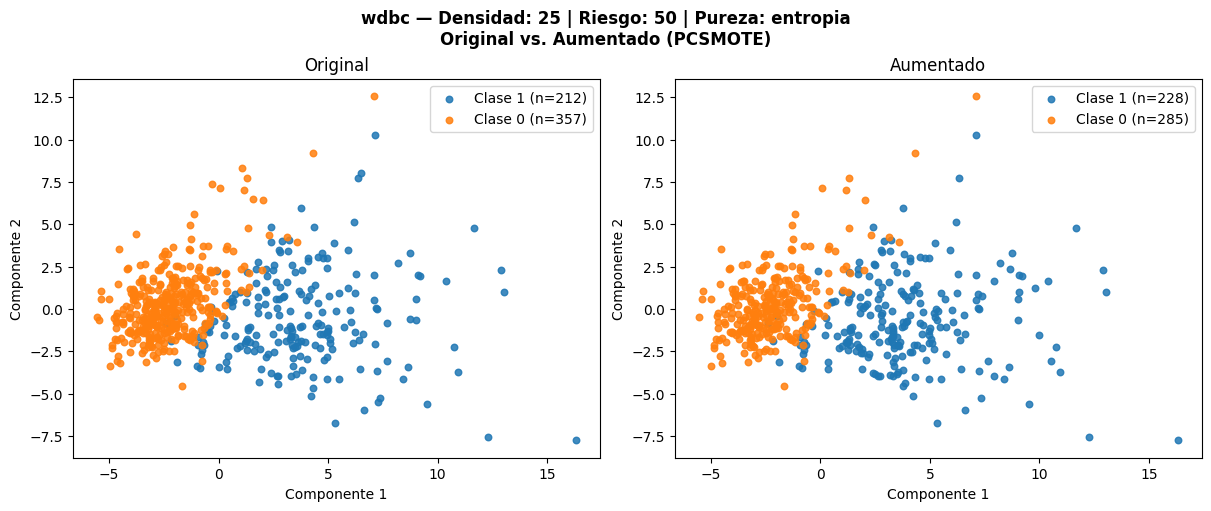

💾 Guardando datasets aumentados...
✅ Datasets guardados:
- Train aumentado: ../datasets/datasets_aumentados/pcsmote_wdbc_D25_R50_Pentropia_train.csv
- Test escalado: ../datasets/datasets_aumentados/pcsmote_wdbc_D25_R50_Pentropia_test.csv
✅ Guardado exitoso:
 - Train: ../datasets/datasets_aumentados/pcsmote_wdbc_D25_R50_Pentropia_train.csv
 - Test: ../datasets/datasets_aumentados/pcsmote_wdbc_D25_R50_Pentropia_test.csv
📁 Log por clase guardado en: ../datasets/datasets_aumentados/logs/pcsmote/por_clase/log_pcsmote_wdbc_D25_R50_Pentropia.csv
📘 Log por muestra guardado en: ../datasets/datasets_aumentados/logs/pcsmote/por_muestras/log_pcsmote_x_muestra_wdbc_D25_R50_Pentropia.xlsx
📄 Log exportado: ../datasets/datasets_aumentados/logs/pcsmote/por_clase/log_pcsmote_wdbc_D25_R50_Pentropia.csv
📄 Log exportado: ../datasets/datasets_aumentados/logs/pcsmote/por_muestras/log_pcsmote_x_muestra_wdbc_D25_R50_Pentropia.xlsx
#04 ➕ Aumentando con D=25 | R=50 | P=proporcion
📂 Cargando dataset: wdbc
🧬 Aplic

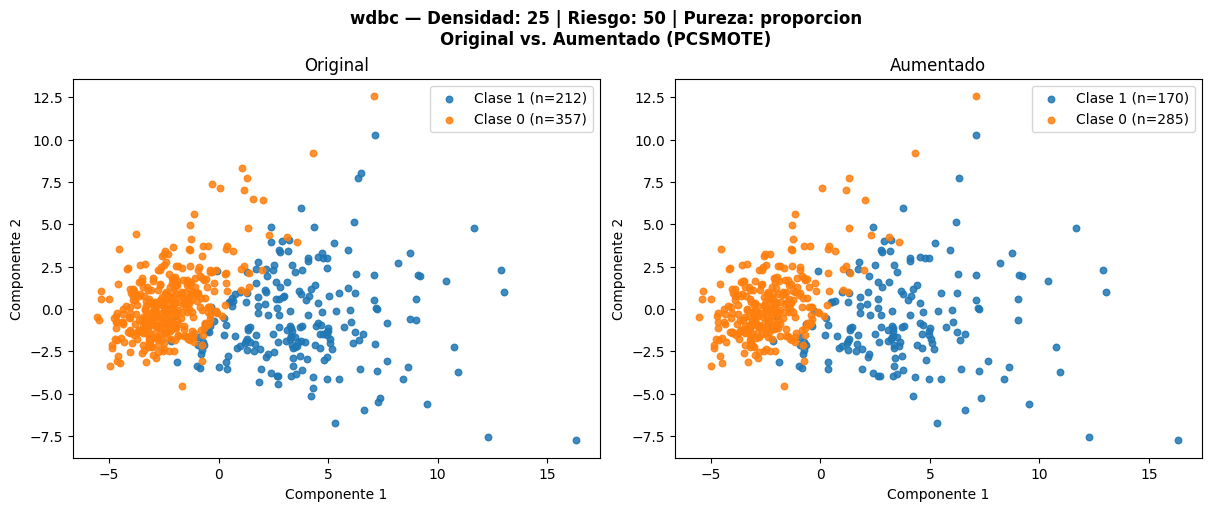

💾 Guardando datasets aumentados...
✅ Datasets guardados:
- Train aumentado: ../datasets/datasets_aumentados/pcsmote_wdbc_D25_R50_Pproporcion_train.csv
- Test escalado: ../datasets/datasets_aumentados/pcsmote_wdbc_D25_R50_Pproporcion_test.csv
✅ Guardado exitoso:
 - Train: ../datasets/datasets_aumentados/pcsmote_wdbc_D25_R50_Pproporcion_train.csv
 - Test: ../datasets/datasets_aumentados/pcsmote_wdbc_D25_R50_Pproporcion_test.csv
📁 Log por clase guardado en: ../datasets/datasets_aumentados/logs/pcsmote/por_clase/log_pcsmote_wdbc_D25_R50_Pproporcion.csv
📘 Log por muestra guardado en: ../datasets/datasets_aumentados/logs/pcsmote/por_muestras/log_pcsmote_x_muestra_wdbc_D25_R50_Pproporcion.xlsx
📄 Log exportado: ../datasets/datasets_aumentados/logs/pcsmote/por_clase/log_pcsmote_wdbc_D25_R50_Pproporcion.csv
📄 Log exportado: ../datasets/datasets_aumentados/logs/pcsmote/por_muestras/log_pcsmote_x_muestra_wdbc_D25_R50_Pproporcion.xlsx
#05 ➕ Aumentando con D=25 | R=75 | P=entropia
📂 Cargando dataset

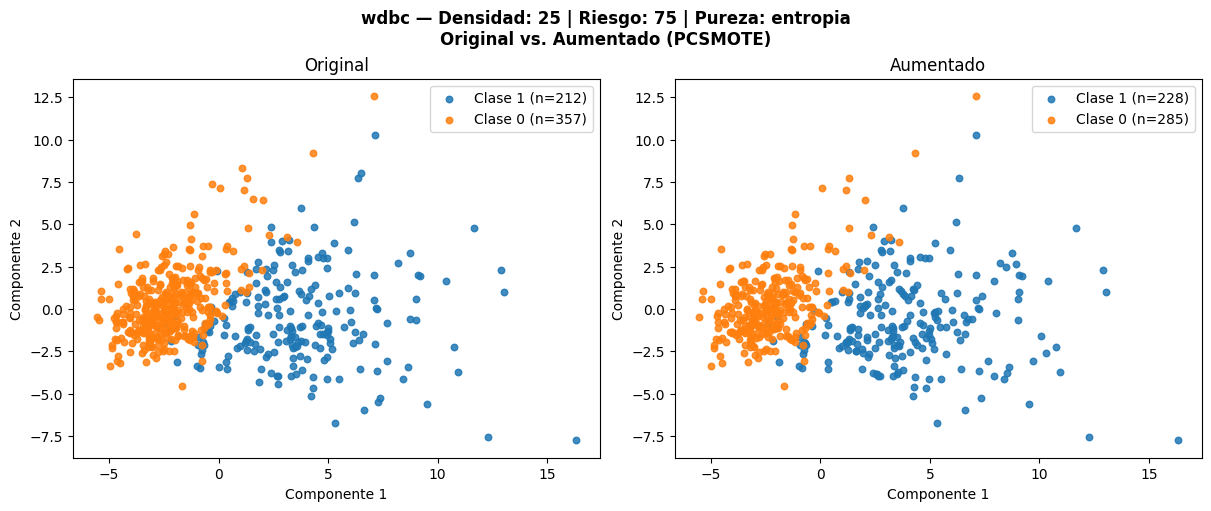

💾 Guardando datasets aumentados...
✅ Datasets guardados:
- Train aumentado: ../datasets/datasets_aumentados/pcsmote_wdbc_D25_R75_Pentropia_train.csv
- Test escalado: ../datasets/datasets_aumentados/pcsmote_wdbc_D25_R75_Pentropia_test.csv
✅ Guardado exitoso:
 - Train: ../datasets/datasets_aumentados/pcsmote_wdbc_D25_R75_Pentropia_train.csv
 - Test: ../datasets/datasets_aumentados/pcsmote_wdbc_D25_R75_Pentropia_test.csv
📁 Log por clase guardado en: ../datasets/datasets_aumentados/logs/pcsmote/por_clase/log_pcsmote_wdbc_D25_R75_Pentropia.csv
📘 Log por muestra guardado en: ../datasets/datasets_aumentados/logs/pcsmote/por_muestras/log_pcsmote_x_muestra_wdbc_D25_R75_Pentropia.xlsx
📄 Log exportado: ../datasets/datasets_aumentados/logs/pcsmote/por_clase/log_pcsmote_wdbc_D25_R75_Pentropia.csv
📄 Log exportado: ../datasets/datasets_aumentados/logs/pcsmote/por_muestras/log_pcsmote_x_muestra_wdbc_D25_R75_Pentropia.xlsx
#06 ➕ Aumentando con D=25 | R=75 | P=proporcion
📂 Cargando dataset: wdbc
🧬 Aplic

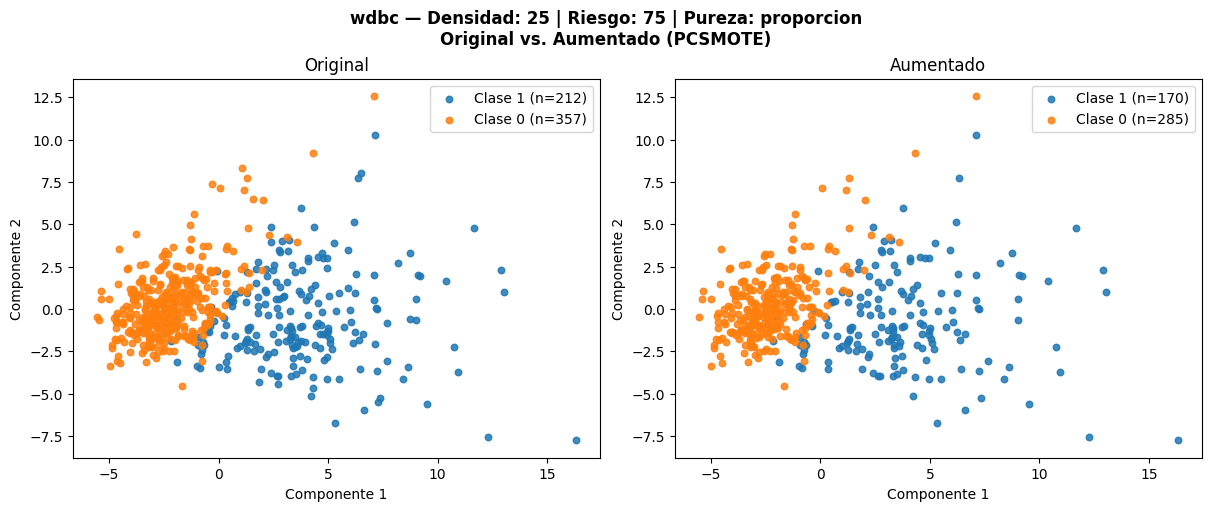

💾 Guardando datasets aumentados...
✅ Datasets guardados:
- Train aumentado: ../datasets/datasets_aumentados/pcsmote_wdbc_D25_R75_Pproporcion_train.csv
- Test escalado: ../datasets/datasets_aumentados/pcsmote_wdbc_D25_R75_Pproporcion_test.csv
✅ Guardado exitoso:
 - Train: ../datasets/datasets_aumentados/pcsmote_wdbc_D25_R75_Pproporcion_train.csv
 - Test: ../datasets/datasets_aumentados/pcsmote_wdbc_D25_R75_Pproporcion_test.csv
📁 Log por clase guardado en: ../datasets/datasets_aumentados/logs/pcsmote/por_clase/log_pcsmote_wdbc_D25_R75_Pproporcion.csv
📘 Log por muestra guardado en: ../datasets/datasets_aumentados/logs/pcsmote/por_muestras/log_pcsmote_x_muestra_wdbc_D25_R75_Pproporcion.xlsx
📄 Log exportado: ../datasets/datasets_aumentados/logs/pcsmote/por_clase/log_pcsmote_wdbc_D25_R75_Pproporcion.csv
📄 Log exportado: ../datasets/datasets_aumentados/logs/pcsmote/por_muestras/log_pcsmote_x_muestra_wdbc_D25_R75_Pproporcion.xlsx
#07 ➕ Aumentando con D=50 | R=25 | P=entropia
📂 Cargando dataset

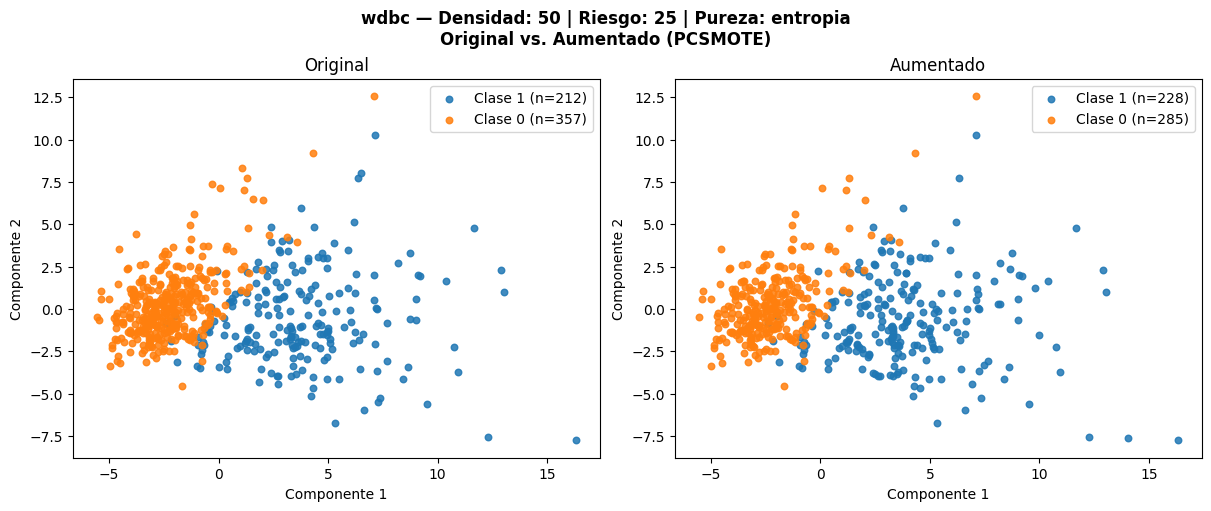

💾 Guardando datasets aumentados...
✅ Datasets guardados:
- Train aumentado: ../datasets/datasets_aumentados/pcsmote_wdbc_D50_R25_Pentropia_train.csv
- Test escalado: ../datasets/datasets_aumentados/pcsmote_wdbc_D50_R25_Pentropia_test.csv
✅ Guardado exitoso:
 - Train: ../datasets/datasets_aumentados/pcsmote_wdbc_D50_R25_Pentropia_train.csv
 - Test: ../datasets/datasets_aumentados/pcsmote_wdbc_D50_R25_Pentropia_test.csv
📁 Log por clase guardado en: ../datasets/datasets_aumentados/logs/pcsmote/por_clase/log_pcsmote_wdbc_D50_R25_Pentropia.csv
📘 Log por muestra guardado en: ../datasets/datasets_aumentados/logs/pcsmote/por_muestras/log_pcsmote_x_muestra_wdbc_D50_R25_Pentropia.xlsx
📄 Log exportado: ../datasets/datasets_aumentados/logs/pcsmote/por_clase/log_pcsmote_wdbc_D50_R25_Pentropia.csv
📄 Log exportado: ../datasets/datasets_aumentados/logs/pcsmote/por_muestras/log_pcsmote_x_muestra_wdbc_D50_R25_Pentropia.xlsx
#08 ➕ Aumentando con D=50 | R=25 | P=proporcion
📂 Cargando dataset: wdbc
🧬 Aplic

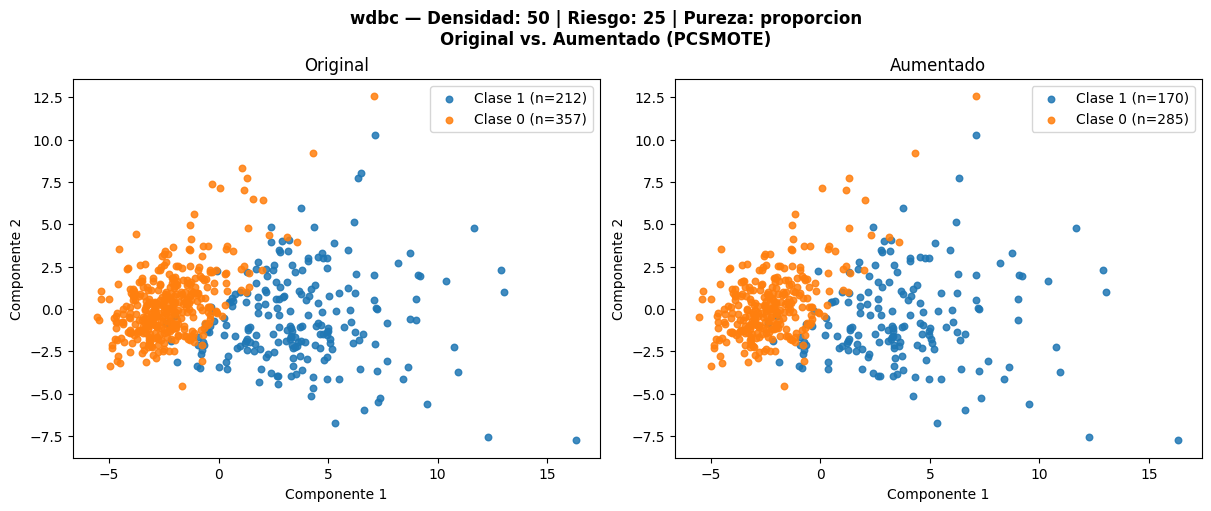

💾 Guardando datasets aumentados...
✅ Datasets guardados:
- Train aumentado: ../datasets/datasets_aumentados/pcsmote_wdbc_D50_R25_Pproporcion_train.csv
- Test escalado: ../datasets/datasets_aumentados/pcsmote_wdbc_D50_R25_Pproporcion_test.csv
✅ Guardado exitoso:
 - Train: ../datasets/datasets_aumentados/pcsmote_wdbc_D50_R25_Pproporcion_train.csv
 - Test: ../datasets/datasets_aumentados/pcsmote_wdbc_D50_R25_Pproporcion_test.csv
📁 Log por clase guardado en: ../datasets/datasets_aumentados/logs/pcsmote/por_clase/log_pcsmote_wdbc_D50_R25_Pproporcion.csv
📘 Log por muestra guardado en: ../datasets/datasets_aumentados/logs/pcsmote/por_muestras/log_pcsmote_x_muestra_wdbc_D50_R25_Pproporcion.xlsx
📄 Log exportado: ../datasets/datasets_aumentados/logs/pcsmote/por_clase/log_pcsmote_wdbc_D50_R25_Pproporcion.csv
📄 Log exportado: ../datasets/datasets_aumentados/logs/pcsmote/por_muestras/log_pcsmote_x_muestra_wdbc_D50_R25_Pproporcion.xlsx
#09 ➕ Aumentando con D=50 | R=50 | P=entropia
📂 Cargando dataset

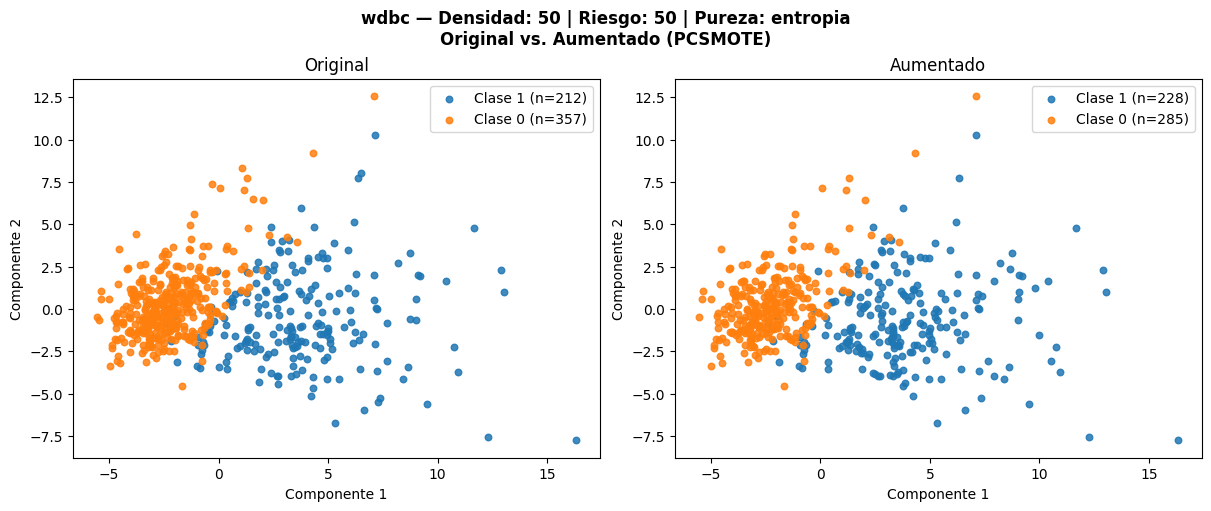

💾 Guardando datasets aumentados...
✅ Datasets guardados:
- Train aumentado: ../datasets/datasets_aumentados/pcsmote_wdbc_D50_R50_Pentropia_train.csv
- Test escalado: ../datasets/datasets_aumentados/pcsmote_wdbc_D50_R50_Pentropia_test.csv
✅ Guardado exitoso:
 - Train: ../datasets/datasets_aumentados/pcsmote_wdbc_D50_R50_Pentropia_train.csv
 - Test: ../datasets/datasets_aumentados/pcsmote_wdbc_D50_R50_Pentropia_test.csv
📁 Log por clase guardado en: ../datasets/datasets_aumentados/logs/pcsmote/por_clase/log_pcsmote_wdbc_D50_R50_Pentropia.csv
📘 Log por muestra guardado en: ../datasets/datasets_aumentados/logs/pcsmote/por_muestras/log_pcsmote_x_muestra_wdbc_D50_R50_Pentropia.xlsx
📄 Log exportado: ../datasets/datasets_aumentados/logs/pcsmote/por_clase/log_pcsmote_wdbc_D50_R50_Pentropia.csv
📄 Log exportado: ../datasets/datasets_aumentados/logs/pcsmote/por_muestras/log_pcsmote_x_muestra_wdbc_D50_R50_Pentropia.xlsx
#10 ➕ Aumentando con D=50 | R=50 | P=proporcion
📂 Cargando dataset: wdbc
🧬 Aplic

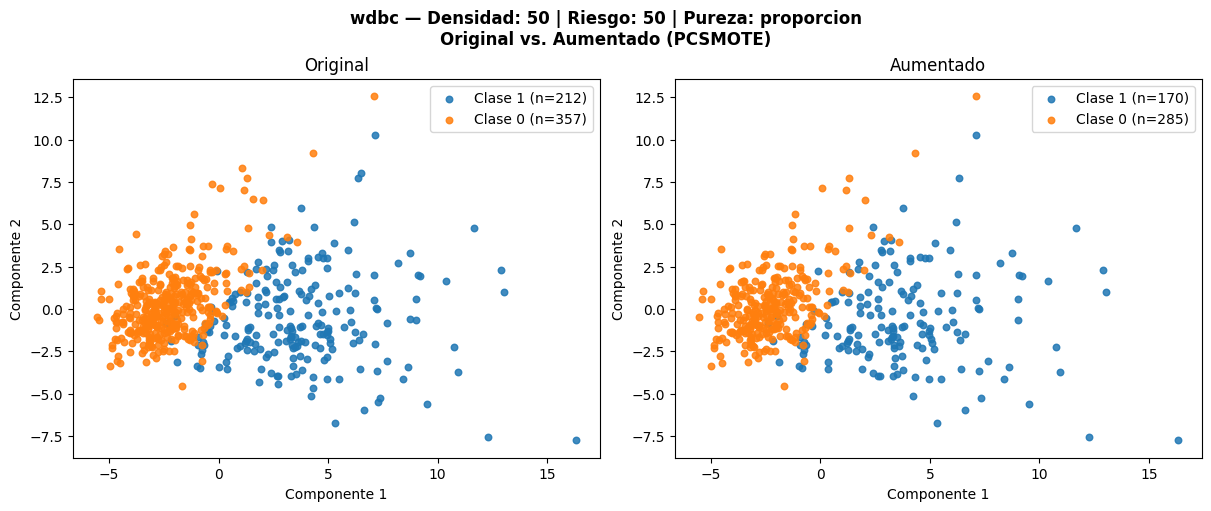

💾 Guardando datasets aumentados...
✅ Datasets guardados:
- Train aumentado: ../datasets/datasets_aumentados/pcsmote_wdbc_D50_R50_Pproporcion_train.csv
- Test escalado: ../datasets/datasets_aumentados/pcsmote_wdbc_D50_R50_Pproporcion_test.csv
✅ Guardado exitoso:
 - Train: ../datasets/datasets_aumentados/pcsmote_wdbc_D50_R50_Pproporcion_train.csv
 - Test: ../datasets/datasets_aumentados/pcsmote_wdbc_D50_R50_Pproporcion_test.csv
📁 Log por clase guardado en: ../datasets/datasets_aumentados/logs/pcsmote/por_clase/log_pcsmote_wdbc_D50_R50_Pproporcion.csv
📘 Log por muestra guardado en: ../datasets/datasets_aumentados/logs/pcsmote/por_muestras/log_pcsmote_x_muestra_wdbc_D50_R50_Pproporcion.xlsx
📄 Log exportado: ../datasets/datasets_aumentados/logs/pcsmote/por_clase/log_pcsmote_wdbc_D50_R50_Pproporcion.csv
📄 Log exportado: ../datasets/datasets_aumentados/logs/pcsmote/por_muestras/log_pcsmote_x_muestra_wdbc_D50_R50_Pproporcion.xlsx
#11 ➕ Aumentando con D=50 | R=75 | P=entropia
📂 Cargando dataset

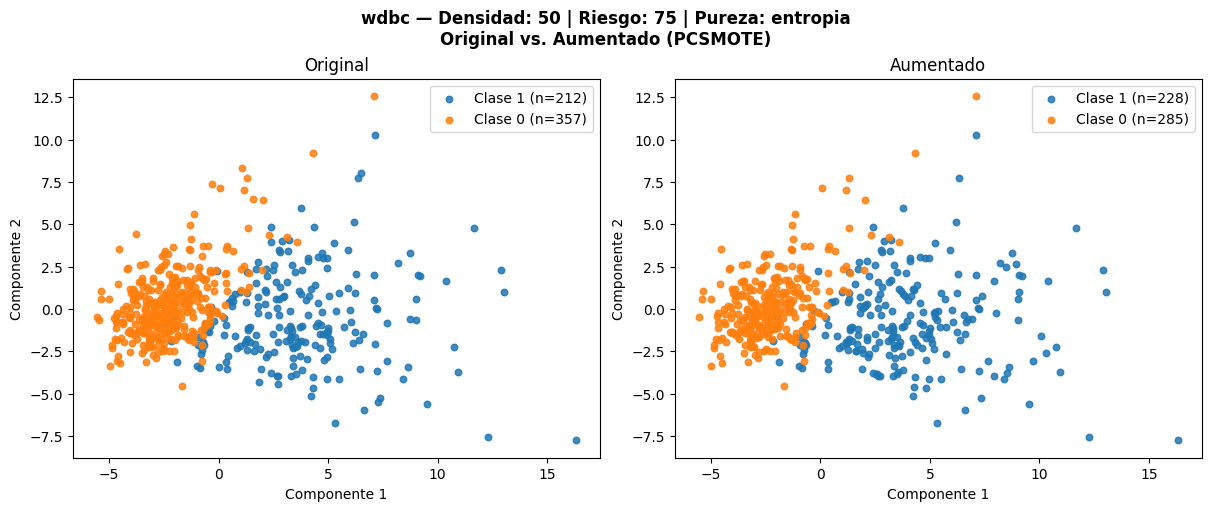

💾 Guardando datasets aumentados...
✅ Datasets guardados:
- Train aumentado: ../datasets/datasets_aumentados/pcsmote_wdbc_D50_R75_Pentropia_train.csv
- Test escalado: ../datasets/datasets_aumentados/pcsmote_wdbc_D50_R75_Pentropia_test.csv
✅ Guardado exitoso:
 - Train: ../datasets/datasets_aumentados/pcsmote_wdbc_D50_R75_Pentropia_train.csv
 - Test: ../datasets/datasets_aumentados/pcsmote_wdbc_D50_R75_Pentropia_test.csv
📁 Log por clase guardado en: ../datasets/datasets_aumentados/logs/pcsmote/por_clase/log_pcsmote_wdbc_D50_R75_Pentropia.csv
📘 Log por muestra guardado en: ../datasets/datasets_aumentados/logs/pcsmote/por_muestras/log_pcsmote_x_muestra_wdbc_D50_R75_Pentropia.xlsx
📄 Log exportado: ../datasets/datasets_aumentados/logs/pcsmote/por_clase/log_pcsmote_wdbc_D50_R75_Pentropia.csv
📄 Log exportado: ../datasets/datasets_aumentados/logs/pcsmote/por_muestras/log_pcsmote_x_muestra_wdbc_D50_R75_Pentropia.xlsx
#12 ➕ Aumentando con D=50 | R=75 | P=proporcion
📂 Cargando dataset: wdbc
🧬 Aplic

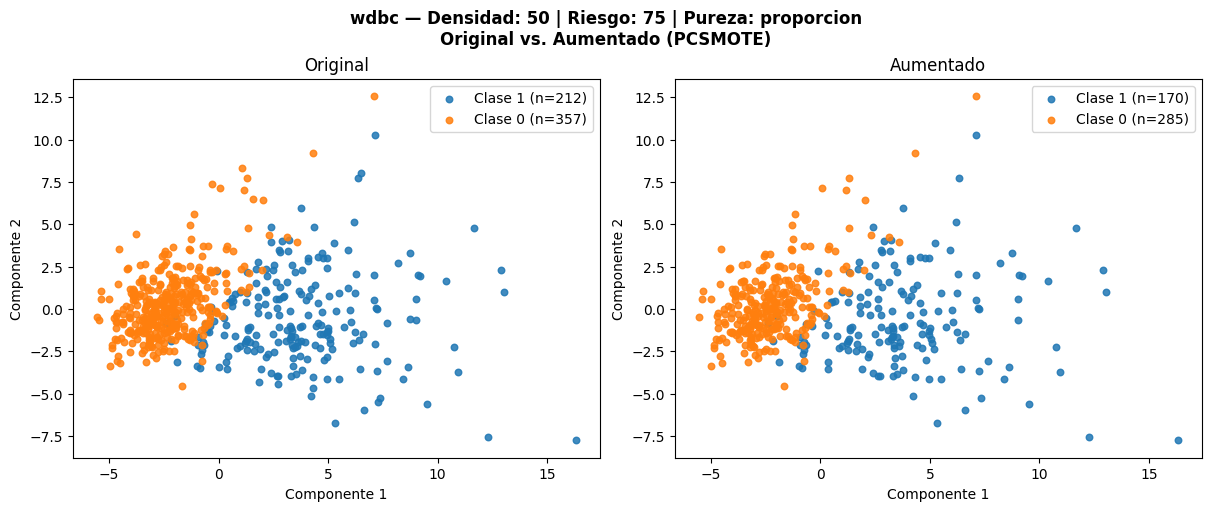

💾 Guardando datasets aumentados...
✅ Datasets guardados:
- Train aumentado: ../datasets/datasets_aumentados/pcsmote_wdbc_D50_R75_Pproporcion_train.csv
- Test escalado: ../datasets/datasets_aumentados/pcsmote_wdbc_D50_R75_Pproporcion_test.csv
✅ Guardado exitoso:
 - Train: ../datasets/datasets_aumentados/pcsmote_wdbc_D50_R75_Pproporcion_train.csv
 - Test: ../datasets/datasets_aumentados/pcsmote_wdbc_D50_R75_Pproporcion_test.csv
📁 Log por clase guardado en: ../datasets/datasets_aumentados/logs/pcsmote/por_clase/log_pcsmote_wdbc_D50_R75_Pproporcion.csv
📘 Log por muestra guardado en: ../datasets/datasets_aumentados/logs/pcsmote/por_muestras/log_pcsmote_x_muestra_wdbc_D50_R75_Pproporcion.xlsx
📄 Log exportado: ../datasets/datasets_aumentados/logs/pcsmote/por_clase/log_pcsmote_wdbc_D50_R75_Pproporcion.csv
📄 Log exportado: ../datasets/datasets_aumentados/logs/pcsmote/por_muestras/log_pcsmote_x_muestra_wdbc_D50_R75_Pproporcion.xlsx
#13 ➕ Aumentando con D=75 | R=25 | P=entropia
📂 Cargando dataset

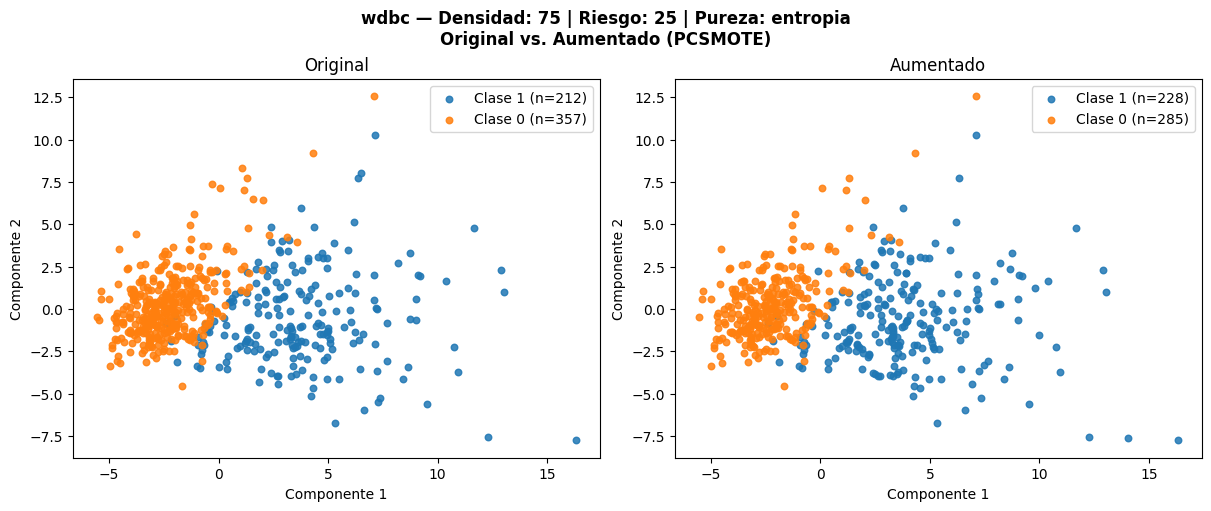

💾 Guardando datasets aumentados...
✅ Datasets guardados:
- Train aumentado: ../datasets/datasets_aumentados/pcsmote_wdbc_D75_R25_Pentropia_train.csv
- Test escalado: ../datasets/datasets_aumentados/pcsmote_wdbc_D75_R25_Pentropia_test.csv
✅ Guardado exitoso:
 - Train: ../datasets/datasets_aumentados/pcsmote_wdbc_D75_R25_Pentropia_train.csv
 - Test: ../datasets/datasets_aumentados/pcsmote_wdbc_D75_R25_Pentropia_test.csv
📁 Log por clase guardado en: ../datasets/datasets_aumentados/logs/pcsmote/por_clase/log_pcsmote_wdbc_D75_R25_Pentropia.csv
📘 Log por muestra guardado en: ../datasets/datasets_aumentados/logs/pcsmote/por_muestras/log_pcsmote_x_muestra_wdbc_D75_R25_Pentropia.xlsx
📄 Log exportado: ../datasets/datasets_aumentados/logs/pcsmote/por_clase/log_pcsmote_wdbc_D75_R25_Pentropia.csv
📄 Log exportado: ../datasets/datasets_aumentados/logs/pcsmote/por_muestras/log_pcsmote_x_muestra_wdbc_D75_R25_Pentropia.xlsx
#14 ➕ Aumentando con D=75 | R=25 | P=proporcion
📂 Cargando dataset: wdbc
🧬 Aplic

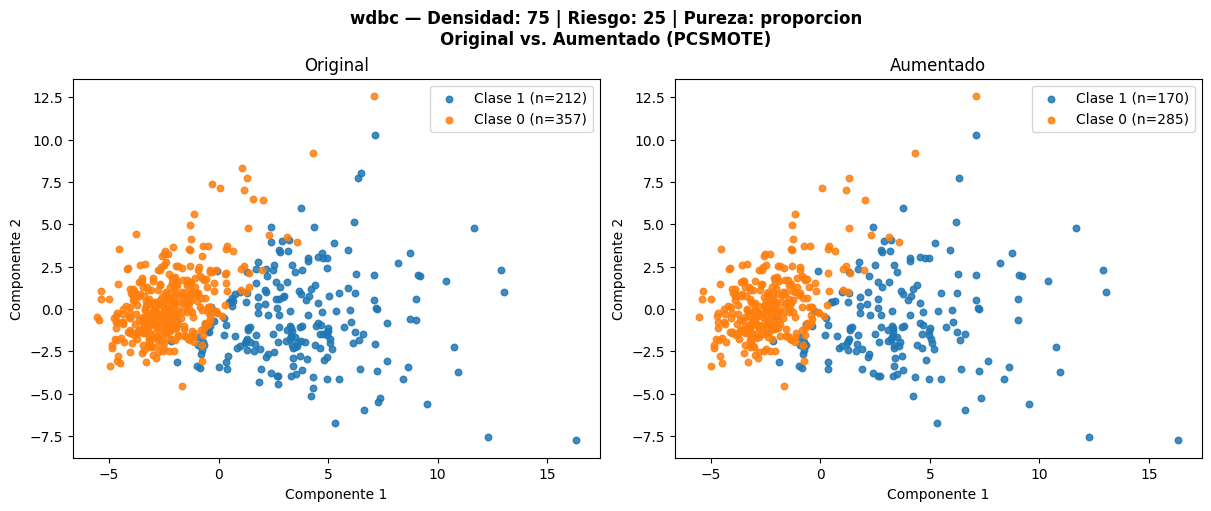

💾 Guardando datasets aumentados...
✅ Datasets guardados:
- Train aumentado: ../datasets/datasets_aumentados/pcsmote_wdbc_D75_R25_Pproporcion_train.csv
- Test escalado: ../datasets/datasets_aumentados/pcsmote_wdbc_D75_R25_Pproporcion_test.csv
✅ Guardado exitoso:
 - Train: ../datasets/datasets_aumentados/pcsmote_wdbc_D75_R25_Pproporcion_train.csv
 - Test: ../datasets/datasets_aumentados/pcsmote_wdbc_D75_R25_Pproporcion_test.csv
📁 Log por clase guardado en: ../datasets/datasets_aumentados/logs/pcsmote/por_clase/log_pcsmote_wdbc_D75_R25_Pproporcion.csv
📘 Log por muestra guardado en: ../datasets/datasets_aumentados/logs/pcsmote/por_muestras/log_pcsmote_x_muestra_wdbc_D75_R25_Pproporcion.xlsx
📄 Log exportado: ../datasets/datasets_aumentados/logs/pcsmote/por_clase/log_pcsmote_wdbc_D75_R25_Pproporcion.csv
📄 Log exportado: ../datasets/datasets_aumentados/logs/pcsmote/por_muestras/log_pcsmote_x_muestra_wdbc_D75_R25_Pproporcion.xlsx
#15 ➕ Aumentando con D=75 | R=50 | P=entropia
📂 Cargando dataset

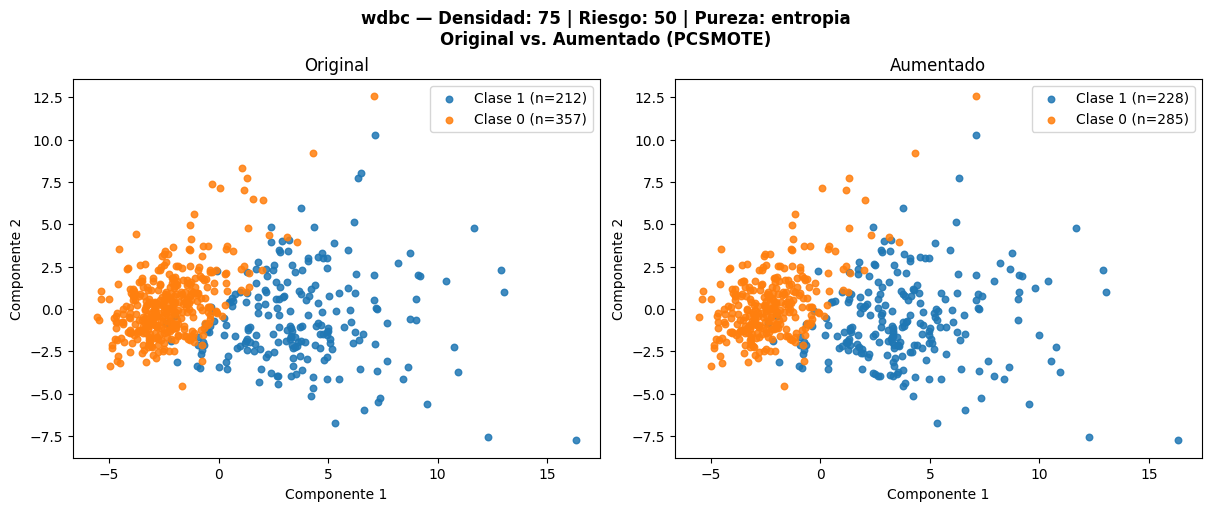

💾 Guardando datasets aumentados...
✅ Datasets guardados:
- Train aumentado: ../datasets/datasets_aumentados/pcsmote_wdbc_D75_R50_Pentropia_train.csv
- Test escalado: ../datasets/datasets_aumentados/pcsmote_wdbc_D75_R50_Pentropia_test.csv
✅ Guardado exitoso:
 - Train: ../datasets/datasets_aumentados/pcsmote_wdbc_D75_R50_Pentropia_train.csv
 - Test: ../datasets/datasets_aumentados/pcsmote_wdbc_D75_R50_Pentropia_test.csv
📁 Log por clase guardado en: ../datasets/datasets_aumentados/logs/pcsmote/por_clase/log_pcsmote_wdbc_D75_R50_Pentropia.csv
📘 Log por muestra guardado en: ../datasets/datasets_aumentados/logs/pcsmote/por_muestras/log_pcsmote_x_muestra_wdbc_D75_R50_Pentropia.xlsx
📄 Log exportado: ../datasets/datasets_aumentados/logs/pcsmote/por_clase/log_pcsmote_wdbc_D75_R50_Pentropia.csv
📄 Log exportado: ../datasets/datasets_aumentados/logs/pcsmote/por_muestras/log_pcsmote_x_muestra_wdbc_D75_R50_Pentropia.xlsx
#16 ➕ Aumentando con D=75 | R=50 | P=proporcion
📂 Cargando dataset: wdbc
🧬 Aplic

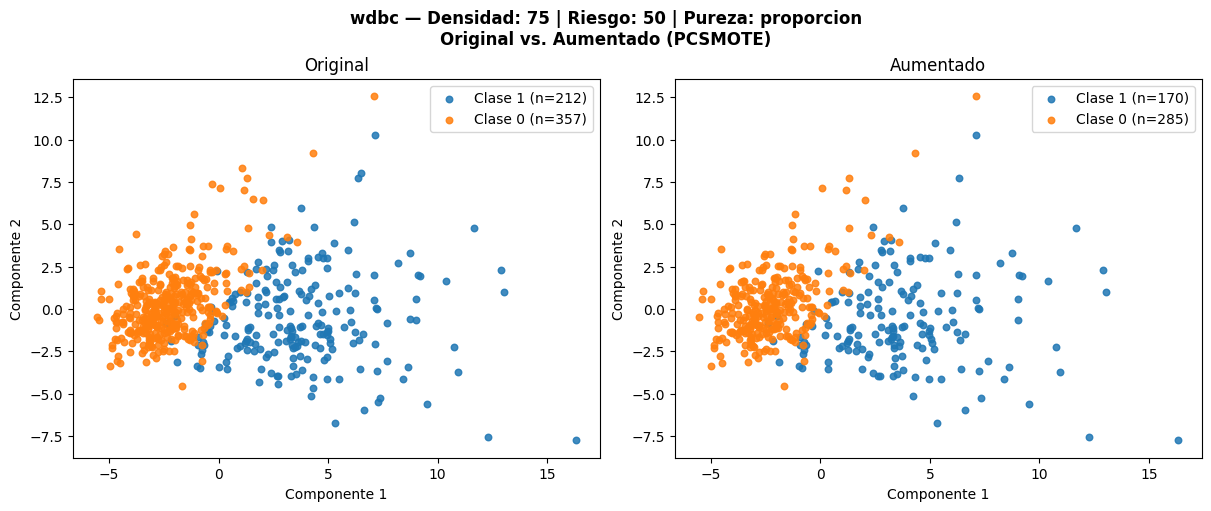

💾 Guardando datasets aumentados...
✅ Datasets guardados:
- Train aumentado: ../datasets/datasets_aumentados/pcsmote_wdbc_D75_R50_Pproporcion_train.csv
- Test escalado: ../datasets/datasets_aumentados/pcsmote_wdbc_D75_R50_Pproporcion_test.csv
✅ Guardado exitoso:
 - Train: ../datasets/datasets_aumentados/pcsmote_wdbc_D75_R50_Pproporcion_train.csv
 - Test: ../datasets/datasets_aumentados/pcsmote_wdbc_D75_R50_Pproporcion_test.csv
📁 Log por clase guardado en: ../datasets/datasets_aumentados/logs/pcsmote/por_clase/log_pcsmote_wdbc_D75_R50_Pproporcion.csv
📘 Log por muestra guardado en: ../datasets/datasets_aumentados/logs/pcsmote/por_muestras/log_pcsmote_x_muestra_wdbc_D75_R50_Pproporcion.xlsx
📄 Log exportado: ../datasets/datasets_aumentados/logs/pcsmote/por_clase/log_pcsmote_wdbc_D75_R50_Pproporcion.csv
📄 Log exportado: ../datasets/datasets_aumentados/logs/pcsmote/por_muestras/log_pcsmote_x_muestra_wdbc_D75_R50_Pproporcion.xlsx
#17 ➕ Aumentando con D=75 | R=75 | P=entropia
📂 Cargando dataset

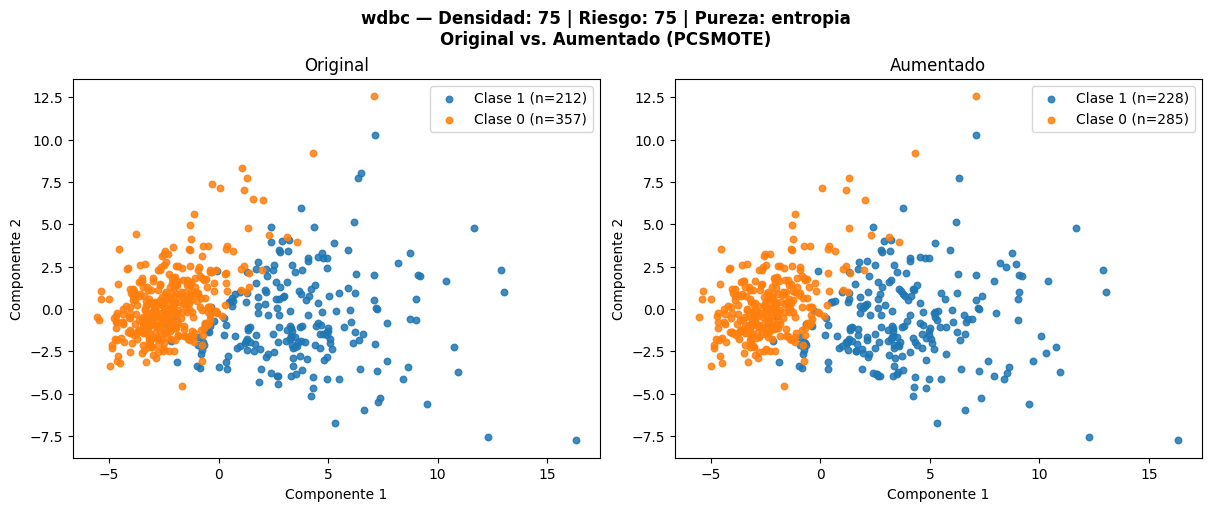

💾 Guardando datasets aumentados...
✅ Datasets guardados:
- Train aumentado: ../datasets/datasets_aumentados/pcsmote_wdbc_D75_R75_Pentropia_train.csv
- Test escalado: ../datasets/datasets_aumentados/pcsmote_wdbc_D75_R75_Pentropia_test.csv
✅ Guardado exitoso:
 - Train: ../datasets/datasets_aumentados/pcsmote_wdbc_D75_R75_Pentropia_train.csv
 - Test: ../datasets/datasets_aumentados/pcsmote_wdbc_D75_R75_Pentropia_test.csv
📁 Log por clase guardado en: ../datasets/datasets_aumentados/logs/pcsmote/por_clase/log_pcsmote_wdbc_D75_R75_Pentropia.csv
📘 Log por muestra guardado en: ../datasets/datasets_aumentados/logs/pcsmote/por_muestras/log_pcsmote_x_muestra_wdbc_D75_R75_Pentropia.xlsx
📄 Log exportado: ../datasets/datasets_aumentados/logs/pcsmote/por_clase/log_pcsmote_wdbc_D75_R75_Pentropia.csv
📄 Log exportado: ../datasets/datasets_aumentados/logs/pcsmote/por_muestras/log_pcsmote_x_muestra_wdbc_D75_R75_Pentropia.xlsx
#18 ➕ Aumentando con D=75 | R=75 | P=proporcion
📂 Cargando dataset: wdbc
🧬 Aplic

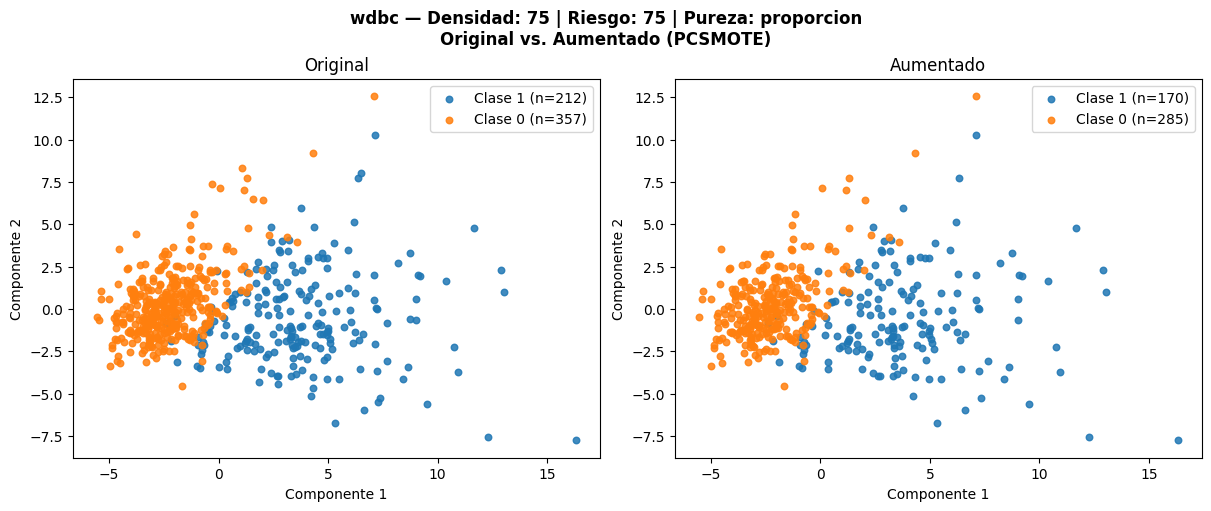

💾 Guardando datasets aumentados...
✅ Datasets guardados:
- Train aumentado: ../datasets/datasets_aumentados/pcsmote_wdbc_D75_R75_Pproporcion_train.csv
- Test escalado: ../datasets/datasets_aumentados/pcsmote_wdbc_D75_R75_Pproporcion_test.csv
✅ Guardado exitoso:
 - Train: ../datasets/datasets_aumentados/pcsmote_wdbc_D75_R75_Pproporcion_train.csv
 - Test: ../datasets/datasets_aumentados/pcsmote_wdbc_D75_R75_Pproporcion_test.csv
📁 Log por clase guardado en: ../datasets/datasets_aumentados/logs/pcsmote/por_clase/log_pcsmote_wdbc_D75_R75_Pproporcion.csv
📘 Log por muestra guardado en: ../datasets/datasets_aumentados/logs/pcsmote/por_muestras/log_pcsmote_x_muestra_wdbc_D75_R75_Pproporcion.xlsx
📄 Log exportado: ../datasets/datasets_aumentados/logs/pcsmote/por_clase/log_pcsmote_wdbc_D75_R75_Pproporcion.csv
📄 Log exportado: ../datasets/datasets_aumentados/logs/pcsmote/por_muestras/log_pcsmote_x_muestra_wdbc_D75_R75_Pproporcion.xlsx

📁 Dataset: glass
#01 ➕ Aumentando con D=25 | R=25 | P=entropia


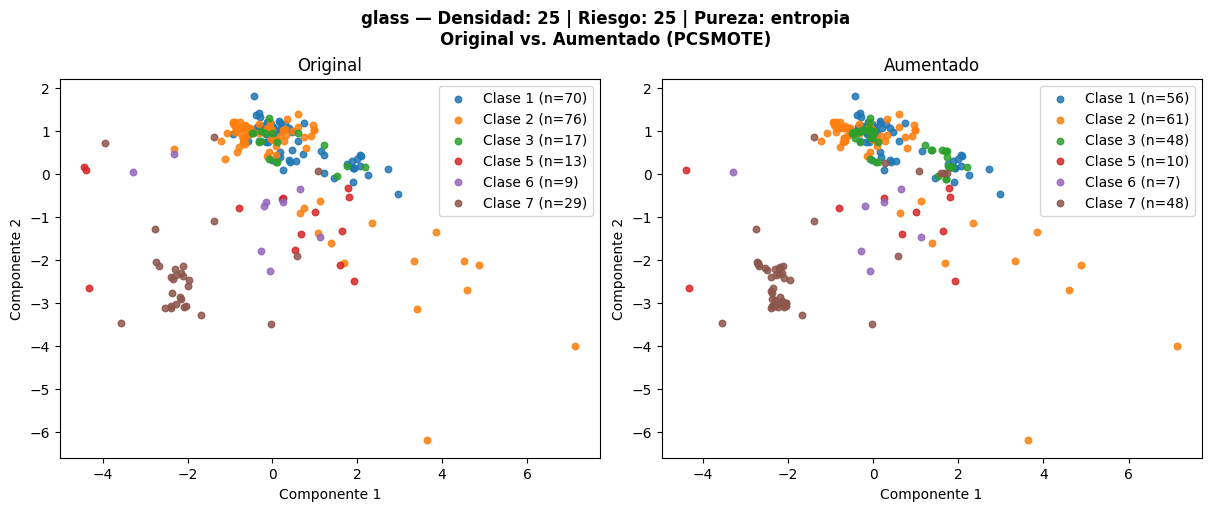

💾 Guardando datasets aumentados...
✅ Datasets guardados:
- Train aumentado: ../datasets/datasets_aumentados/pcsmote_glass_D25_R25_Pentropia_train.csv
- Test escalado: ../datasets/datasets_aumentados/pcsmote_glass_D25_R25_Pentropia_test.csv
✅ Guardado exitoso:
 - Train: ../datasets/datasets_aumentados/pcsmote_glass_D25_R25_Pentropia_train.csv
 - Test: ../datasets/datasets_aumentados/pcsmote_glass_D25_R25_Pentropia_test.csv
📁 Log por clase guardado en: ../datasets/datasets_aumentados/logs/pcsmote/por_clase/log_pcsmote_glass_D25_R25_Pentropia.csv
📘 Log por muestra guardado en: ../datasets/datasets_aumentados/logs/pcsmote/por_muestras/log_pcsmote_x_muestra_glass_D25_R25_Pentropia.xlsx
📄 Log exportado: ../datasets/datasets_aumentados/logs/pcsmote/por_clase/log_pcsmote_glass_D25_R25_Pentropia.csv
📄 Log exportado: ../datasets/datasets_aumentados/logs/pcsmote/por_muestras/log_pcsmote_x_muestra_glass_D25_R25_Pentropia.xlsx
#02 ➕ Aumentando con D=25 | R=25 | P=proporcion
📂 Cargando dataset: glas

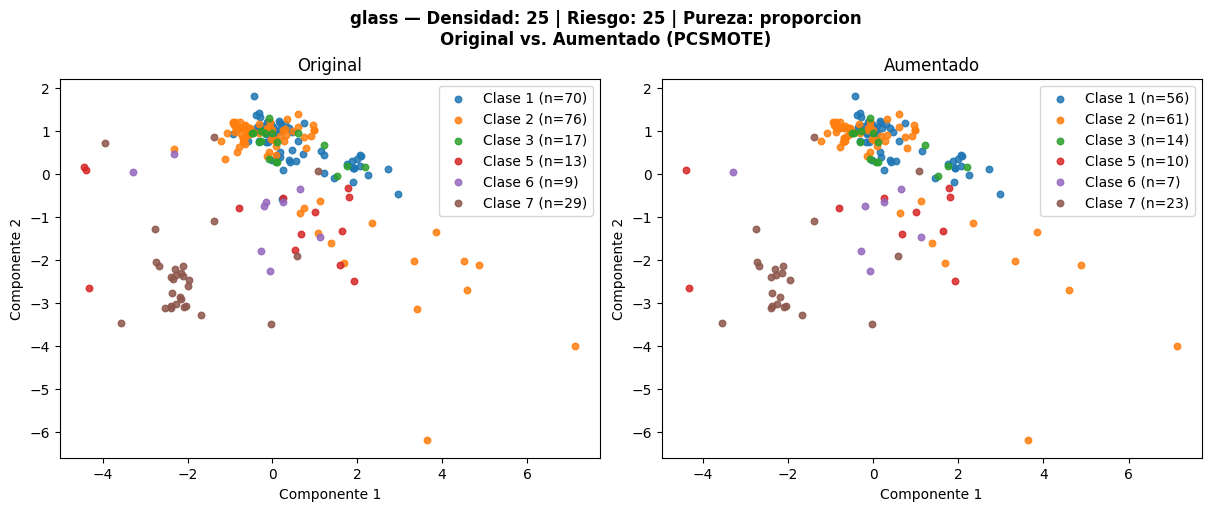

💾 Guardando datasets aumentados...
✅ Datasets guardados:
- Train aumentado: ../datasets/datasets_aumentados/pcsmote_glass_D25_R25_Pproporcion_train.csv
- Test escalado: ../datasets/datasets_aumentados/pcsmote_glass_D25_R25_Pproporcion_test.csv
✅ Guardado exitoso:
 - Train: ../datasets/datasets_aumentados/pcsmote_glass_D25_R25_Pproporcion_train.csv
 - Test: ../datasets/datasets_aumentados/pcsmote_glass_D25_R25_Pproporcion_test.csv
📁 Log por clase guardado en: ../datasets/datasets_aumentados/logs/pcsmote/por_clase/log_pcsmote_glass_D25_R25_Pproporcion.csv
📘 Log por muestra guardado en: ../datasets/datasets_aumentados/logs/pcsmote/por_muestras/log_pcsmote_x_muestra_glass_D25_R25_Pproporcion.xlsx
📄 Log exportado: ../datasets/datasets_aumentados/logs/pcsmote/por_clase/log_pcsmote_glass_D25_R25_Pproporcion.csv
📄 Log exportado: ../datasets/datasets_aumentados/logs/pcsmote/por_muestras/log_pcsmote_x_muestra_glass_D25_R25_Pproporcion.xlsx
#03 ➕ Aumentando con D=25 | R=50 | P=entropia
📂 Cargando

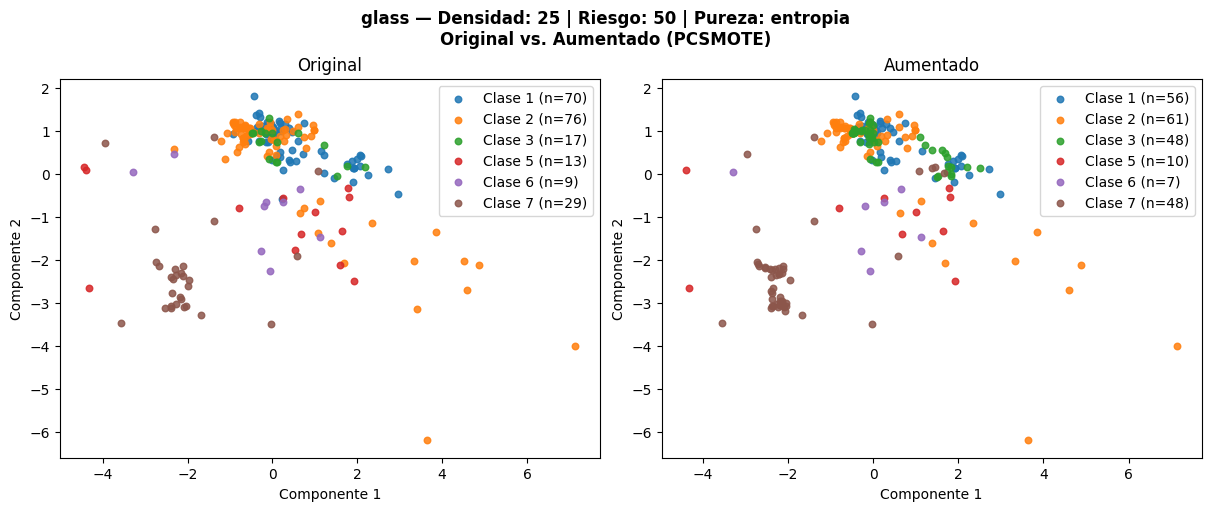

💾 Guardando datasets aumentados...
✅ Datasets guardados:
- Train aumentado: ../datasets/datasets_aumentados/pcsmote_glass_D25_R50_Pentropia_train.csv
- Test escalado: ../datasets/datasets_aumentados/pcsmote_glass_D25_R50_Pentropia_test.csv
✅ Guardado exitoso:
 - Train: ../datasets/datasets_aumentados/pcsmote_glass_D25_R50_Pentropia_train.csv
 - Test: ../datasets/datasets_aumentados/pcsmote_glass_D25_R50_Pentropia_test.csv
📁 Log por clase guardado en: ../datasets/datasets_aumentados/logs/pcsmote/por_clase/log_pcsmote_glass_D25_R50_Pentropia.csv
📘 Log por muestra guardado en: ../datasets/datasets_aumentados/logs/pcsmote/por_muestras/log_pcsmote_x_muestra_glass_D25_R50_Pentropia.xlsx
📄 Log exportado: ../datasets/datasets_aumentados/logs/pcsmote/por_clase/log_pcsmote_glass_D25_R50_Pentropia.csv
📄 Log exportado: ../datasets/datasets_aumentados/logs/pcsmote/por_muestras/log_pcsmote_x_muestra_glass_D25_R50_Pentropia.xlsx
#04 ➕ Aumentando con D=25 | R=50 | P=proporcion
📂 Cargando dataset: glas

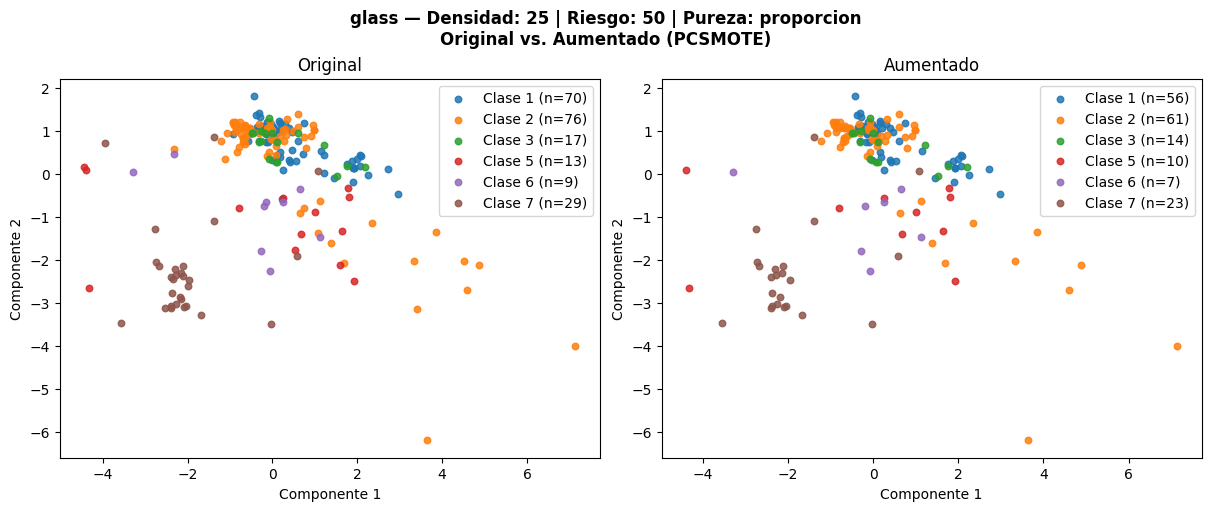

💾 Guardando datasets aumentados...
✅ Datasets guardados:
- Train aumentado: ../datasets/datasets_aumentados/pcsmote_glass_D25_R50_Pproporcion_train.csv
- Test escalado: ../datasets/datasets_aumentados/pcsmote_glass_D25_R50_Pproporcion_test.csv
✅ Guardado exitoso:
 - Train: ../datasets/datasets_aumentados/pcsmote_glass_D25_R50_Pproporcion_train.csv
 - Test: ../datasets/datasets_aumentados/pcsmote_glass_D25_R50_Pproporcion_test.csv
📁 Log por clase guardado en: ../datasets/datasets_aumentados/logs/pcsmote/por_clase/log_pcsmote_glass_D25_R50_Pproporcion.csv
📘 Log por muestra guardado en: ../datasets/datasets_aumentados/logs/pcsmote/por_muestras/log_pcsmote_x_muestra_glass_D25_R50_Pproporcion.xlsx
📄 Log exportado: ../datasets/datasets_aumentados/logs/pcsmote/por_clase/log_pcsmote_glass_D25_R50_Pproporcion.csv
📄 Log exportado: ../datasets/datasets_aumentados/logs/pcsmote/por_muestras/log_pcsmote_x_muestra_glass_D25_R50_Pproporcion.xlsx
#05 ➕ Aumentando con D=25 | R=75 | P=entropia
📂 Cargando

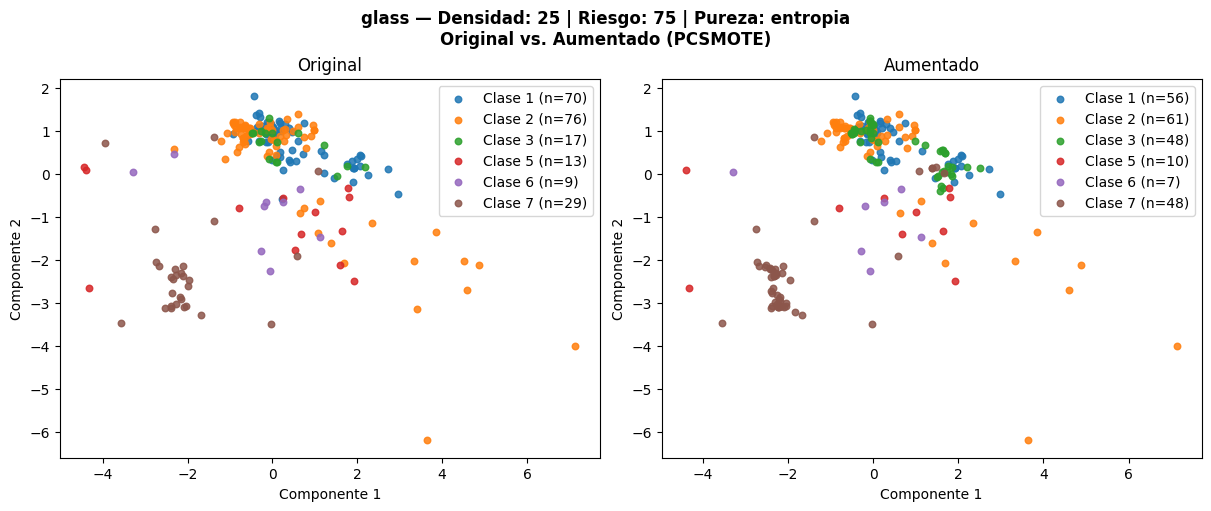

💾 Guardando datasets aumentados...
✅ Datasets guardados:
- Train aumentado: ../datasets/datasets_aumentados/pcsmote_glass_D25_R75_Pentropia_train.csv
- Test escalado: ../datasets/datasets_aumentados/pcsmote_glass_D25_R75_Pentropia_test.csv
✅ Guardado exitoso:
 - Train: ../datasets/datasets_aumentados/pcsmote_glass_D25_R75_Pentropia_train.csv
 - Test: ../datasets/datasets_aumentados/pcsmote_glass_D25_R75_Pentropia_test.csv
📁 Log por clase guardado en: ../datasets/datasets_aumentados/logs/pcsmote/por_clase/log_pcsmote_glass_D25_R75_Pentropia.csv
📘 Log por muestra guardado en: ../datasets/datasets_aumentados/logs/pcsmote/por_muestras/log_pcsmote_x_muestra_glass_D25_R75_Pentropia.xlsx
📄 Log exportado: ../datasets/datasets_aumentados/logs/pcsmote/por_clase/log_pcsmote_glass_D25_R75_Pentropia.csv
📄 Log exportado: ../datasets/datasets_aumentados/logs/pcsmote/por_muestras/log_pcsmote_x_muestra_glass_D25_R75_Pentropia.xlsx
#06 ➕ Aumentando con D=25 | R=75 | P=proporcion
📂 Cargando dataset: glas

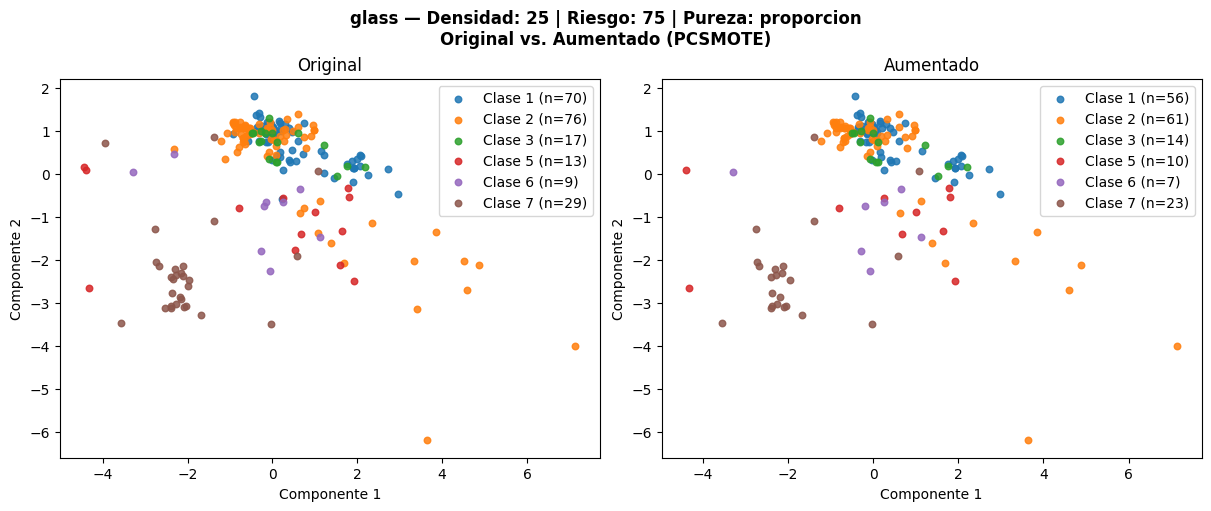

💾 Guardando datasets aumentados...
✅ Datasets guardados:
- Train aumentado: ../datasets/datasets_aumentados/pcsmote_glass_D25_R75_Pproporcion_train.csv
- Test escalado: ../datasets/datasets_aumentados/pcsmote_glass_D25_R75_Pproporcion_test.csv
✅ Guardado exitoso:
 - Train: ../datasets/datasets_aumentados/pcsmote_glass_D25_R75_Pproporcion_train.csv
 - Test: ../datasets/datasets_aumentados/pcsmote_glass_D25_R75_Pproporcion_test.csv
📁 Log por clase guardado en: ../datasets/datasets_aumentados/logs/pcsmote/por_clase/log_pcsmote_glass_D25_R75_Pproporcion.csv
📘 Log por muestra guardado en: ../datasets/datasets_aumentados/logs/pcsmote/por_muestras/log_pcsmote_x_muestra_glass_D25_R75_Pproporcion.xlsx
📄 Log exportado: ../datasets/datasets_aumentados/logs/pcsmote/por_clase/log_pcsmote_glass_D25_R75_Pproporcion.csv
📄 Log exportado: ../datasets/datasets_aumentados/logs/pcsmote/por_muestras/log_pcsmote_x_muestra_glass_D25_R75_Pproporcion.xlsx
#07 ➕ Aumentando con D=50 | R=25 | P=entropia
📂 Cargando

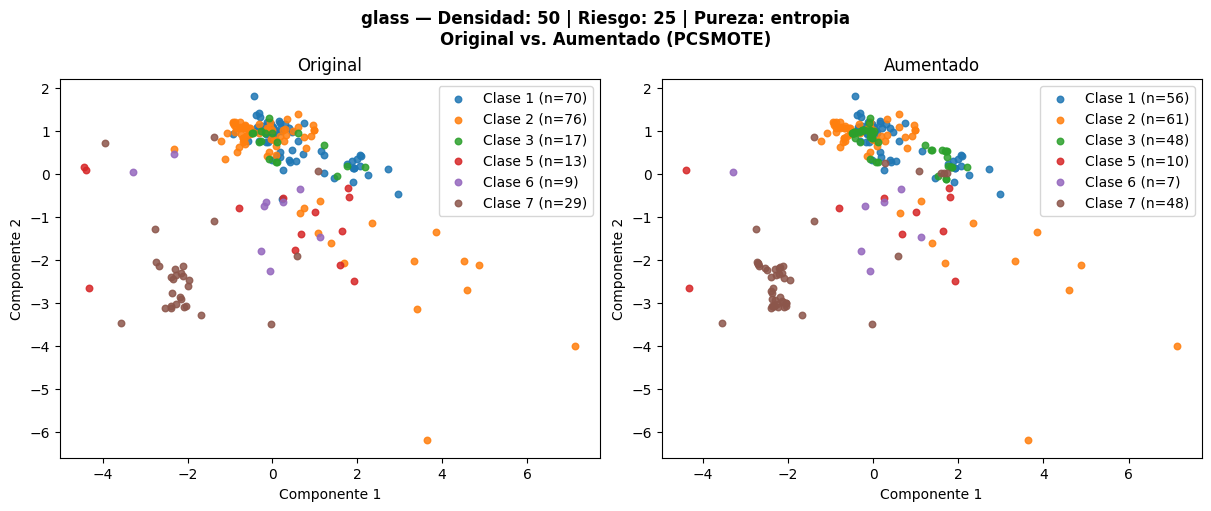

💾 Guardando datasets aumentados...
✅ Datasets guardados:
- Train aumentado: ../datasets/datasets_aumentados/pcsmote_glass_D50_R25_Pentropia_train.csv
- Test escalado: ../datasets/datasets_aumentados/pcsmote_glass_D50_R25_Pentropia_test.csv
✅ Guardado exitoso:
 - Train: ../datasets/datasets_aumentados/pcsmote_glass_D50_R25_Pentropia_train.csv
 - Test: ../datasets/datasets_aumentados/pcsmote_glass_D50_R25_Pentropia_test.csv
📁 Log por clase guardado en: ../datasets/datasets_aumentados/logs/pcsmote/por_clase/log_pcsmote_glass_D50_R25_Pentropia.csv
📘 Log por muestra guardado en: ../datasets/datasets_aumentados/logs/pcsmote/por_muestras/log_pcsmote_x_muestra_glass_D50_R25_Pentropia.xlsx
📄 Log exportado: ../datasets/datasets_aumentados/logs/pcsmote/por_clase/log_pcsmote_glass_D50_R25_Pentropia.csv
📄 Log exportado: ../datasets/datasets_aumentados/logs/pcsmote/por_muestras/log_pcsmote_x_muestra_glass_D50_R25_Pentropia.xlsx
#08 ➕ Aumentando con D=50 | R=25 | P=proporcion
📂 Cargando dataset: glas

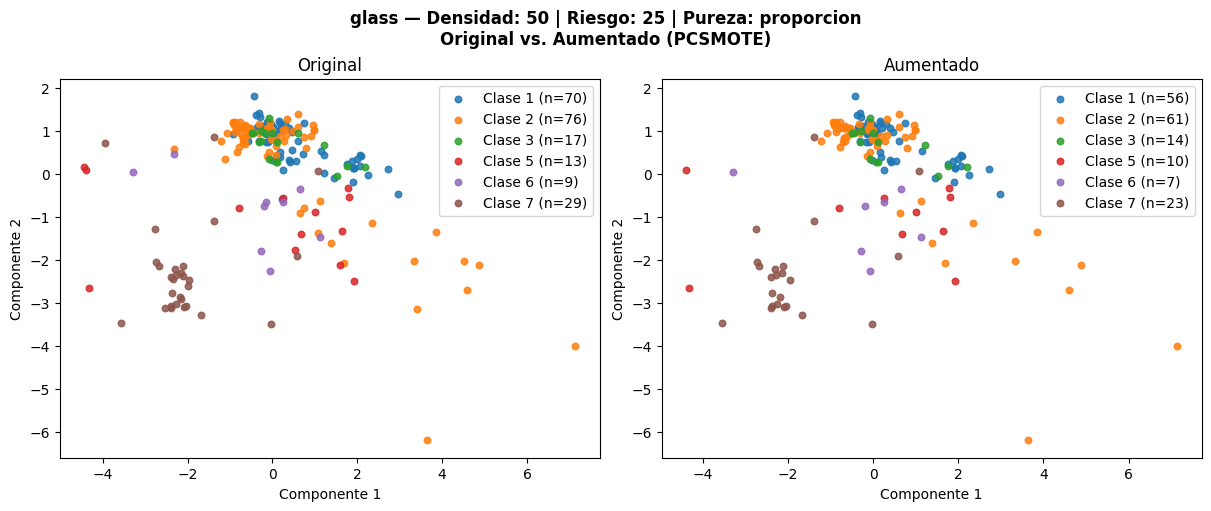

💾 Guardando datasets aumentados...
✅ Datasets guardados:
- Train aumentado: ../datasets/datasets_aumentados/pcsmote_glass_D50_R25_Pproporcion_train.csv
- Test escalado: ../datasets/datasets_aumentados/pcsmote_glass_D50_R25_Pproporcion_test.csv
✅ Guardado exitoso:
 - Train: ../datasets/datasets_aumentados/pcsmote_glass_D50_R25_Pproporcion_train.csv
 - Test: ../datasets/datasets_aumentados/pcsmote_glass_D50_R25_Pproporcion_test.csv
📁 Log por clase guardado en: ../datasets/datasets_aumentados/logs/pcsmote/por_clase/log_pcsmote_glass_D50_R25_Pproporcion.csv
📘 Log por muestra guardado en: ../datasets/datasets_aumentados/logs/pcsmote/por_muestras/log_pcsmote_x_muestra_glass_D50_R25_Pproporcion.xlsx
📄 Log exportado: ../datasets/datasets_aumentados/logs/pcsmote/por_clase/log_pcsmote_glass_D50_R25_Pproporcion.csv
📄 Log exportado: ../datasets/datasets_aumentados/logs/pcsmote/por_muestras/log_pcsmote_x_muestra_glass_D50_R25_Pproporcion.xlsx
#09 ➕ Aumentando con D=50 | R=50 | P=entropia
📂 Cargando

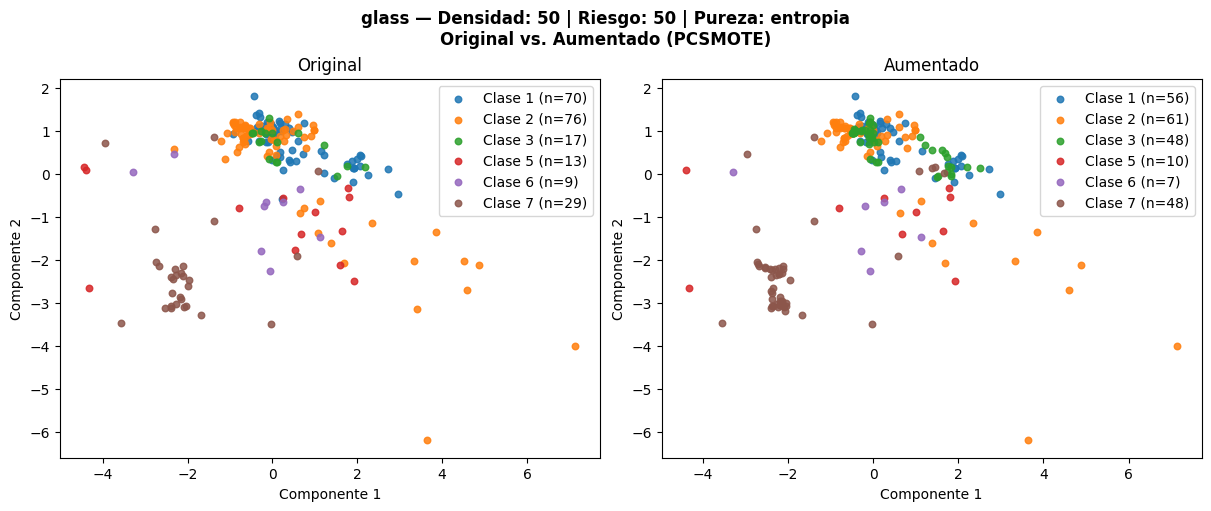

💾 Guardando datasets aumentados...
✅ Datasets guardados:
- Train aumentado: ../datasets/datasets_aumentados/pcsmote_glass_D50_R50_Pentropia_train.csv
- Test escalado: ../datasets/datasets_aumentados/pcsmote_glass_D50_R50_Pentropia_test.csv
✅ Guardado exitoso:
 - Train: ../datasets/datasets_aumentados/pcsmote_glass_D50_R50_Pentropia_train.csv
 - Test: ../datasets/datasets_aumentados/pcsmote_glass_D50_R50_Pentropia_test.csv
📁 Log por clase guardado en: ../datasets/datasets_aumentados/logs/pcsmote/por_clase/log_pcsmote_glass_D50_R50_Pentropia.csv
📘 Log por muestra guardado en: ../datasets/datasets_aumentados/logs/pcsmote/por_muestras/log_pcsmote_x_muestra_glass_D50_R50_Pentropia.xlsx
📄 Log exportado: ../datasets/datasets_aumentados/logs/pcsmote/por_clase/log_pcsmote_glass_D50_R50_Pentropia.csv
📄 Log exportado: ../datasets/datasets_aumentados/logs/pcsmote/por_muestras/log_pcsmote_x_muestra_glass_D50_R50_Pentropia.xlsx
#10 ➕ Aumentando con D=50 | R=50 | P=proporcion
📂 Cargando dataset: glas

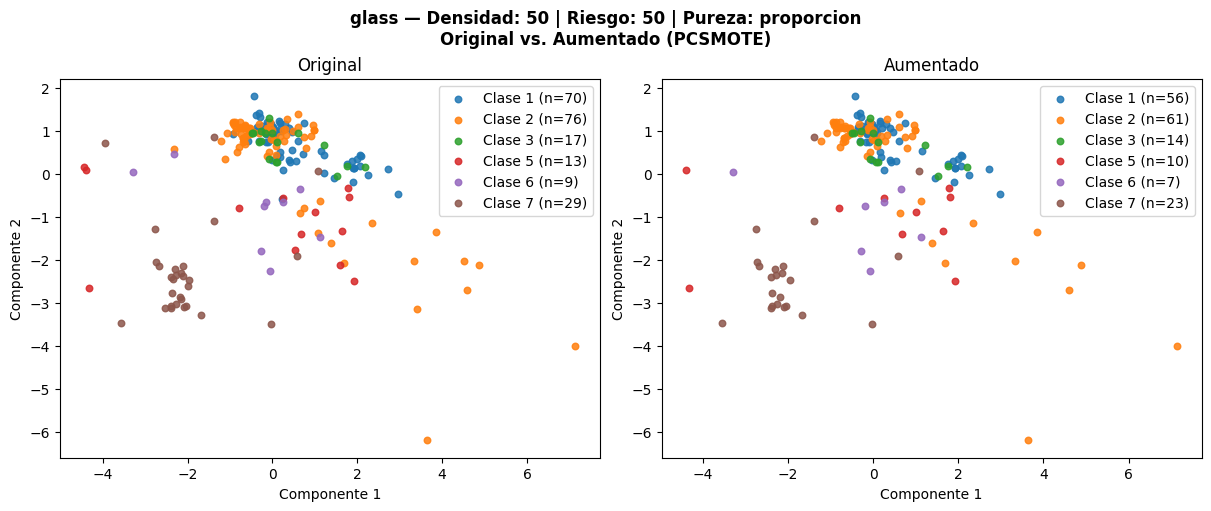

💾 Guardando datasets aumentados...
✅ Datasets guardados:
- Train aumentado: ../datasets/datasets_aumentados/pcsmote_glass_D50_R50_Pproporcion_train.csv
- Test escalado: ../datasets/datasets_aumentados/pcsmote_glass_D50_R50_Pproporcion_test.csv
✅ Guardado exitoso:
 - Train: ../datasets/datasets_aumentados/pcsmote_glass_D50_R50_Pproporcion_train.csv
 - Test: ../datasets/datasets_aumentados/pcsmote_glass_D50_R50_Pproporcion_test.csv
📁 Log por clase guardado en: ../datasets/datasets_aumentados/logs/pcsmote/por_clase/log_pcsmote_glass_D50_R50_Pproporcion.csv
📘 Log por muestra guardado en: ../datasets/datasets_aumentados/logs/pcsmote/por_muestras/log_pcsmote_x_muestra_glass_D50_R50_Pproporcion.xlsx
📄 Log exportado: ../datasets/datasets_aumentados/logs/pcsmote/por_clase/log_pcsmote_glass_D50_R50_Pproporcion.csv
📄 Log exportado: ../datasets/datasets_aumentados/logs/pcsmote/por_muestras/log_pcsmote_x_muestra_glass_D50_R50_Pproporcion.xlsx
#11 ➕ Aumentando con D=50 | R=75 | P=entropia
📂 Cargando

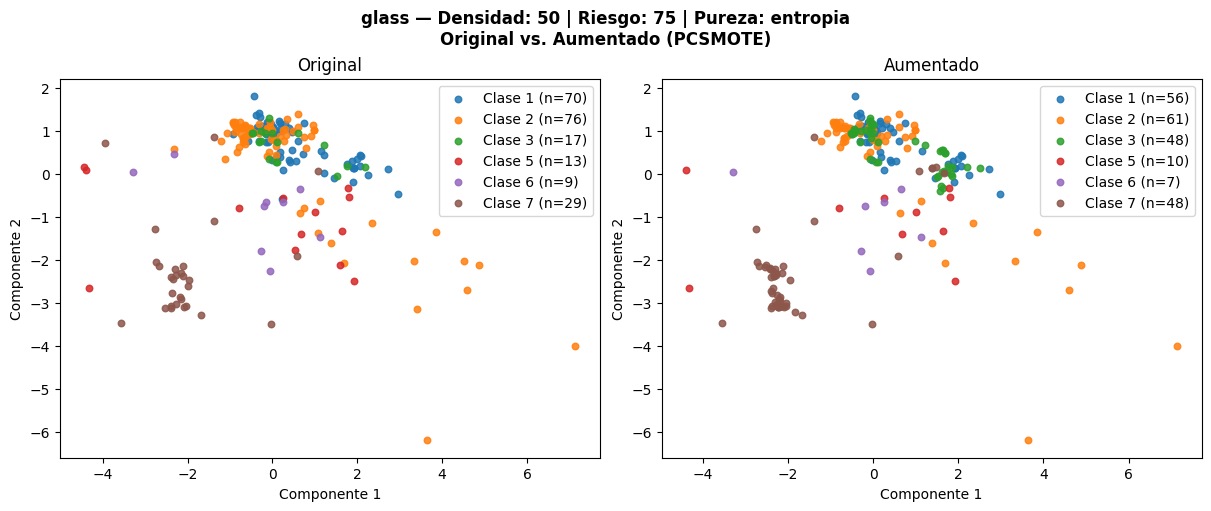

💾 Guardando datasets aumentados...
✅ Datasets guardados:
- Train aumentado: ../datasets/datasets_aumentados/pcsmote_glass_D50_R75_Pentropia_train.csv
- Test escalado: ../datasets/datasets_aumentados/pcsmote_glass_D50_R75_Pentropia_test.csv
✅ Guardado exitoso:
 - Train: ../datasets/datasets_aumentados/pcsmote_glass_D50_R75_Pentropia_train.csv
 - Test: ../datasets/datasets_aumentados/pcsmote_glass_D50_R75_Pentropia_test.csv
📁 Log por clase guardado en: ../datasets/datasets_aumentados/logs/pcsmote/por_clase/log_pcsmote_glass_D50_R75_Pentropia.csv
📘 Log por muestra guardado en: ../datasets/datasets_aumentados/logs/pcsmote/por_muestras/log_pcsmote_x_muestra_glass_D50_R75_Pentropia.xlsx
📄 Log exportado: ../datasets/datasets_aumentados/logs/pcsmote/por_clase/log_pcsmote_glass_D50_R75_Pentropia.csv
📄 Log exportado: ../datasets/datasets_aumentados/logs/pcsmote/por_muestras/log_pcsmote_x_muestra_glass_D50_R75_Pentropia.xlsx
#12 ➕ Aumentando con D=50 | R=75 | P=proporcion
📂 Cargando dataset: glas

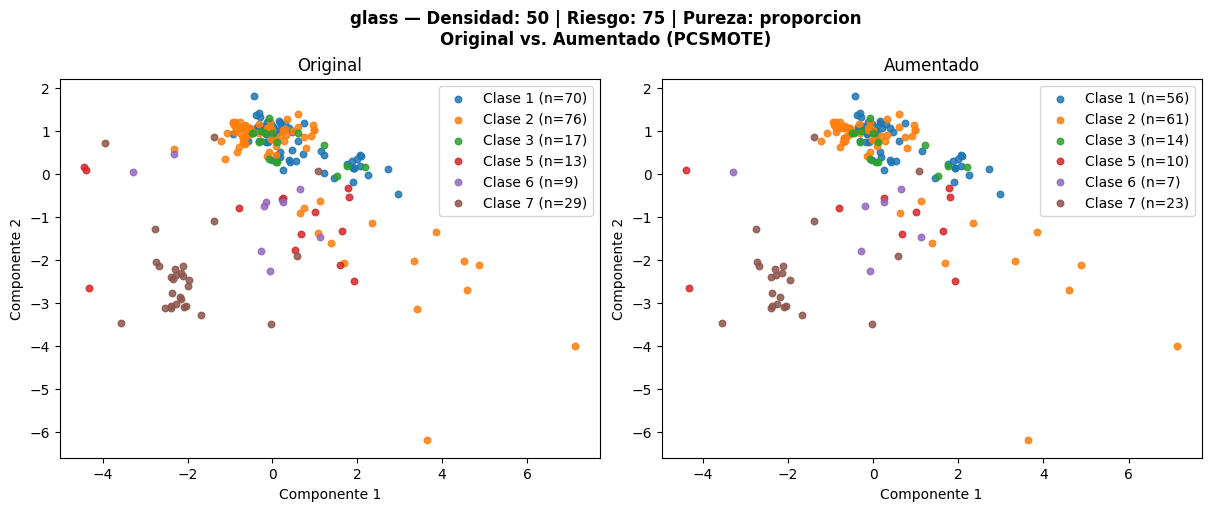

💾 Guardando datasets aumentados...
✅ Datasets guardados:
- Train aumentado: ../datasets/datasets_aumentados/pcsmote_glass_D50_R75_Pproporcion_train.csv
- Test escalado: ../datasets/datasets_aumentados/pcsmote_glass_D50_R75_Pproporcion_test.csv
✅ Guardado exitoso:
 - Train: ../datasets/datasets_aumentados/pcsmote_glass_D50_R75_Pproporcion_train.csv
 - Test: ../datasets/datasets_aumentados/pcsmote_glass_D50_R75_Pproporcion_test.csv
📁 Log por clase guardado en: ../datasets/datasets_aumentados/logs/pcsmote/por_clase/log_pcsmote_glass_D50_R75_Pproporcion.csv
📘 Log por muestra guardado en: ../datasets/datasets_aumentados/logs/pcsmote/por_muestras/log_pcsmote_x_muestra_glass_D50_R75_Pproporcion.xlsx
📄 Log exportado: ../datasets/datasets_aumentados/logs/pcsmote/por_clase/log_pcsmote_glass_D50_R75_Pproporcion.csv
📄 Log exportado: ../datasets/datasets_aumentados/logs/pcsmote/por_muestras/log_pcsmote_x_muestra_glass_D50_R75_Pproporcion.xlsx
#13 ➕ Aumentando con D=75 | R=25 | P=entropia
📂 Cargando

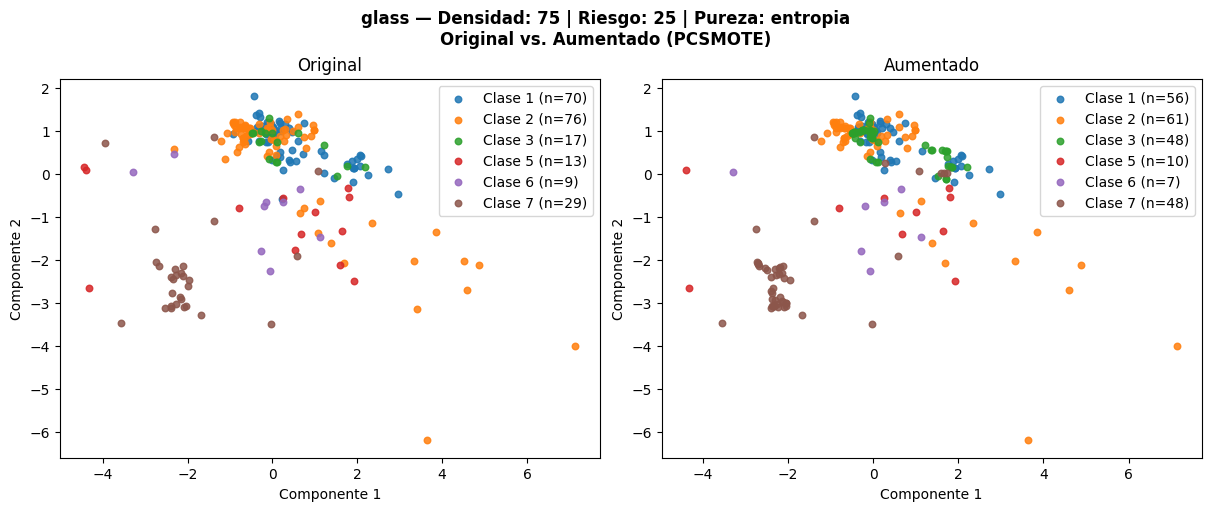

💾 Guardando datasets aumentados...
✅ Datasets guardados:
- Train aumentado: ../datasets/datasets_aumentados/pcsmote_glass_D75_R25_Pentropia_train.csv
- Test escalado: ../datasets/datasets_aumentados/pcsmote_glass_D75_R25_Pentropia_test.csv
✅ Guardado exitoso:
 - Train: ../datasets/datasets_aumentados/pcsmote_glass_D75_R25_Pentropia_train.csv
 - Test: ../datasets/datasets_aumentados/pcsmote_glass_D75_R25_Pentropia_test.csv
📁 Log por clase guardado en: ../datasets/datasets_aumentados/logs/pcsmote/por_clase/log_pcsmote_glass_D75_R25_Pentropia.csv
📘 Log por muestra guardado en: ../datasets/datasets_aumentados/logs/pcsmote/por_muestras/log_pcsmote_x_muestra_glass_D75_R25_Pentropia.xlsx
📄 Log exportado: ../datasets/datasets_aumentados/logs/pcsmote/por_clase/log_pcsmote_glass_D75_R25_Pentropia.csv
📄 Log exportado: ../datasets/datasets_aumentados/logs/pcsmote/por_muestras/log_pcsmote_x_muestra_glass_D75_R25_Pentropia.xlsx
#14 ➕ Aumentando con D=75 | R=25 | P=proporcion
📂 Cargando dataset: glas

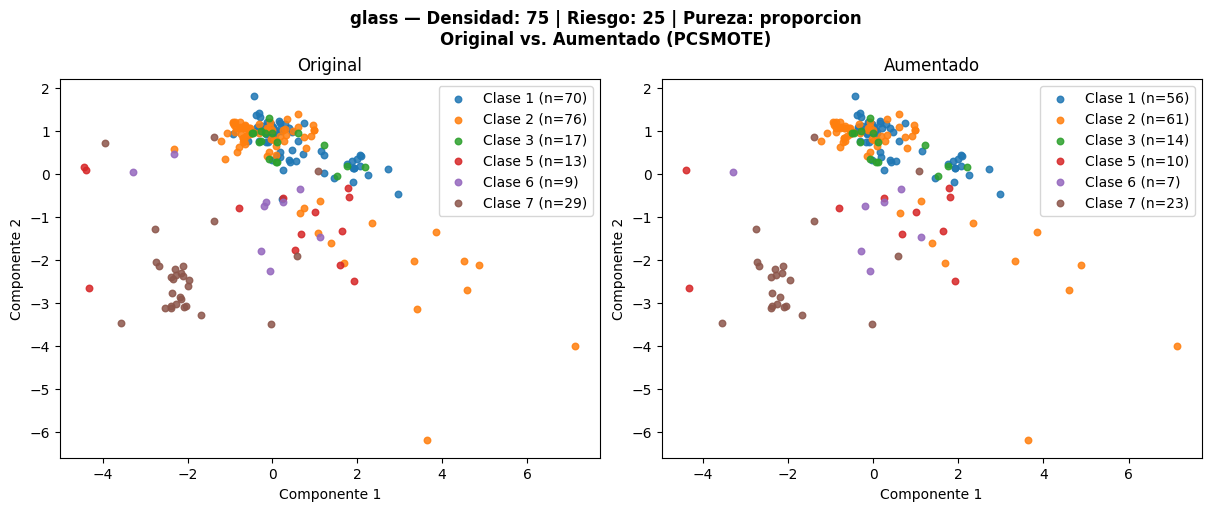

💾 Guardando datasets aumentados...
✅ Datasets guardados:
- Train aumentado: ../datasets/datasets_aumentados/pcsmote_glass_D75_R25_Pproporcion_train.csv
- Test escalado: ../datasets/datasets_aumentados/pcsmote_glass_D75_R25_Pproporcion_test.csv
✅ Guardado exitoso:
 - Train: ../datasets/datasets_aumentados/pcsmote_glass_D75_R25_Pproporcion_train.csv
 - Test: ../datasets/datasets_aumentados/pcsmote_glass_D75_R25_Pproporcion_test.csv
📁 Log por clase guardado en: ../datasets/datasets_aumentados/logs/pcsmote/por_clase/log_pcsmote_glass_D75_R25_Pproporcion.csv
📘 Log por muestra guardado en: ../datasets/datasets_aumentados/logs/pcsmote/por_muestras/log_pcsmote_x_muestra_glass_D75_R25_Pproporcion.xlsx
📄 Log exportado: ../datasets/datasets_aumentados/logs/pcsmote/por_clase/log_pcsmote_glass_D75_R25_Pproporcion.csv
📄 Log exportado: ../datasets/datasets_aumentados/logs/pcsmote/por_muestras/log_pcsmote_x_muestra_glass_D75_R25_Pproporcion.xlsx
#15 ➕ Aumentando con D=75 | R=50 | P=entropia
📂 Cargando

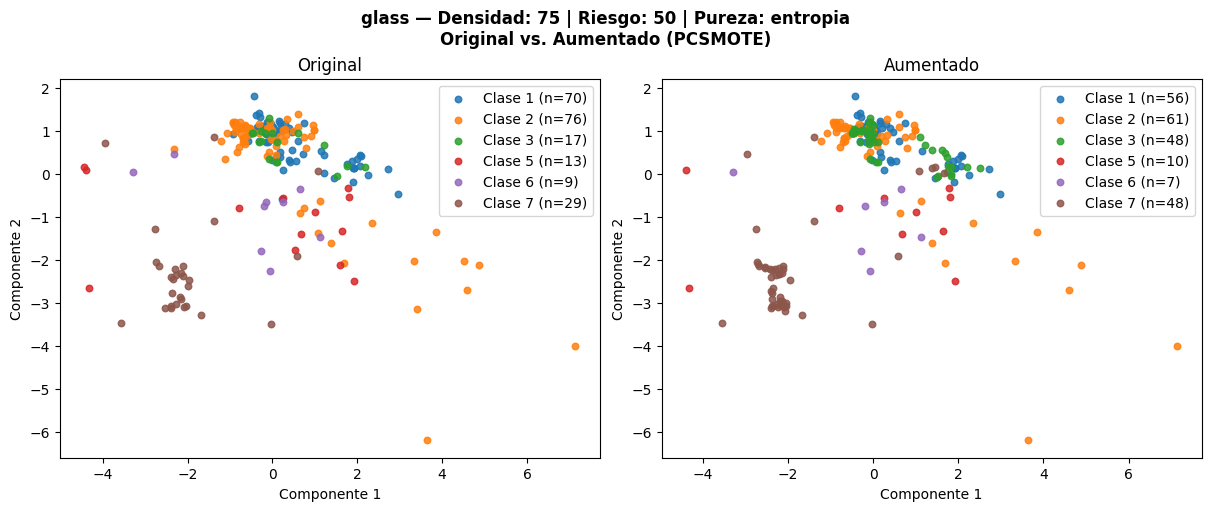

💾 Guardando datasets aumentados...
✅ Datasets guardados:
- Train aumentado: ../datasets/datasets_aumentados/pcsmote_glass_D75_R50_Pentropia_train.csv
- Test escalado: ../datasets/datasets_aumentados/pcsmote_glass_D75_R50_Pentropia_test.csv
✅ Guardado exitoso:
 - Train: ../datasets/datasets_aumentados/pcsmote_glass_D75_R50_Pentropia_train.csv
 - Test: ../datasets/datasets_aumentados/pcsmote_glass_D75_R50_Pentropia_test.csv
📁 Log por clase guardado en: ../datasets/datasets_aumentados/logs/pcsmote/por_clase/log_pcsmote_glass_D75_R50_Pentropia.csv
📘 Log por muestra guardado en: ../datasets/datasets_aumentados/logs/pcsmote/por_muestras/log_pcsmote_x_muestra_glass_D75_R50_Pentropia.xlsx
📄 Log exportado: ../datasets/datasets_aumentados/logs/pcsmote/por_clase/log_pcsmote_glass_D75_R50_Pentropia.csv
📄 Log exportado: ../datasets/datasets_aumentados/logs/pcsmote/por_muestras/log_pcsmote_x_muestra_glass_D75_R50_Pentropia.xlsx
#16 ➕ Aumentando con D=75 | R=50 | P=proporcion
📂 Cargando dataset: glas

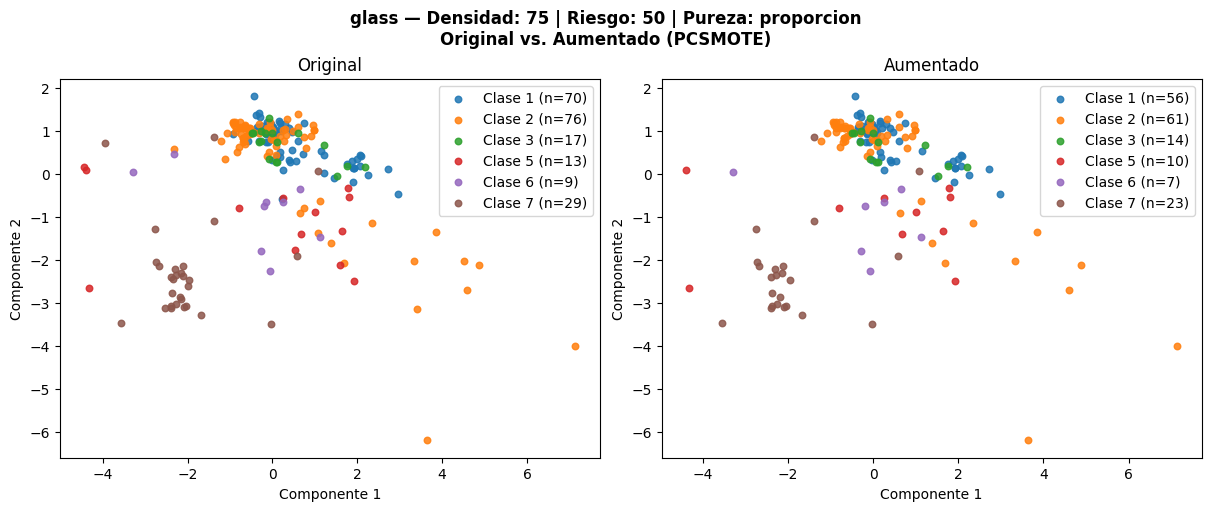

💾 Guardando datasets aumentados...
✅ Datasets guardados:
- Train aumentado: ../datasets/datasets_aumentados/pcsmote_glass_D75_R50_Pproporcion_train.csv
- Test escalado: ../datasets/datasets_aumentados/pcsmote_glass_D75_R50_Pproporcion_test.csv
✅ Guardado exitoso:
 - Train: ../datasets/datasets_aumentados/pcsmote_glass_D75_R50_Pproporcion_train.csv
 - Test: ../datasets/datasets_aumentados/pcsmote_glass_D75_R50_Pproporcion_test.csv
📁 Log por clase guardado en: ../datasets/datasets_aumentados/logs/pcsmote/por_clase/log_pcsmote_glass_D75_R50_Pproporcion.csv
📘 Log por muestra guardado en: ../datasets/datasets_aumentados/logs/pcsmote/por_muestras/log_pcsmote_x_muestra_glass_D75_R50_Pproporcion.xlsx
📄 Log exportado: ../datasets/datasets_aumentados/logs/pcsmote/por_clase/log_pcsmote_glass_D75_R50_Pproporcion.csv
📄 Log exportado: ../datasets/datasets_aumentados/logs/pcsmote/por_muestras/log_pcsmote_x_muestra_glass_D75_R50_Pproporcion.xlsx
#17 ➕ Aumentando con D=75 | R=75 | P=entropia
📂 Cargando

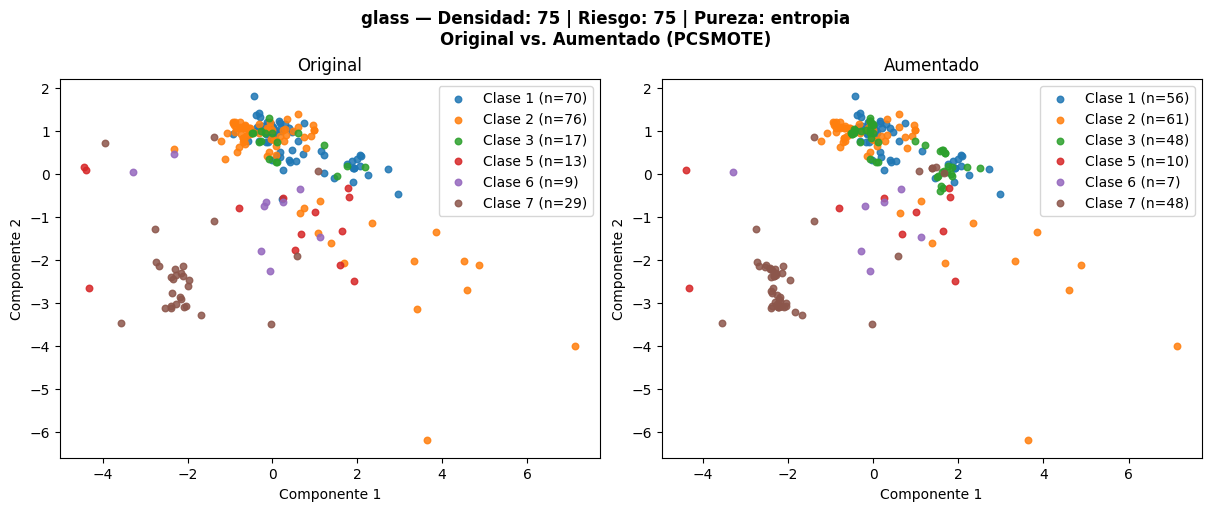

💾 Guardando datasets aumentados...
✅ Datasets guardados:
- Train aumentado: ../datasets/datasets_aumentados/pcsmote_glass_D75_R75_Pentropia_train.csv
- Test escalado: ../datasets/datasets_aumentados/pcsmote_glass_D75_R75_Pentropia_test.csv
✅ Guardado exitoso:
 - Train: ../datasets/datasets_aumentados/pcsmote_glass_D75_R75_Pentropia_train.csv
 - Test: ../datasets/datasets_aumentados/pcsmote_glass_D75_R75_Pentropia_test.csv
📁 Log por clase guardado en: ../datasets/datasets_aumentados/logs/pcsmote/por_clase/log_pcsmote_glass_D75_R75_Pentropia.csv
📘 Log por muestra guardado en: ../datasets/datasets_aumentados/logs/pcsmote/por_muestras/log_pcsmote_x_muestra_glass_D75_R75_Pentropia.xlsx
📄 Log exportado: ../datasets/datasets_aumentados/logs/pcsmote/por_clase/log_pcsmote_glass_D75_R75_Pentropia.csv
📄 Log exportado: ../datasets/datasets_aumentados/logs/pcsmote/por_muestras/log_pcsmote_x_muestra_glass_D75_R75_Pentropia.xlsx
#18 ➕ Aumentando con D=75 | R=75 | P=proporcion
📂 Cargando dataset: glas

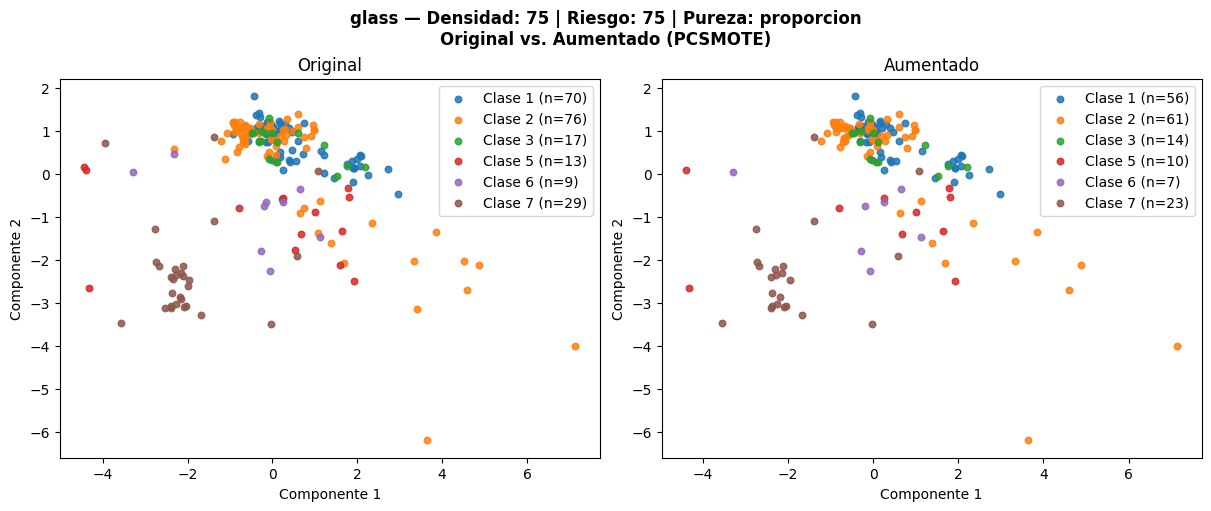

💾 Guardando datasets aumentados...
✅ Datasets guardados:
- Train aumentado: ../datasets/datasets_aumentados/pcsmote_glass_D75_R75_Pproporcion_train.csv
- Test escalado: ../datasets/datasets_aumentados/pcsmote_glass_D75_R75_Pproporcion_test.csv
✅ Guardado exitoso:
 - Train: ../datasets/datasets_aumentados/pcsmote_glass_D75_R75_Pproporcion_train.csv
 - Test: ../datasets/datasets_aumentados/pcsmote_glass_D75_R75_Pproporcion_test.csv
📁 Log por clase guardado en: ../datasets/datasets_aumentados/logs/pcsmote/por_clase/log_pcsmote_glass_D75_R75_Pproporcion.csv
📘 Log por muestra guardado en: ../datasets/datasets_aumentados/logs/pcsmote/por_muestras/log_pcsmote_x_muestra_glass_D75_R75_Pproporcion.xlsx
📄 Log exportado: ../datasets/datasets_aumentados/logs/pcsmote/por_clase/log_pcsmote_glass_D75_R75_Pproporcion.csv
📄 Log exportado: ../datasets/datasets_aumentados/logs/pcsmote/por_muestras/log_pcsmote_x_muestra_glass_D75_R75_Pproporcion.xlsx

📁 Dataset: heart
#01 ➕ Aumentando con D=25 | R=25 | P=e

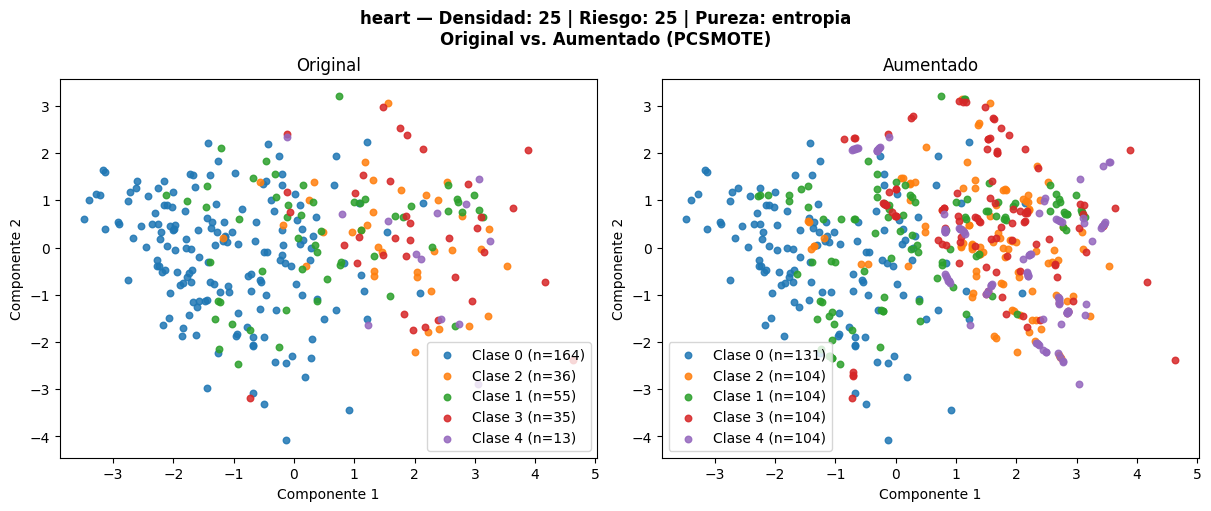

💾 Guardando datasets aumentados...
✅ Datasets guardados:
- Train aumentado: ../datasets/datasets_aumentados/pcsmote_heart_D25_R25_Pentropia_train.csv
- Test escalado: ../datasets/datasets_aumentados/pcsmote_heart_D25_R25_Pentropia_test.csv
✅ Guardado exitoso:
 - Train: ../datasets/datasets_aumentados/pcsmote_heart_D25_R25_Pentropia_train.csv
 - Test: ../datasets/datasets_aumentados/pcsmote_heart_D25_R25_Pentropia_test.csv
📁 Log por clase guardado en: ../datasets/datasets_aumentados/logs/pcsmote/por_clase/log_pcsmote_heart_D25_R25_Pentropia.csv
📘 Log por muestra guardado en: ../datasets/datasets_aumentados/logs/pcsmote/por_muestras/log_pcsmote_x_muestra_heart_D25_R25_Pentropia.xlsx
📄 Log exportado: ../datasets/datasets_aumentados/logs/pcsmote/por_clase/log_pcsmote_heart_D25_R25_Pentropia.csv
📄 Log exportado: ../datasets/datasets_aumentados/logs/pcsmote/por_muestras/log_pcsmote_x_muestra_heart_D25_R25_Pentropia.xlsx
#02 ➕ Aumentando con D=25 | R=25 | P=proporcion
📂 Cargando dataset: hear

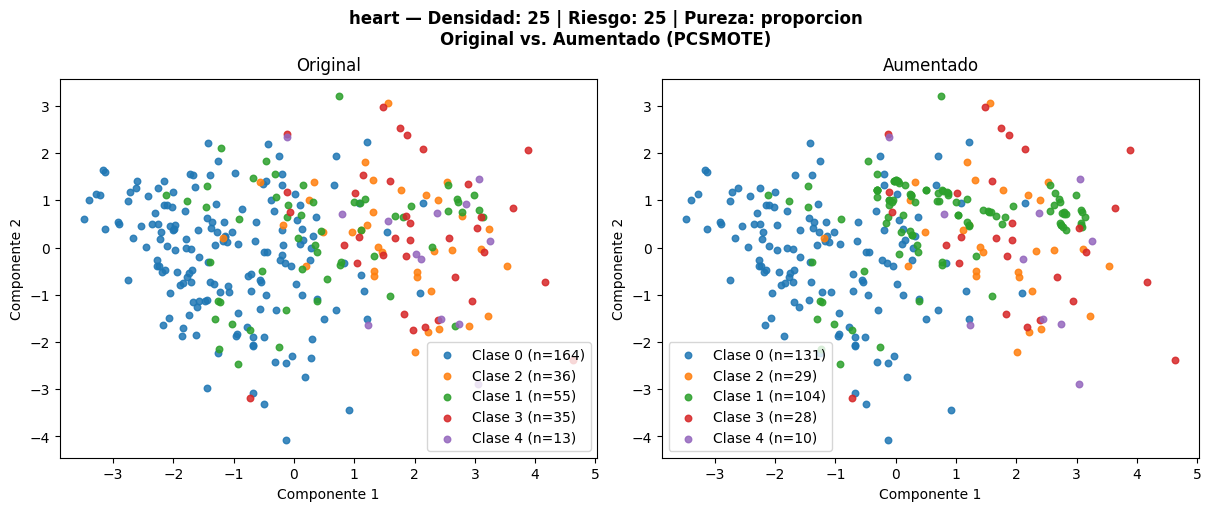

💾 Guardando datasets aumentados...
✅ Datasets guardados:
- Train aumentado: ../datasets/datasets_aumentados/pcsmote_heart_D25_R25_Pproporcion_train.csv
- Test escalado: ../datasets/datasets_aumentados/pcsmote_heart_D25_R25_Pproporcion_test.csv
✅ Guardado exitoso:
 - Train: ../datasets/datasets_aumentados/pcsmote_heart_D25_R25_Pproporcion_train.csv
 - Test: ../datasets/datasets_aumentados/pcsmote_heart_D25_R25_Pproporcion_test.csv
📁 Log por clase guardado en: ../datasets/datasets_aumentados/logs/pcsmote/por_clase/log_pcsmote_heart_D25_R25_Pproporcion.csv
📘 Log por muestra guardado en: ../datasets/datasets_aumentados/logs/pcsmote/por_muestras/log_pcsmote_x_muestra_heart_D25_R25_Pproporcion.xlsx
📄 Log exportado: ../datasets/datasets_aumentados/logs/pcsmote/por_clase/log_pcsmote_heart_D25_R25_Pproporcion.csv
📄 Log exportado: ../datasets/datasets_aumentados/logs/pcsmote/por_muestras/log_pcsmote_x_muestra_heart_D25_R25_Pproporcion.xlsx
#03 ➕ Aumentando con D=25 | R=50 | P=entropia
📂 Cargando

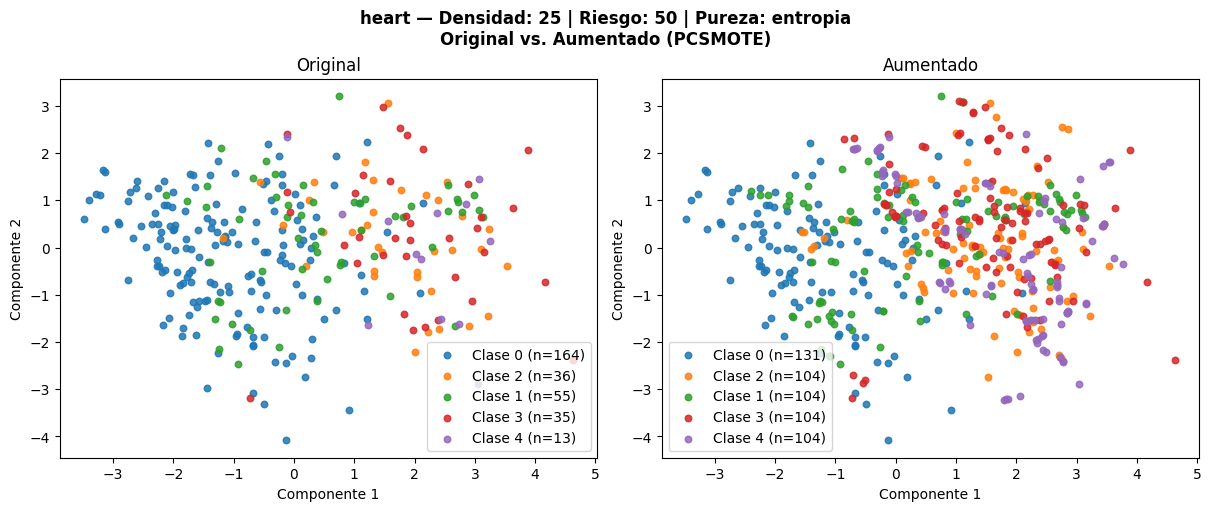

💾 Guardando datasets aumentados...
✅ Datasets guardados:
- Train aumentado: ../datasets/datasets_aumentados/pcsmote_heart_D25_R50_Pentropia_train.csv
- Test escalado: ../datasets/datasets_aumentados/pcsmote_heart_D25_R50_Pentropia_test.csv
✅ Guardado exitoso:
 - Train: ../datasets/datasets_aumentados/pcsmote_heart_D25_R50_Pentropia_train.csv
 - Test: ../datasets/datasets_aumentados/pcsmote_heart_D25_R50_Pentropia_test.csv
📁 Log por clase guardado en: ../datasets/datasets_aumentados/logs/pcsmote/por_clase/log_pcsmote_heart_D25_R50_Pentropia.csv
📘 Log por muestra guardado en: ../datasets/datasets_aumentados/logs/pcsmote/por_muestras/log_pcsmote_x_muestra_heart_D25_R50_Pentropia.xlsx
📄 Log exportado: ../datasets/datasets_aumentados/logs/pcsmote/por_clase/log_pcsmote_heart_D25_R50_Pentropia.csv
📄 Log exportado: ../datasets/datasets_aumentados/logs/pcsmote/por_muestras/log_pcsmote_x_muestra_heart_D25_R50_Pentropia.xlsx
#04 ➕ Aumentando con D=25 | R=50 | P=proporcion
📂 Cargando dataset: hear

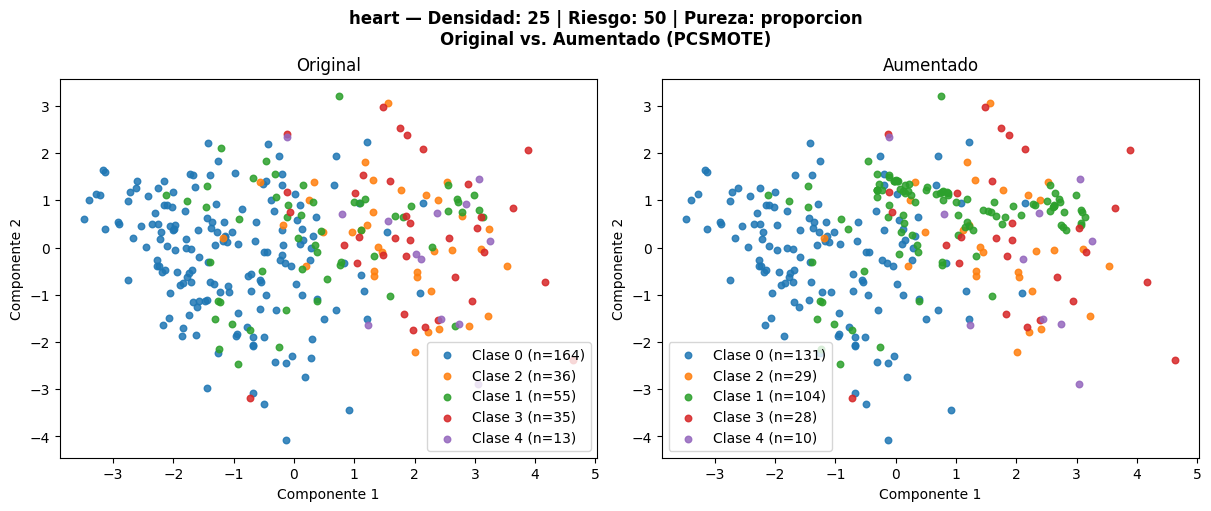

💾 Guardando datasets aumentados...
✅ Datasets guardados:
- Train aumentado: ../datasets/datasets_aumentados/pcsmote_heart_D25_R50_Pproporcion_train.csv
- Test escalado: ../datasets/datasets_aumentados/pcsmote_heart_D25_R50_Pproporcion_test.csv
✅ Guardado exitoso:
 - Train: ../datasets/datasets_aumentados/pcsmote_heart_D25_R50_Pproporcion_train.csv
 - Test: ../datasets/datasets_aumentados/pcsmote_heart_D25_R50_Pproporcion_test.csv
📁 Log por clase guardado en: ../datasets/datasets_aumentados/logs/pcsmote/por_clase/log_pcsmote_heart_D25_R50_Pproporcion.csv
📘 Log por muestra guardado en: ../datasets/datasets_aumentados/logs/pcsmote/por_muestras/log_pcsmote_x_muestra_heart_D25_R50_Pproporcion.xlsx
📄 Log exportado: ../datasets/datasets_aumentados/logs/pcsmote/por_clase/log_pcsmote_heart_D25_R50_Pproporcion.csv
📄 Log exportado: ../datasets/datasets_aumentados/logs/pcsmote/por_muestras/log_pcsmote_x_muestra_heart_D25_R50_Pproporcion.xlsx
#05 ➕ Aumentando con D=25 | R=75 | P=entropia
📂 Cargando

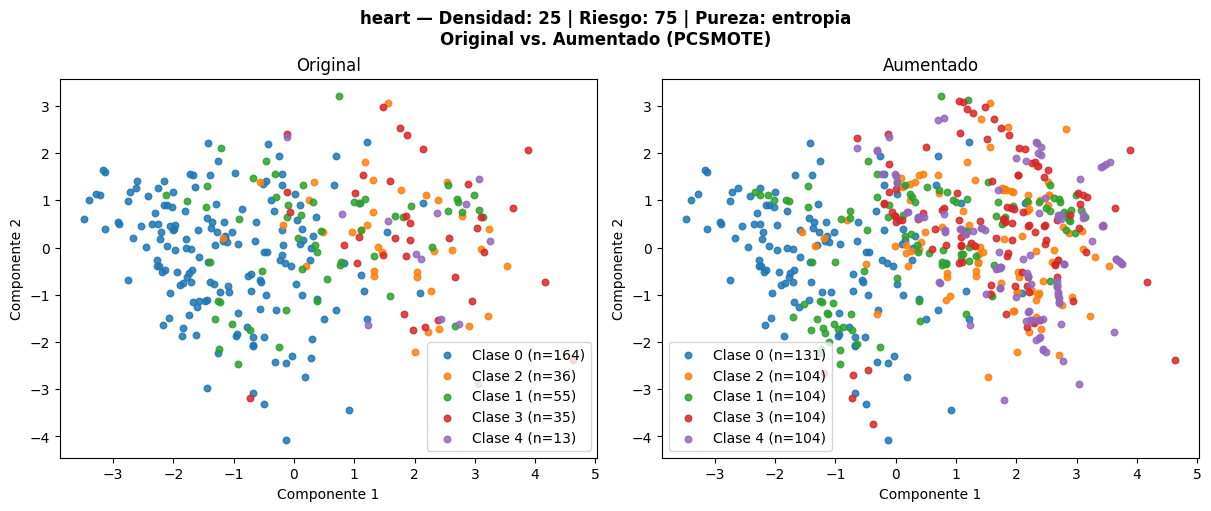

💾 Guardando datasets aumentados...
✅ Datasets guardados:
- Train aumentado: ../datasets/datasets_aumentados/pcsmote_heart_D25_R75_Pentropia_train.csv
- Test escalado: ../datasets/datasets_aumentados/pcsmote_heart_D25_R75_Pentropia_test.csv
✅ Guardado exitoso:
 - Train: ../datasets/datasets_aumentados/pcsmote_heart_D25_R75_Pentropia_train.csv
 - Test: ../datasets/datasets_aumentados/pcsmote_heart_D25_R75_Pentropia_test.csv
📁 Log por clase guardado en: ../datasets/datasets_aumentados/logs/pcsmote/por_clase/log_pcsmote_heart_D25_R75_Pentropia.csv
📘 Log por muestra guardado en: ../datasets/datasets_aumentados/logs/pcsmote/por_muestras/log_pcsmote_x_muestra_heart_D25_R75_Pentropia.xlsx
📄 Log exportado: ../datasets/datasets_aumentados/logs/pcsmote/por_clase/log_pcsmote_heart_D25_R75_Pentropia.csv
📄 Log exportado: ../datasets/datasets_aumentados/logs/pcsmote/por_muestras/log_pcsmote_x_muestra_heart_D25_R75_Pentropia.xlsx
#06 ➕ Aumentando con D=25 | R=75 | P=proporcion
📂 Cargando dataset: hear

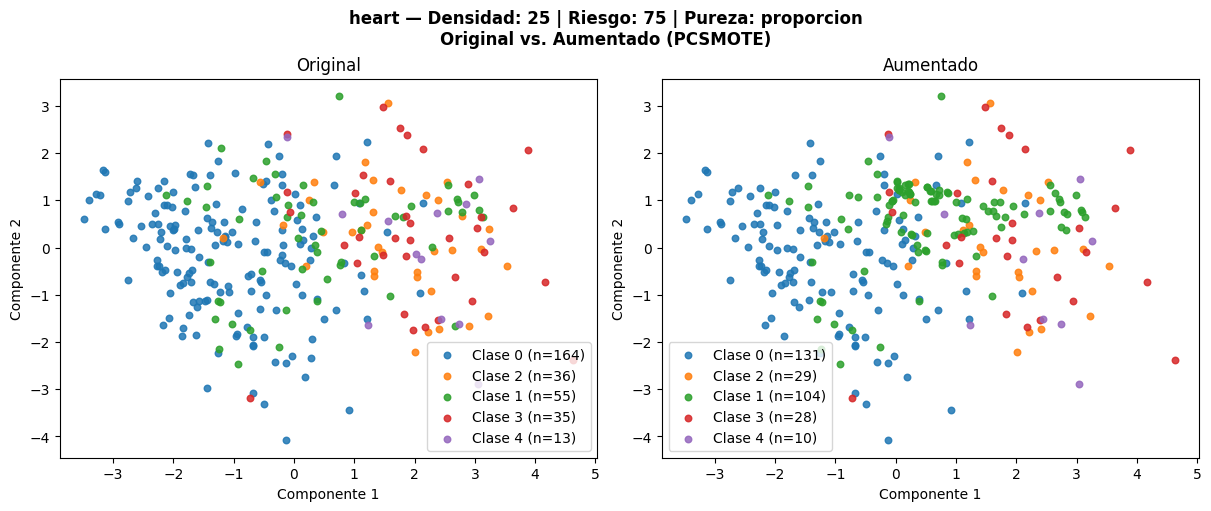

💾 Guardando datasets aumentados...
✅ Datasets guardados:
- Train aumentado: ../datasets/datasets_aumentados/pcsmote_heart_D25_R75_Pproporcion_train.csv
- Test escalado: ../datasets/datasets_aumentados/pcsmote_heart_D25_R75_Pproporcion_test.csv
✅ Guardado exitoso:
 - Train: ../datasets/datasets_aumentados/pcsmote_heart_D25_R75_Pproporcion_train.csv
 - Test: ../datasets/datasets_aumentados/pcsmote_heart_D25_R75_Pproporcion_test.csv
📁 Log por clase guardado en: ../datasets/datasets_aumentados/logs/pcsmote/por_clase/log_pcsmote_heart_D25_R75_Pproporcion.csv
📘 Log por muestra guardado en: ../datasets/datasets_aumentados/logs/pcsmote/por_muestras/log_pcsmote_x_muestra_heart_D25_R75_Pproporcion.xlsx
📄 Log exportado: ../datasets/datasets_aumentados/logs/pcsmote/por_clase/log_pcsmote_heart_D25_R75_Pproporcion.csv
📄 Log exportado: ../datasets/datasets_aumentados/logs/pcsmote/por_muestras/log_pcsmote_x_muestra_heart_D25_R75_Pproporcion.xlsx
#07 ➕ Aumentando con D=50 | R=25 | P=entropia
📂 Cargando

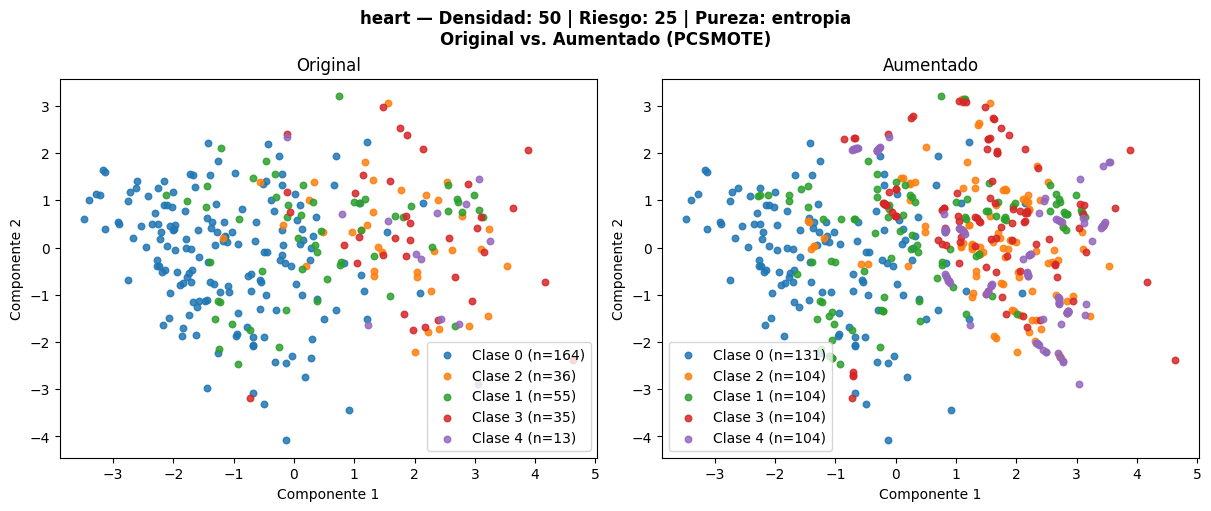

💾 Guardando datasets aumentados...
✅ Datasets guardados:
- Train aumentado: ../datasets/datasets_aumentados/pcsmote_heart_D50_R25_Pentropia_train.csv
- Test escalado: ../datasets/datasets_aumentados/pcsmote_heart_D50_R25_Pentropia_test.csv
✅ Guardado exitoso:
 - Train: ../datasets/datasets_aumentados/pcsmote_heart_D50_R25_Pentropia_train.csv
 - Test: ../datasets/datasets_aumentados/pcsmote_heart_D50_R25_Pentropia_test.csv
📁 Log por clase guardado en: ../datasets/datasets_aumentados/logs/pcsmote/por_clase/log_pcsmote_heart_D50_R25_Pentropia.csv
📘 Log por muestra guardado en: ../datasets/datasets_aumentados/logs/pcsmote/por_muestras/log_pcsmote_x_muestra_heart_D50_R25_Pentropia.xlsx
📄 Log exportado: ../datasets/datasets_aumentados/logs/pcsmote/por_clase/log_pcsmote_heart_D50_R25_Pentropia.csv
📄 Log exportado: ../datasets/datasets_aumentados/logs/pcsmote/por_muestras/log_pcsmote_x_muestra_heart_D50_R25_Pentropia.xlsx
#08 ➕ Aumentando con D=50 | R=25 | P=proporcion
📂 Cargando dataset: hear

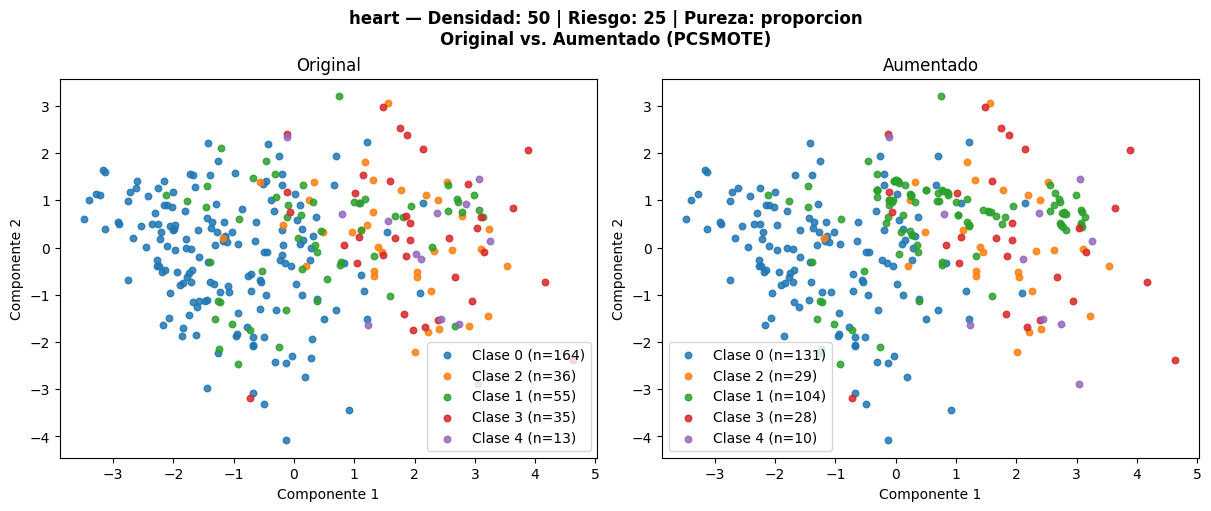

💾 Guardando datasets aumentados...
✅ Datasets guardados:
- Train aumentado: ../datasets/datasets_aumentados/pcsmote_heart_D50_R25_Pproporcion_train.csv
- Test escalado: ../datasets/datasets_aumentados/pcsmote_heart_D50_R25_Pproporcion_test.csv
✅ Guardado exitoso:
 - Train: ../datasets/datasets_aumentados/pcsmote_heart_D50_R25_Pproporcion_train.csv
 - Test: ../datasets/datasets_aumentados/pcsmote_heart_D50_R25_Pproporcion_test.csv
📁 Log por clase guardado en: ../datasets/datasets_aumentados/logs/pcsmote/por_clase/log_pcsmote_heart_D50_R25_Pproporcion.csv
📘 Log por muestra guardado en: ../datasets/datasets_aumentados/logs/pcsmote/por_muestras/log_pcsmote_x_muestra_heart_D50_R25_Pproporcion.xlsx
📄 Log exportado: ../datasets/datasets_aumentados/logs/pcsmote/por_clase/log_pcsmote_heart_D50_R25_Pproporcion.csv
📄 Log exportado: ../datasets/datasets_aumentados/logs/pcsmote/por_muestras/log_pcsmote_x_muestra_heart_D50_R25_Pproporcion.xlsx
#09 ➕ Aumentando con D=50 | R=50 | P=entropia
📂 Cargando

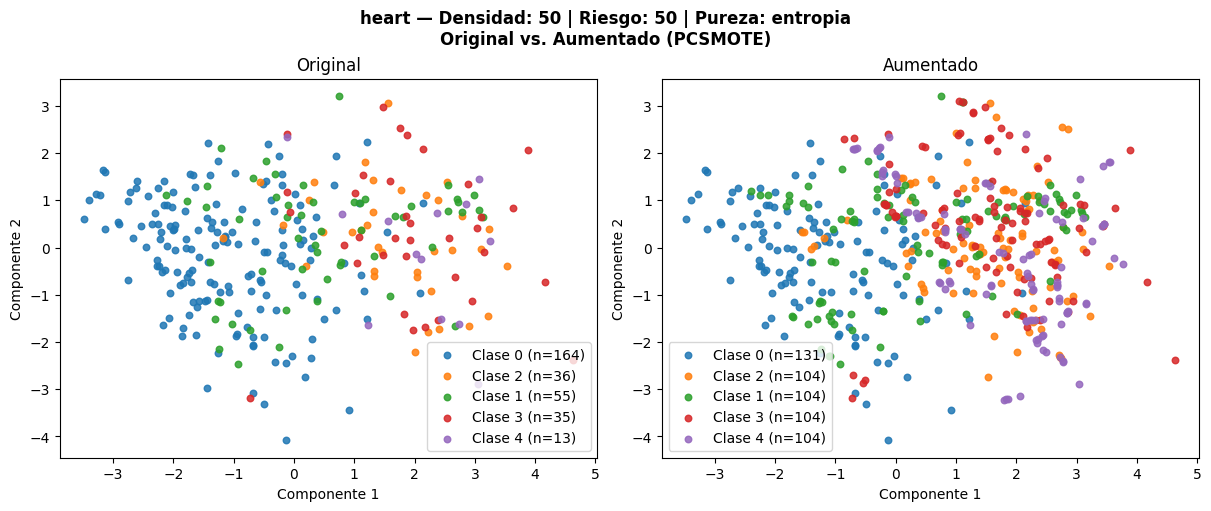

💾 Guardando datasets aumentados...
✅ Datasets guardados:
- Train aumentado: ../datasets/datasets_aumentados/pcsmote_heart_D50_R50_Pentropia_train.csv
- Test escalado: ../datasets/datasets_aumentados/pcsmote_heart_D50_R50_Pentropia_test.csv
✅ Guardado exitoso:
 - Train: ../datasets/datasets_aumentados/pcsmote_heart_D50_R50_Pentropia_train.csv
 - Test: ../datasets/datasets_aumentados/pcsmote_heart_D50_R50_Pentropia_test.csv
📁 Log por clase guardado en: ../datasets/datasets_aumentados/logs/pcsmote/por_clase/log_pcsmote_heart_D50_R50_Pentropia.csv
📘 Log por muestra guardado en: ../datasets/datasets_aumentados/logs/pcsmote/por_muestras/log_pcsmote_x_muestra_heart_D50_R50_Pentropia.xlsx
📄 Log exportado: ../datasets/datasets_aumentados/logs/pcsmote/por_clase/log_pcsmote_heart_D50_R50_Pentropia.csv
📄 Log exportado: ../datasets/datasets_aumentados/logs/pcsmote/por_muestras/log_pcsmote_x_muestra_heart_D50_R50_Pentropia.xlsx
#10 ➕ Aumentando con D=50 | R=50 | P=proporcion
📂 Cargando dataset: hear

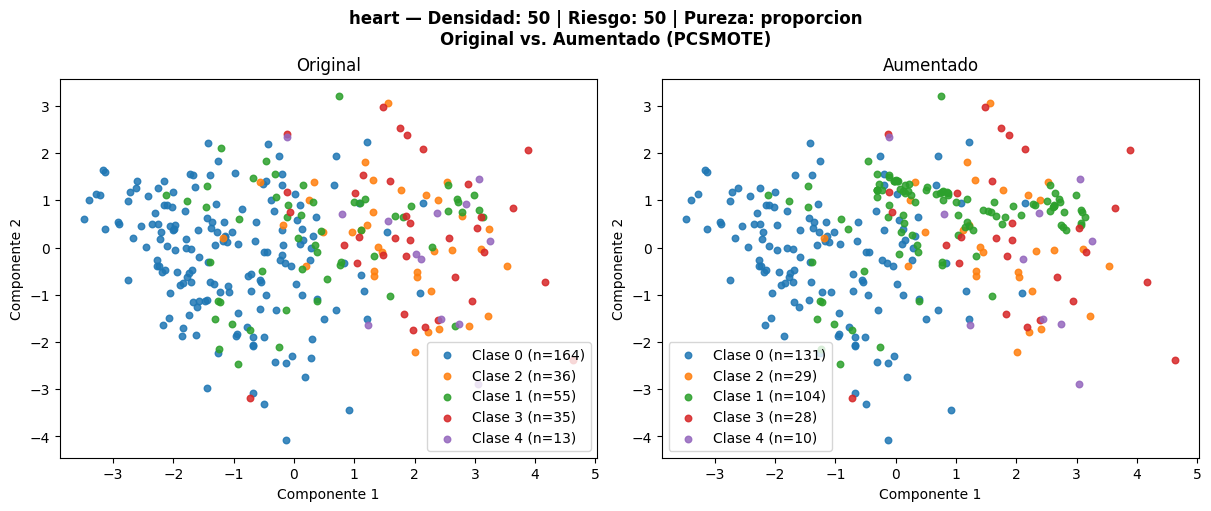

💾 Guardando datasets aumentados...
✅ Datasets guardados:
- Train aumentado: ../datasets/datasets_aumentados/pcsmote_heart_D50_R50_Pproporcion_train.csv
- Test escalado: ../datasets/datasets_aumentados/pcsmote_heart_D50_R50_Pproporcion_test.csv
✅ Guardado exitoso:
 - Train: ../datasets/datasets_aumentados/pcsmote_heart_D50_R50_Pproporcion_train.csv
 - Test: ../datasets/datasets_aumentados/pcsmote_heart_D50_R50_Pproporcion_test.csv
📁 Log por clase guardado en: ../datasets/datasets_aumentados/logs/pcsmote/por_clase/log_pcsmote_heart_D50_R50_Pproporcion.csv
📘 Log por muestra guardado en: ../datasets/datasets_aumentados/logs/pcsmote/por_muestras/log_pcsmote_x_muestra_heart_D50_R50_Pproporcion.xlsx
📄 Log exportado: ../datasets/datasets_aumentados/logs/pcsmote/por_clase/log_pcsmote_heart_D50_R50_Pproporcion.csv
📄 Log exportado: ../datasets/datasets_aumentados/logs/pcsmote/por_muestras/log_pcsmote_x_muestra_heart_D50_R50_Pproporcion.xlsx
#11 ➕ Aumentando con D=50 | R=75 | P=entropia
📂 Cargando

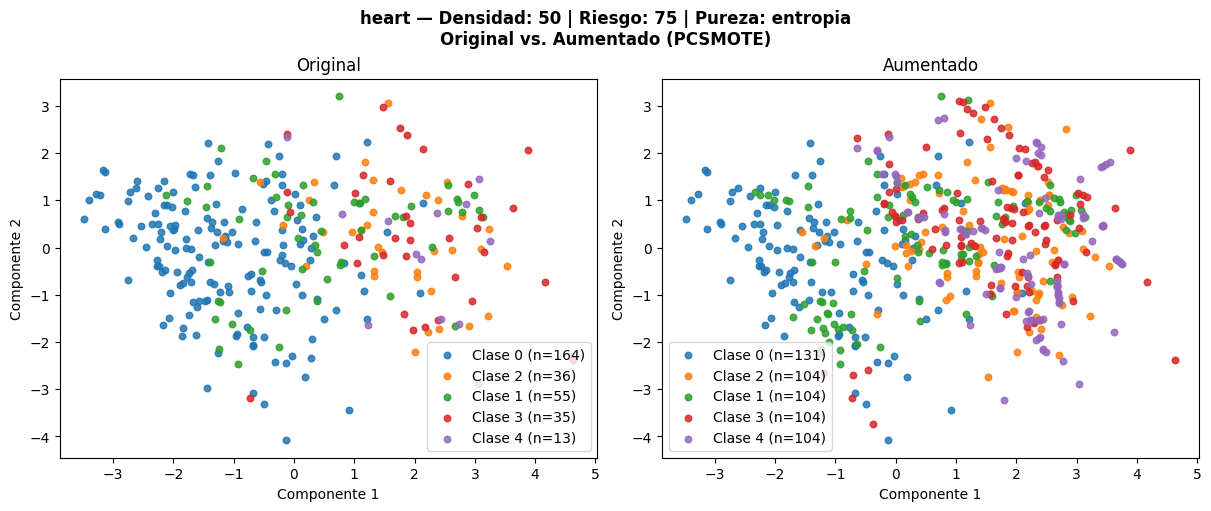

💾 Guardando datasets aumentados...
✅ Datasets guardados:
- Train aumentado: ../datasets/datasets_aumentados/pcsmote_heart_D50_R75_Pentropia_train.csv
- Test escalado: ../datasets/datasets_aumentados/pcsmote_heart_D50_R75_Pentropia_test.csv
✅ Guardado exitoso:
 - Train: ../datasets/datasets_aumentados/pcsmote_heart_D50_R75_Pentropia_train.csv
 - Test: ../datasets/datasets_aumentados/pcsmote_heart_D50_R75_Pentropia_test.csv
📁 Log por clase guardado en: ../datasets/datasets_aumentados/logs/pcsmote/por_clase/log_pcsmote_heart_D50_R75_Pentropia.csv
📘 Log por muestra guardado en: ../datasets/datasets_aumentados/logs/pcsmote/por_muestras/log_pcsmote_x_muestra_heart_D50_R75_Pentropia.xlsx
📄 Log exportado: ../datasets/datasets_aumentados/logs/pcsmote/por_clase/log_pcsmote_heart_D50_R75_Pentropia.csv
📄 Log exportado: ../datasets/datasets_aumentados/logs/pcsmote/por_muestras/log_pcsmote_x_muestra_heart_D50_R75_Pentropia.xlsx
#12 ➕ Aumentando con D=50 | R=75 | P=proporcion
📂 Cargando dataset: hear

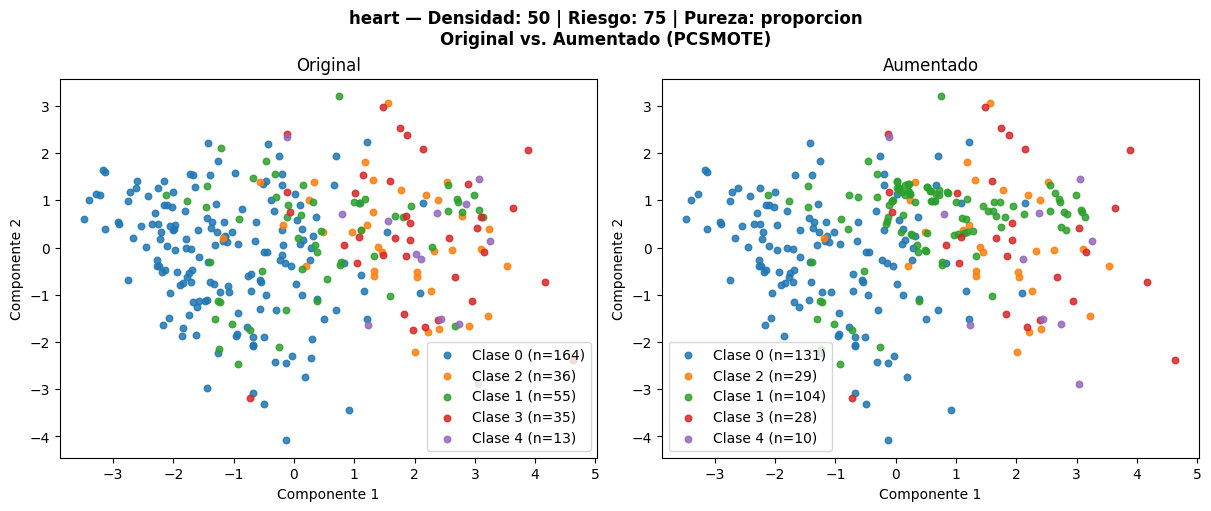

💾 Guardando datasets aumentados...
✅ Datasets guardados:
- Train aumentado: ../datasets/datasets_aumentados/pcsmote_heart_D50_R75_Pproporcion_train.csv
- Test escalado: ../datasets/datasets_aumentados/pcsmote_heart_D50_R75_Pproporcion_test.csv
✅ Guardado exitoso:
 - Train: ../datasets/datasets_aumentados/pcsmote_heart_D50_R75_Pproporcion_train.csv
 - Test: ../datasets/datasets_aumentados/pcsmote_heart_D50_R75_Pproporcion_test.csv
📁 Log por clase guardado en: ../datasets/datasets_aumentados/logs/pcsmote/por_clase/log_pcsmote_heart_D50_R75_Pproporcion.csv
📘 Log por muestra guardado en: ../datasets/datasets_aumentados/logs/pcsmote/por_muestras/log_pcsmote_x_muestra_heart_D50_R75_Pproporcion.xlsx
📄 Log exportado: ../datasets/datasets_aumentados/logs/pcsmote/por_clase/log_pcsmote_heart_D50_R75_Pproporcion.csv
📄 Log exportado: ../datasets/datasets_aumentados/logs/pcsmote/por_muestras/log_pcsmote_x_muestra_heart_D50_R75_Pproporcion.xlsx
#13 ➕ Aumentando con D=75 | R=25 | P=entropia
📂 Cargando

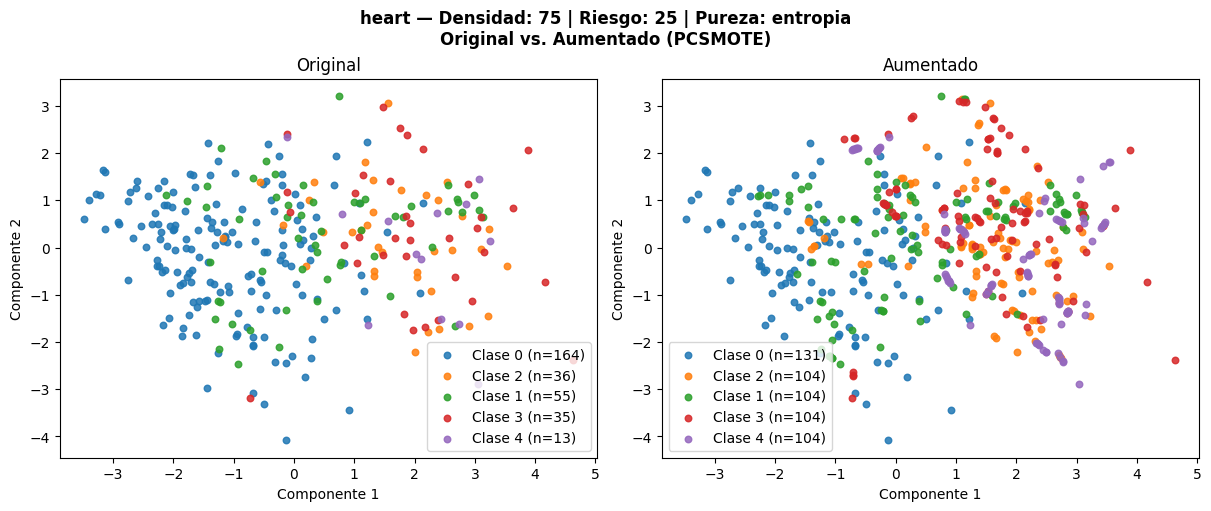

💾 Guardando datasets aumentados...
✅ Datasets guardados:
- Train aumentado: ../datasets/datasets_aumentados/pcsmote_heart_D75_R25_Pentropia_train.csv
- Test escalado: ../datasets/datasets_aumentados/pcsmote_heart_D75_R25_Pentropia_test.csv
✅ Guardado exitoso:
 - Train: ../datasets/datasets_aumentados/pcsmote_heart_D75_R25_Pentropia_train.csv
 - Test: ../datasets/datasets_aumentados/pcsmote_heart_D75_R25_Pentropia_test.csv
📁 Log por clase guardado en: ../datasets/datasets_aumentados/logs/pcsmote/por_clase/log_pcsmote_heart_D75_R25_Pentropia.csv
📘 Log por muestra guardado en: ../datasets/datasets_aumentados/logs/pcsmote/por_muestras/log_pcsmote_x_muestra_heart_D75_R25_Pentropia.xlsx
📄 Log exportado: ../datasets/datasets_aumentados/logs/pcsmote/por_clase/log_pcsmote_heart_D75_R25_Pentropia.csv
📄 Log exportado: ../datasets/datasets_aumentados/logs/pcsmote/por_muestras/log_pcsmote_x_muestra_heart_D75_R25_Pentropia.xlsx
#14 ➕ Aumentando con D=75 | R=25 | P=proporcion
📂 Cargando dataset: hear

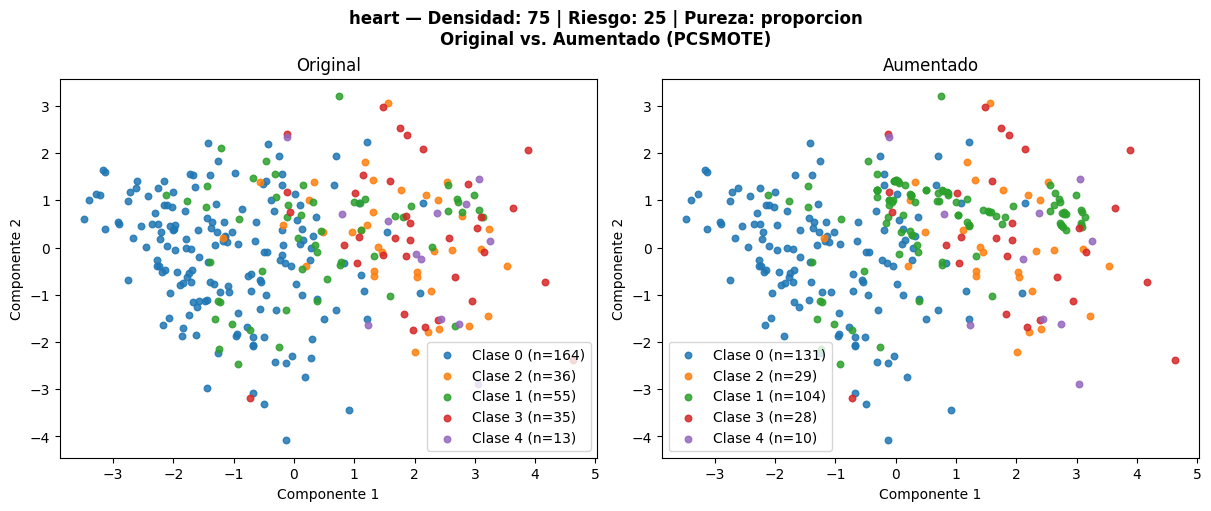

💾 Guardando datasets aumentados...
✅ Datasets guardados:
- Train aumentado: ../datasets/datasets_aumentados/pcsmote_heart_D75_R25_Pproporcion_train.csv
- Test escalado: ../datasets/datasets_aumentados/pcsmote_heart_D75_R25_Pproporcion_test.csv
✅ Guardado exitoso:
 - Train: ../datasets/datasets_aumentados/pcsmote_heart_D75_R25_Pproporcion_train.csv
 - Test: ../datasets/datasets_aumentados/pcsmote_heart_D75_R25_Pproporcion_test.csv
📁 Log por clase guardado en: ../datasets/datasets_aumentados/logs/pcsmote/por_clase/log_pcsmote_heart_D75_R25_Pproporcion.csv
📘 Log por muestra guardado en: ../datasets/datasets_aumentados/logs/pcsmote/por_muestras/log_pcsmote_x_muestra_heart_D75_R25_Pproporcion.xlsx
📄 Log exportado: ../datasets/datasets_aumentados/logs/pcsmote/por_clase/log_pcsmote_heart_D75_R25_Pproporcion.csv
📄 Log exportado: ../datasets/datasets_aumentados/logs/pcsmote/por_muestras/log_pcsmote_x_muestra_heart_D75_R25_Pproporcion.xlsx
#15 ➕ Aumentando con D=75 | R=50 | P=entropia
📂 Cargando

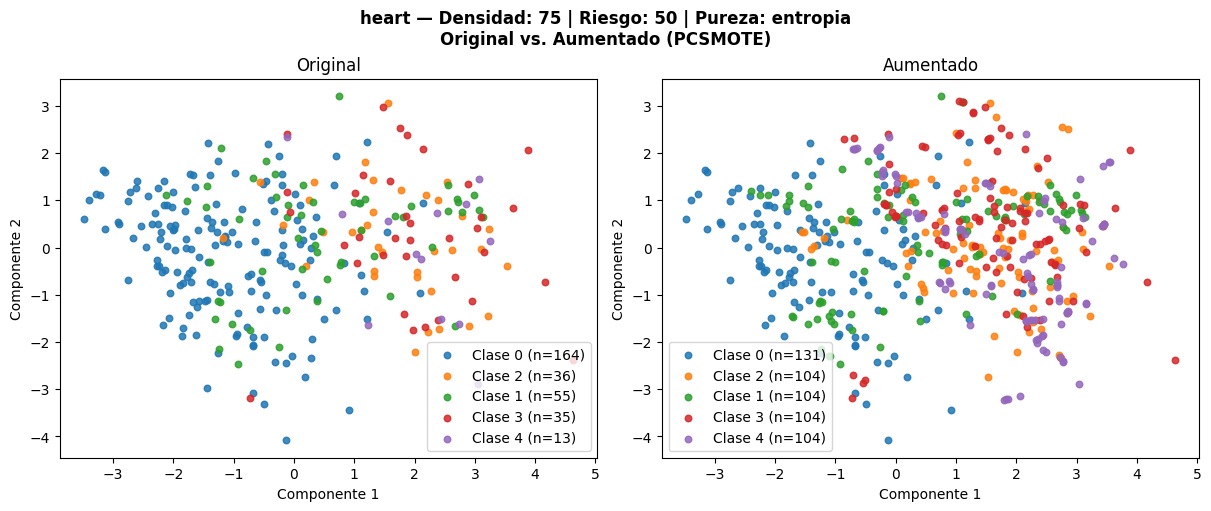

💾 Guardando datasets aumentados...
✅ Datasets guardados:
- Train aumentado: ../datasets/datasets_aumentados/pcsmote_heart_D75_R50_Pentropia_train.csv
- Test escalado: ../datasets/datasets_aumentados/pcsmote_heart_D75_R50_Pentropia_test.csv
✅ Guardado exitoso:
 - Train: ../datasets/datasets_aumentados/pcsmote_heart_D75_R50_Pentropia_train.csv
 - Test: ../datasets/datasets_aumentados/pcsmote_heart_D75_R50_Pentropia_test.csv
📁 Log por clase guardado en: ../datasets/datasets_aumentados/logs/pcsmote/por_clase/log_pcsmote_heart_D75_R50_Pentropia.csv
📘 Log por muestra guardado en: ../datasets/datasets_aumentados/logs/pcsmote/por_muestras/log_pcsmote_x_muestra_heart_D75_R50_Pentropia.xlsx
📄 Log exportado: ../datasets/datasets_aumentados/logs/pcsmote/por_clase/log_pcsmote_heart_D75_R50_Pentropia.csv
📄 Log exportado: ../datasets/datasets_aumentados/logs/pcsmote/por_muestras/log_pcsmote_x_muestra_heart_D75_R50_Pentropia.xlsx
#16 ➕ Aumentando con D=75 | R=50 | P=proporcion
📂 Cargando dataset: hear

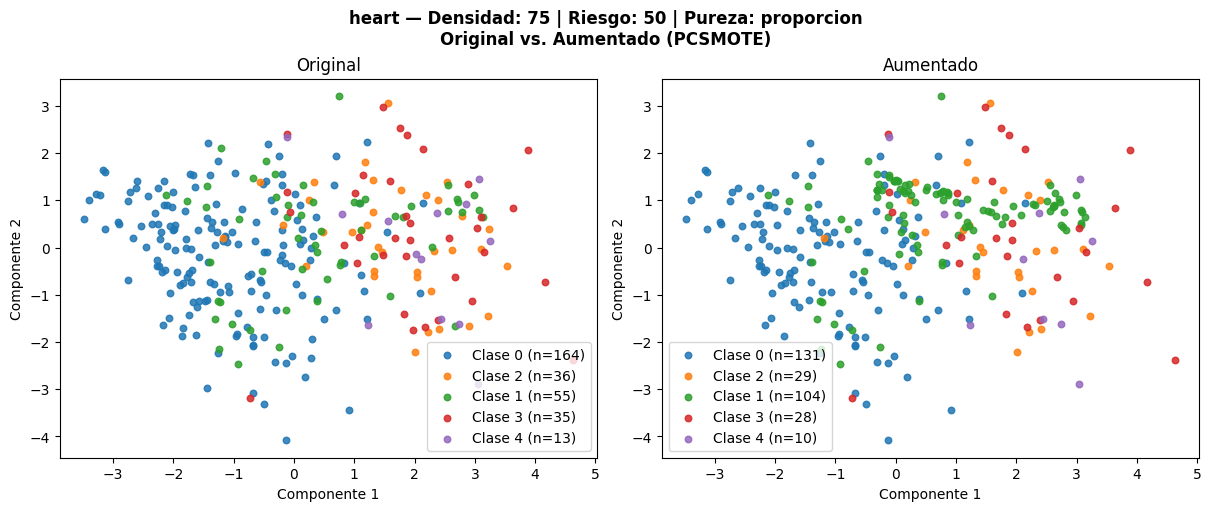

💾 Guardando datasets aumentados...
✅ Datasets guardados:
- Train aumentado: ../datasets/datasets_aumentados/pcsmote_heart_D75_R50_Pproporcion_train.csv
- Test escalado: ../datasets/datasets_aumentados/pcsmote_heart_D75_R50_Pproporcion_test.csv
✅ Guardado exitoso:
 - Train: ../datasets/datasets_aumentados/pcsmote_heart_D75_R50_Pproporcion_train.csv
 - Test: ../datasets/datasets_aumentados/pcsmote_heart_D75_R50_Pproporcion_test.csv
📁 Log por clase guardado en: ../datasets/datasets_aumentados/logs/pcsmote/por_clase/log_pcsmote_heart_D75_R50_Pproporcion.csv
📘 Log por muestra guardado en: ../datasets/datasets_aumentados/logs/pcsmote/por_muestras/log_pcsmote_x_muestra_heart_D75_R50_Pproporcion.xlsx
📄 Log exportado: ../datasets/datasets_aumentados/logs/pcsmote/por_clase/log_pcsmote_heart_D75_R50_Pproporcion.csv
📄 Log exportado: ../datasets/datasets_aumentados/logs/pcsmote/por_muestras/log_pcsmote_x_muestra_heart_D75_R50_Pproporcion.xlsx
#17 ➕ Aumentando con D=75 | R=75 | P=entropia
📂 Cargando

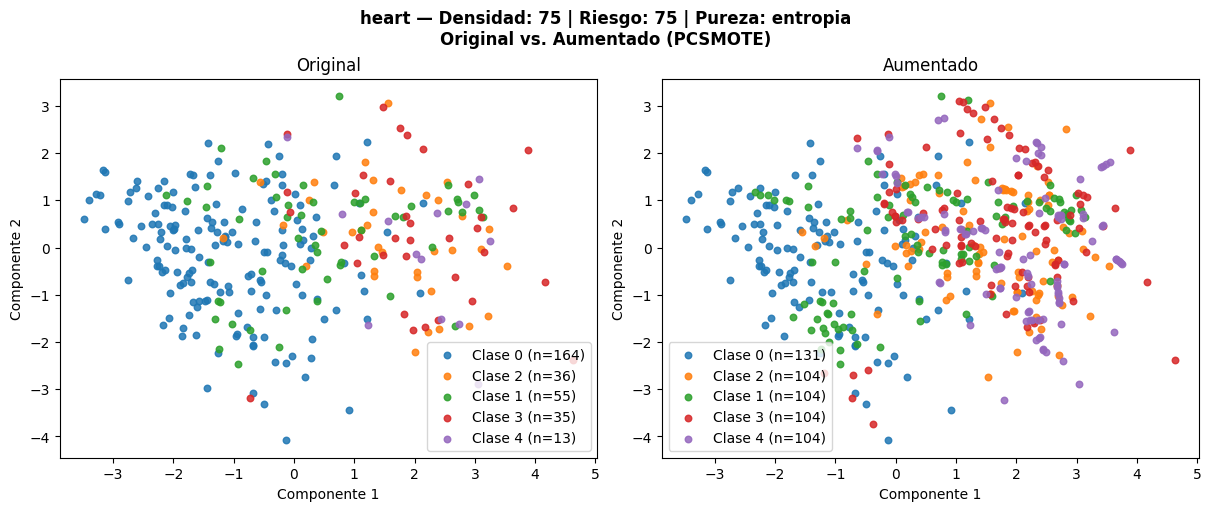

💾 Guardando datasets aumentados...
✅ Datasets guardados:
- Train aumentado: ../datasets/datasets_aumentados/pcsmote_heart_D75_R75_Pentropia_train.csv
- Test escalado: ../datasets/datasets_aumentados/pcsmote_heart_D75_R75_Pentropia_test.csv
✅ Guardado exitoso:
 - Train: ../datasets/datasets_aumentados/pcsmote_heart_D75_R75_Pentropia_train.csv
 - Test: ../datasets/datasets_aumentados/pcsmote_heart_D75_R75_Pentropia_test.csv
📁 Log por clase guardado en: ../datasets/datasets_aumentados/logs/pcsmote/por_clase/log_pcsmote_heart_D75_R75_Pentropia.csv
📘 Log por muestra guardado en: ../datasets/datasets_aumentados/logs/pcsmote/por_muestras/log_pcsmote_x_muestra_heart_D75_R75_Pentropia.xlsx
📄 Log exportado: ../datasets/datasets_aumentados/logs/pcsmote/por_clase/log_pcsmote_heart_D75_R75_Pentropia.csv
📄 Log exportado: ../datasets/datasets_aumentados/logs/pcsmote/por_muestras/log_pcsmote_x_muestra_heart_D75_R75_Pentropia.xlsx
#18 ➕ Aumentando con D=75 | R=75 | P=proporcion
📂 Cargando dataset: hear

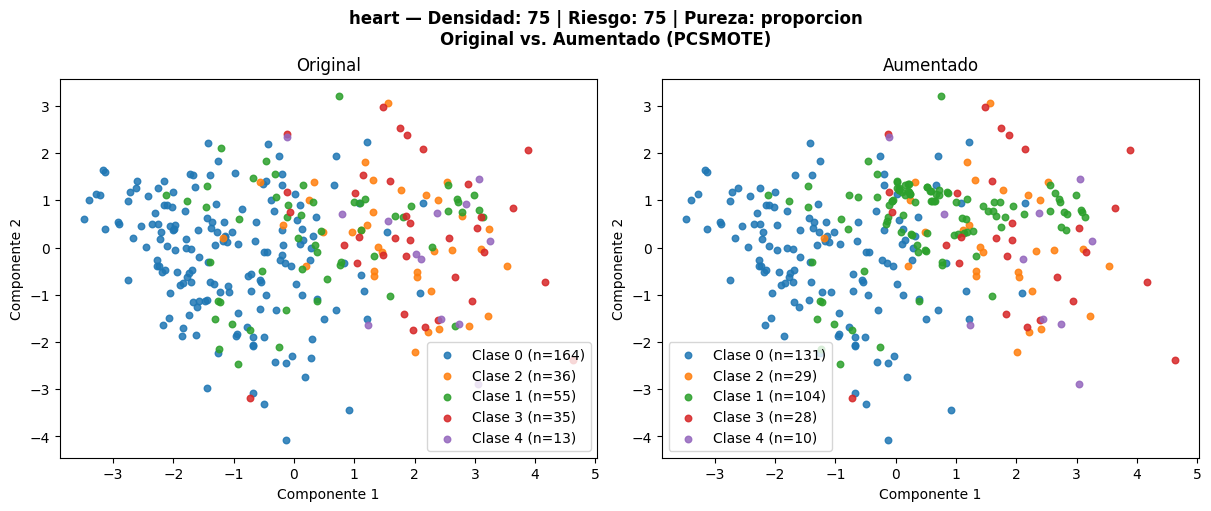

💾 Guardando datasets aumentados...
✅ Datasets guardados:
- Train aumentado: ../datasets/datasets_aumentados/pcsmote_heart_D75_R75_Pproporcion_train.csv
- Test escalado: ../datasets/datasets_aumentados/pcsmote_heart_D75_R75_Pproporcion_test.csv
✅ Guardado exitoso:
 - Train: ../datasets/datasets_aumentados/pcsmote_heart_D75_R75_Pproporcion_train.csv
 - Test: ../datasets/datasets_aumentados/pcsmote_heart_D75_R75_Pproporcion_test.csv
📁 Log por clase guardado en: ../datasets/datasets_aumentados/logs/pcsmote/por_clase/log_pcsmote_heart_D75_R75_Pproporcion.csv
📘 Log por muestra guardado en: ../datasets/datasets_aumentados/logs/pcsmote/por_muestras/log_pcsmote_x_muestra_heart_D75_R75_Pproporcion.xlsx
📄 Log exportado: ../datasets/datasets_aumentados/logs/pcsmote/por_clase/log_pcsmote_heart_D75_R75_Pproporcion.csv
📄 Log exportado: ../datasets/datasets_aumentados/logs/pcsmote/por_muestras/log_pcsmote_x_muestra_heart_D75_R75_Pproporcion.xlsx


In [5]:
percentiles_densidad = [25, 50, 75]
percentiles_riesgo = [25, 50, 75]
criterios_pureza = ["entropia", "proporcion"]
combinaciones = list(product(percentiles_densidad, percentiles_riesgo, criterios_pureza))
os.makedirs("../logs/", exist_ok=True)

for nombre_dataset, config in config_datasets.items():
    if nombre_dataset == "eurosat":
        continue

    print(f"\n📁 Dataset: {nombre_dataset}")

    # --- CASO BASE ---
    # base_train, base_test = generar_caso_base(nombre_dataset, config)
    # print(f"🟦 Caso base generado:\n - Train: {base_train}\n - Test: {base_test}")

    # --- GRID DE PCSMOTE ---
    for idx, (pdens, priesgo, criterio) in enumerate(combinaciones, start=1):
        print(f"#{idx:02d} ➕ Aumentando con D={pdens} | R={priesgo} | P={criterio}")

        path_train, path_test, sampler = aumentar_dataset_pcsmote_y_guardar(
            nombre_dataset=nombre_dataset,
            config=config,
            percentil_densidad=pdens,
            percentil_riesgo=priesgo,
            criterio_pureza=criterio
        )

        if path_train and sampler:
            print(f"✅ Guardado exitoso:\n - Train: {path_train}\n - Test: {path_test}")
            log_path_x_clase = f"../datasets/datasets_aumentados/logs/pcsmote/por_clase/log_pcsmote_{nombre_dataset}_D{pdens}_R{priesgo}_P{criterio}.csv"
            log_path_x_muestras = f"../datasets/datasets_aumentados/logs/pcsmote/por_muestras/log_pcsmote_x_muestra_{nombre_dataset}_D{pdens}_R{priesgo}_P{criterio}.xlsx"

            sampler.exportar_log_csv(log_path_x_clase)
            sampler.exportar_log_muestras_excel(log_path_x_muestras)

            print(f"📄 Log exportado: {log_path_x_clase}")
            print(f"📄 Log exportado: {log_path_x_muestras}")

        else:
            print("❌ Falló la generación.")
